# TESS Atlas fit for TOI 469

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 469.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-469.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-469.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-469.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 469

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 469 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

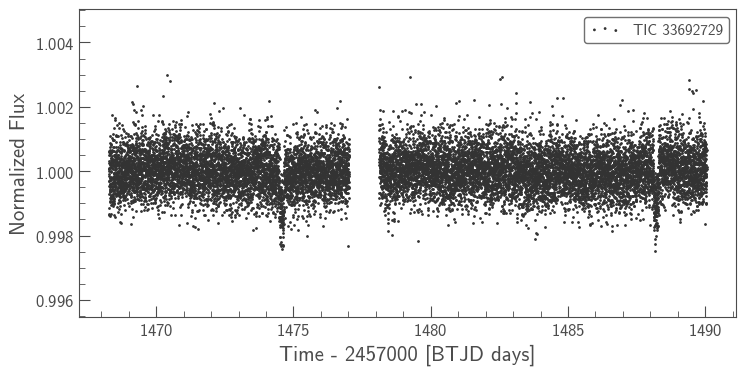

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -19707.591366403743 -> -19530.51954018572


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -15426.359410352892 -> -13362.299401930173


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -13362.299401930173 -> -13323.345618971713


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -13323.345618971713 -> -13317.124148795152


optimizing logp for variables: ['mean', 't0', 'logP']


message: Optimization terminated successfully.
logp: -13317.124148795152 -> -13317.009817487879


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -13317.009817487879 -> -13316.871107924213


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -13316.871107924213 -> -13315.633080842746


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -13315.633080842745 -> -13315.633080842745


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -13315.633080842746 -> -13315.633080842723


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -13315.633080842723 -> -13315.633080842712


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -13315.633080842712 -> -13315.633080842712


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -13315.633080842712 -> -13315.633080842712


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -13315.633080842712 -> -13315.633080842712


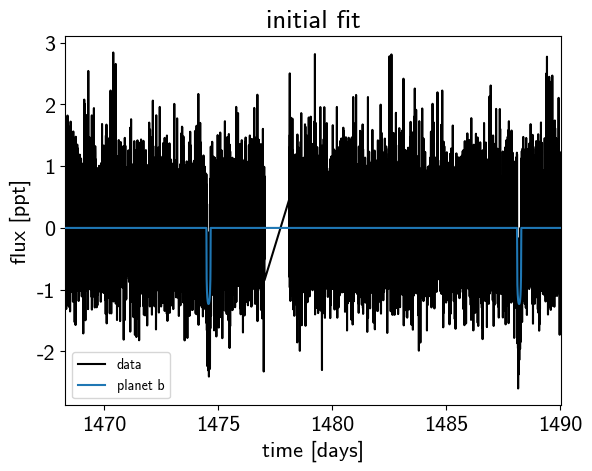

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:08, 11.17draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:15,  5.97draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:14,  6.16draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:02<00:24,  3.73draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:24,  3.65draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:24,  3.51draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:25,  3.43draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:24,  3.41draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:29,  2.81draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:05<00:28,  2.91draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:05<00:23,  3.41draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:05<00:33,  2.41draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:06<00:29,  2.64draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:06<00:30,  2.57draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:07<00:30,  2.50draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:07<00:28,  2.69draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:07<00:28,  2.63draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:08<00:26,  2.82draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:08<00:29,  2.49draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:08<00:25,  2.87draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:09<00:31,  2.23draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:10<00:28,  2.41draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:10<00:27,  2.50draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:10<00:26,  2.58draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:11<00:27,  2.42draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:11<00:23,  2.74draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:12<00:25,  2.53draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:12<00:23,  2.63draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:12<00:23,  2.60draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:13<00:27,  2.24draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:13<00:21,  2.85draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:14<00:27,  2.18draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:14<00:21,  2.71draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:14<00:23,  2.45draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:15<00:21,  2.63draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:15<00:23,  2.37draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:16<00:22,  2.41draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:16<00:20,  2.57draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:17<00:23,  2.18draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:17<00:18,  2.81draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:17<00:21,  2.34draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:18<00:20,  2.40draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:18<00:18,  2.62draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:18<00:18,  2.54draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:19<00:15,  2.95draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:19<00:17,  2.59draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:19<00:14,  3.06draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:20<00:16,  2.59draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:20<00:12,  3.26draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:21<00:15,  2.56draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:21<00:13,  2.79draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:21<00:11,  3.25draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:22<00:13,  2.78draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:22<00:12,  2.99draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:23<00:13,  2.52draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:23<00:12,  2.74draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:24<00:14,  2.24draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:24<00:13,  2.29draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:25<00:11,  2.44draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:26<00:10,  2.47draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:26<00:08,  3.14draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:27<00:10,  2.48draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:27<00:08,  2.59draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:28<00:07,  2.67draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:29<00:06,  2.79draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:29<00:05,  3.41draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:29<00:06,  2.67draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:30<00:05,  3.10draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:30<00:06,  2.36draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:31<00:05,  2.42draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:32<00:04,  2.54draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:32<00:03,  2.62draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:33<00:02,  2.72draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:33<00:01,  3.34draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:34<00:01,  2.67draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:34<00:01,  3.32draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:34<00:01,  2.60draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:35<00:01,  1.95draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:37<00:00,  1.26draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:38<00:00,  1.02s/draws]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:07, 12.09draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:15,  5.93draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:15,  6.07draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:02<00:24,  3.66draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:24,  3.62draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:28,  3.17draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:03<00:29,  3.03draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:30,  2.85draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:04<00:34,  2.50draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:04<00:31,  2.66draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:05<00:36,  2.31draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:05<00:35,  2.37draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:05<00:32,  2.53draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:06<00:36,  2.22draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:06<00:28,  2.82draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:07<00:28,  2.75draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:07<00:21,  3.51draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:07<00:29,  2.54draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:08<00:22,  3.23draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:08<00:29,  2.50draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:09<00:25,  2.77draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:09<00:26,  2.67draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:09<00:24,  2.85draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:10<00:25,  2.72draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:10<00:23,  2.86draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:10<00:24,  2.68draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:11<00:24,  2.64draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:11<00:17,  3.50draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:12<00:24,  2.49draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:12<00:19,  3.16draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:13<00:26,  2.27draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:14<00:24,  2.38draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:14<00:19,  2.91draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:14<00:22,  2.51draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:14<00:18,  3.04draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:15<00:22,  2.41draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:16<00:20,  2.51draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:16<00:16,  3.15draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:17<00:23,  2.11draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:17<00:16,  2.88draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:18<00:22,  2.04draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:18<00:17,  2.56draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:19<00:22,  1.96draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:19<00:20,  2.13draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:20<00:17,  2.31draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:21<00:15,  2.45draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:21<00:11,  3.29draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:21<00:12,  2.87draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:22<00:11,  3.14draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:22<00:12,  2.82draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:22<00:10,  3.12draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:23<00:12,  2.59draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:23<00:11,  2.76draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:24<00:11,  2.62draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:24<00:10,  2.68draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:24<00:10,  2.73draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:25<00:10,  2.68draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:25<00:09,  2.84draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:25<00:09,  2.72draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:26<00:08,  2.87draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:26<00:08,  2.70draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:26<00:07,  3.07draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:27<00:07,  2.75draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:27<00:06,  3.10draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:27<00:06,  2.83draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:28<00:05,  3.11draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:28<00:06,  2.67draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:28<00:05,  3.15draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:29<00:04,  3.09draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:29<00:04,  3.03draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:29<00:04,  3.20draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:30<00:04,  2.69draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:30<00:03,  3.37draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:31<00:04,  2.48draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:31<00:03,  2.58draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:32<00:02,  2.72draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:32<00:01,  2.97draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:33<00:01,  2.75draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:33<00:01,  2.42draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:34<00:00,  2.03draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:35<00:00,  1.27draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:36<00:00,  1.11draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<01:29,  2.27draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:00<01:04,  3.08draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:00<00:51,  3.85draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:01<00:40,  4.81draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:01<00:30,  6.22draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:01<00:28,  6.59draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:01<00:28,  6.65draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:02<00:25,  7.16draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:02<00:21,  8.40draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:02<00:17, 10.04draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:02<00:22,  7.77draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:02<00:17,  9.81draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:03<00:15, 11.39draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:03<00:14, 11.42draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:03<00:11, 14.25draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:03<00:13, 12.40draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:03<00:14, 11.05draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:04<00:15, 10.33draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:04<00:19,  8.03draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:05<00:25,  5.92draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:05<00:21,  7.04draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:05<00:22,  6.67draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:05<00:19,  7.48draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:05<00:17,  8.36draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:06<00:12, 10.99draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:06<00:14,  9.85draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:06<00:12, 10.64draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:06<00:12, 10.76draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:06<00:11, 11.65draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:07<00:12, 10.75draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:07<00:12,  9.94draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:07<00:13,  9.36draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:07<00:11, 10.49draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:07<00:10, 11.75draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:08<00:11, 10.39draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:08<00:10, 11.24draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:08<00:11, 10.35draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:08<00:10, 10.57draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:08<00:09, 11.32draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:09<00:18,  6.00draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:09<00:15,  6.96draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:09<00:14,  7.25draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:09<00:12,  8.39draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:10<00:19,  5.31draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:10<00:17,  5.83draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:10<00:15,  6.51draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:11<00:14,  6.67draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:11<00:28,  3.45draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:12<00:25,  3.69draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:12<00:21,  4.41draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:12<00:17,  5.37draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:12<00:16,  5.65draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:13<00:13,  6.72draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:13<00:15,  5.57draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:13<00:13,  6.61draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:13<00:11,  7.22draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:13<00:11,  7.07draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:14<00:09,  8.25draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:14<00:07,  9.99draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:14<00:08,  8.70draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:14<00:06, 10.60draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:14<00:08,  8.58draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:15<00:06, 10.88draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:15<00:08,  7.38draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:15<00:07,  8.16draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:15<00:06,  9.76draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:16<00:05, 10.82draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:16<00:04, 11.70draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:16<00:04, 11.61draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:16<00:04, 11.76draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:16<00:03, 12.51draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:16<00:04, 11.61draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:16<00:03, 12.66draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:17<00:03, 12.64draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:17<00:03, 11.79draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [00:17<00:03, 12.18draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:18<00:06,  5.74draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:18<00:06,  5.82draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:18<00:06,  5.14draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:19<00:05,  6.47draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [00:19<00:04,  7.05draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:19<00:04,  6.61draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:19<00:03,  7.84draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [00:19<00:03,  7.97draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:19<00:03,  7.96draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [00:20<00:03,  7.61draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:20<00:02,  7.98draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [00:20<00:02,  9.53draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:20<00:01, 10.35draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [00:20<00:01,  8.49draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:21<00:01,  9.01draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:21<00:01, 10.73draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:21<00:00, 10.26draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:21<00:01,  6.73draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:22<00:01,  5.46draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:22<00:00,  5.77draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:22<00:00,  4.91draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:23<00:00,  3.62draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [00:23<00:00,  3.16draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:23<00:00,  8.63draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 5/404 [00:00<00:09, 42.01draws/s]

Sampling 2 chains:   2%|▏         | 8/404 [00:00<00:20, 19.31draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:00<00:33, 11.83draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:00<00:44,  8.88draws/s]

Sampling 2 chains:   3%|▎         | 13/404 [00:01<00:39,  9.87draws/s]

Sampling 2 chains:   4%|▎         | 15/404 [00:01<00:47,  8.21draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:01<00:38,  9.94draws/s]

Sampling 2 chains:   5%|▍         | 19/404 [00:02<00:58,  6.53draws/s]

Sampling 2 chains:   5%|▌         | 21/404 [00:02<01:03,  6.07draws/s]

Sampling 2 chains:   5%|▌         | 22/404 [00:02<01:32,  4.13draws/s]

Sampling 2 chains:   6%|▌         | 23/404 [00:03<01:49,  3.49draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:03<01:54,  3.31draws/s]

Sampling 2 chains:   6%|▋         | 26/404 [00:04<01:44,  3.62draws/s]

Sampling 2 chains:   7%|▋         | 27/404 [00:04<02:04,  3.04draws/s]

Sampling 2 chains:   7%|▋         | 28/404 [00:05<02:23,  2.63draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:05<01:58,  3.17draws/s]

Sampling 2 chains:   8%|▊         | 31/404 [00:05<01:36,  3.88draws/s]

Sampling 2 chains:   8%|▊         | 32/404 [00:05<01:27,  4.25draws/s]

Sampling 2 chains:   8%|▊         | 33/404 [00:05<01:24,  4.42draws/s]

Sampling 2 chains:   9%|▉         | 36/404 [00:06<01:04,  5.73draws/s]

Sampling 2 chains:   9%|▉         | 37/404 [00:06<00:56,  6.48draws/s]

Sampling 2 chains:  10%|▉         | 40/404 [00:06<00:46,  7.90draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:06<00:37,  9.62draws/s]

Sampling 2 chains:  11%|█         | 44/404 [00:06<00:33, 10.61draws/s]

Sampling 2 chains:  12%|█▏        | 47/404 [00:06<00:30, 11.53draws/s]

Sampling 2 chains:  12%|█▏        | 49/404 [00:07<00:31, 11.36draws/s]

Sampling 2 chains:  13%|█▎        | 52/404 [00:07<00:26, 13.11draws/s]

Sampling 2 chains:  14%|█▎        | 55/404 [00:07<00:23, 14.74draws/s]

Sampling 2 chains:  15%|█▍        | 59/404 [00:07<00:21, 16.23draws/s]

Sampling 2 chains:  15%|█▌        | 61/404 [00:08<00:40,  8.50draws/s]

Sampling 2 chains:  16%|█▌        | 63/404 [00:08<00:40,  8.41draws/s]

Sampling 2 chains:  16%|█▌        | 65/404 [00:08<00:49,  6.87draws/s]

Sampling 2 chains:  17%|█▋        | 67/404 [00:08<00:43,  7.73draws/s]

Sampling 2 chains:  17%|█▋        | 69/404 [00:09<00:59,  5.59draws/s]

Sampling 2 chains:  18%|█▊        | 71/404 [00:10<01:23,  4.01draws/s]

Sampling 2 chains:  18%|█▊        | 73/404 [00:10<01:28,  3.73draws/s]

Sampling 2 chains:  18%|█▊        | 74/404 [00:11<01:32,  3.55draws/s]

Sampling 2 chains:  19%|█▊        | 75/404 [00:11<01:52,  2.92draws/s]

Sampling 2 chains:  19%|█▉        | 76/404 [00:11<01:37,  3.36draws/s]

Sampling 2 chains:  19%|█▉        | 77/404 [00:12<01:37,  3.36draws/s]

Sampling 2 chains:  19%|█▉        | 78/404 [00:12<01:57,  2.77draws/s]

Sampling 2 chains:  20%|█▉        | 80/404 [00:13<01:39,  3.25draws/s]

Sampling 2 chains:  20%|██        | 81/404 [00:13<01:27,  3.69draws/s]

Sampling 2 chains:  21%|██        | 83/404 [00:13<01:14,  4.34draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:13<00:59,  5.41draws/s]

Sampling 2 chains:  22%|██▏       | 87/404 [00:13<00:46,  6.76draws/s]

Sampling 2 chains:  23%|██▎       | 91/404 [00:13<00:34,  8.98draws/s]

Sampling 2 chains:  23%|██▎       | 93/404 [00:14<00:29, 10.61draws/s]

Sampling 2 chains:  24%|██▎       | 95/404 [00:14<00:25, 12.04draws/s]

Sampling 2 chains:  24%|██▍       | 97/404 [00:14<00:25, 11.85draws/s]

Sampling 2 chains:  25%|██▍       | 99/404 [00:14<00:26, 11.64draws/s]

Sampling 2 chains:  25%|██▌       | 101/404 [00:14<00:24, 12.59draws/s]

Sampling 2 chains:  25%|██▌       | 103/404 [00:14<00:22, 13.28draws/s]

Sampling 2 chains:  26%|██▌       | 105/404 [00:14<00:20, 14.77draws/s]

Sampling 2 chains:  26%|██▋       | 107/404 [00:15<00:21, 13.72draws/s]

Sampling 2 chains:  27%|██▋       | 109/404 [00:15<00:20, 14.23draws/s]

Sampling 2 chains:  27%|██▋       | 111/404 [00:15<00:22, 13.03draws/s]

Sampling 2 chains:  28%|██▊       | 114/404 [00:15<00:18, 15.42draws/s]

Sampling 2 chains:  29%|██▊       | 116/404 [00:15<00:17, 16.26draws/s]

Sampling 2 chains:  29%|██▉       | 118/404 [00:15<00:23, 12.29draws/s]

Sampling 2 chains:  30%|██▉       | 120/404 [00:15<00:24, 11.79draws/s]

Sampling 2 chains:  30%|███       | 122/404 [00:16<00:21, 13.27draws/s]

Sampling 2 chains:  31%|███       | 124/404 [00:16<00:20, 13.60draws/s]

Sampling 2 chains:  31%|███▏      | 127/404 [00:16<00:18, 15.24draws/s]

Sampling 2 chains:  32%|███▏      | 131/404 [00:16<00:15, 17.79draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:16<00:18, 14.94draws/s]

Sampling 2 chains:  34%|███▎      | 136/404 [00:16<00:20, 13.13draws/s]

Sampling 2 chains:  34%|███▍      | 139/404 [00:17<00:19, 13.66draws/s]

Sampling 2 chains:  35%|███▍      | 141/404 [00:17<00:17, 14.98draws/s]

Sampling 2 chains:  35%|███▌      | 143/404 [00:17<00:16, 15.97draws/s]

Sampling 2 chains:  36%|███▌      | 146/404 [00:17<00:15, 17.04draws/s]

Sampling 2 chains:  37%|███▋      | 149/404 [00:17<00:13, 18.31draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:17<00:13, 18.51draws/s]

Sampling 2 chains:  38%|███▊      | 153/404 [00:17<00:15, 15.69draws/s]

Sampling 2 chains:  38%|███▊      | 155/404 [00:18<00:15, 16.13draws/s]

Sampling 2 chains:  39%|███▉      | 157/404 [00:18<00:16, 14.53draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [00:18<00:15, 15.40draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [00:18<00:15, 15.99draws/s]

Sampling 2 chains:  41%|████      | 164/404 [00:18<00:13, 17.23draws/s]

Sampling 2 chains:  41%|████▏     | 167/404 [00:18<00:12, 18.33draws/s]

Sampling 2 chains:  42%|████▏     | 170/404 [00:18<00:13, 17.35draws/s]

Sampling 2 chains:  43%|████▎     | 172/404 [00:19<00:12, 18.01draws/s]

Sampling 2 chains:  43%|████▎     | 175/404 [00:19<00:11, 19.25draws/s]

Sampling 2 chains:  44%|████▍     | 177/404 [00:19<00:12, 18.46draws/s]

Sampling 2 chains:  45%|████▍     | 180/404 [00:19<00:10, 20.39draws/s]

Sampling 2 chains:  45%|████▌     | 183/404 [00:19<00:14, 15.21draws/s]

Sampling 2 chains:  46%|████▋     | 187/404 [00:19<00:12, 17.05draws/s]

Sampling 2 chains:  47%|████▋     | 189/404 [00:20<00:13, 15.72draws/s]

Sampling 2 chains:  47%|████▋     | 191/404 [00:20<00:15, 13.56draws/s]

Sampling 2 chains:  48%|████▊     | 193/404 [00:20<00:17, 11.82draws/s]

Sampling 2 chains:  48%|████▊     | 195/404 [00:20<00:18, 11.14draws/s]

Sampling 2 chains:  49%|████▉     | 197/404 [00:21<00:27,  7.43draws/s]

Sampling 2 chains:  49%|████▉     | 199/404 [00:21<00:29,  6.96draws/s]

Sampling 2 chains:  50%|████▉     | 200/404 [00:21<00:47,  4.33draws/s]

Sampling 2 chains:  50%|█████     | 202/404 [00:22<00:47,  4.27draws/s]

Sampling 2 chains:  50%|█████     | 203/404 [00:22<00:45,  4.41draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:22<00:49,  4.05draws/s]

Sampling 2 chains:  51%|█████     | 205/404 [00:23<00:54,  3.63draws/s]

Sampling 2 chains:  51%|█████     | 206/404 [00:23<00:47,  4.19draws/s]

Sampling 2 chains:  51%|█████     | 207/404 [00:23<01:01,  3.20draws/s]

Sampling 2 chains:  52%|█████▏    | 209/404 [00:24<00:57,  3.38draws/s]

Sampling 2 chains:  52%|█████▏    | 210/404 [00:24<00:48,  4.00draws/s]

Sampling 2 chains:  52%|█████▏    | 211/404 [00:25<01:12,  2.67draws/s]

Sampling 2 chains:  52%|█████▏    | 212/404 [00:25<01:00,  3.19draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:25<01:11,  2.68draws/s]

Sampling 2 chains:  53%|█████▎    | 214/404 [00:26<01:18,  2.42draws/s]

Sampling 2 chains:  53%|█████▎    | 215/404 [00:26<01:07,  2.81draws/s]

Sampling 2 chains:  53%|█████▎    | 216/404 [00:27<01:13,  2.55draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:27<01:03,  2.97draws/s]

Sampling 2 chains:  54%|█████▍    | 218/404 [00:27<01:07,  2.78draws/s]

Sampling 2 chains:  54%|█████▍    | 219/404 [00:27<00:56,  3.27draws/s]

Sampling 2 chains:  54%|█████▍    | 220/404 [00:28<01:09,  2.65draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:28<00:56,  3.23draws/s]

Sampling 2 chains:  55%|█████▍    | 222/404 [00:29<01:14,  2.44draws/s]

Sampling 2 chains:  55%|█████▌    | 223/404 [00:29<01:01,  2.94draws/s]

Sampling 2 chains:  55%|█████▌    | 224/404 [00:29<01:12,  2.47draws/s]

Sampling 2 chains:  56%|█████▌    | 225/404 [00:30<01:13,  2.45draws/s]

Sampling 2 chains:  56%|█████▌    | 226/404 [00:30<01:01,  2.88draws/s]

Sampling 2 chains:  56%|█████▌    | 227/404 [00:30<00:57,  3.10draws/s]

Sampling 2 chains:  56%|█████▋    | 228/404 [00:31<00:57,  3.06draws/s]

Sampling 2 chains:  57%|█████▋    | 229/404 [00:31<00:46,  3.73draws/s]

Sampling 2 chains:  57%|█████▋    | 230/404 [00:31<00:57,  3.04draws/s]

Sampling 2 chains:  57%|█████▋    | 231/404 [00:31<00:45,  3.80draws/s]

Sampling 2 chains:  57%|█████▋    | 232/404 [00:32<00:49,  3.51draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [00:32<00:41,  4.13draws/s]

Sampling 2 chains:  58%|█████▊    | 234/404 [00:32<00:38,  4.39draws/s]

Sampling 2 chains:  58%|█████▊    | 235/404 [00:32<00:44,  3.84draws/s]

Sampling 2 chains:  59%|█████▊    | 237/404 [00:33<00:38,  4.30draws/s]

Sampling 2 chains:  59%|█████▉    | 238/404 [00:33<00:42,  3.94draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:33<00:38,  4.30draws/s]

Sampling 2 chains:  60%|█████▉    | 241/404 [00:34<00:34,  4.70draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [00:34<00:28,  5.73draws/s]

Sampling 2 chains:  60%|██████    | 244/404 [00:34<00:38,  4.14draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:34<00:37,  4.23draws/s]

Sampling 2 chains:  61%|██████    | 247/404 [00:35<00:31,  4.92draws/s]

Sampling 2 chains:  61%|██████▏   | 248/404 [00:35<00:26,  5.79draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:35<00:23,  6.60draws/s]

Sampling 2 chains:  62%|██████▏   | 250/404 [00:35<00:21,  7.13draws/s]

Sampling 2 chains:  62%|██████▏   | 252/404 [00:35<00:18,  8.25draws/s]

Sampling 2 chains:  63%|██████▎   | 255/404 [00:35<00:14, 10.39draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [00:35<00:12, 11.77draws/s]

Sampling 2 chains:  64%|██████▍   | 259/404 [00:35<00:12, 11.67draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [00:36<00:11, 12.51draws/s]

Sampling 2 chains:  65%|██████▌   | 264/404 [00:36<00:10, 13.75draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [00:36<00:09, 14.26draws/s]

Sampling 2 chains:  66%|██████▋   | 268/404 [00:36<00:17,  7.99draws/s]

Sampling 2 chains:  67%|██████▋   | 270/404 [00:38<00:37,  3.56draws/s]

Sampling 2 chains:  67%|██████▋   | 271/404 [00:38<00:35,  3.80draws/s]

Sampling 2 chains:  67%|██████▋   | 272/404 [00:38<00:46,  2.83draws/s]

Sampling 2 chains:  68%|██████▊   | 273/404 [00:39<00:46,  2.85draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [00:39<00:48,  2.67draws/s]

Sampling 2 chains:  68%|██████▊   | 275/404 [00:40<00:48,  2.67draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [00:40<00:46,  2.73draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [00:40<00:45,  2.80draws/s]

Sampling 2 chains:  69%|██████▉   | 278/404 [00:41<00:38,  3.30draws/s]

Sampling 2 chains:  69%|██████▉   | 279/404 [00:41<00:33,  3.74draws/s]

Sampling 2 chains:  70%|██████▉   | 281/404 [00:41<00:27,  4.56draws/s]

Sampling 2 chains:  70%|███████   | 283/404 [00:41<00:21,  5.53draws/s]

Sampling 2 chains:  71%|███████   | 285/404 [00:41<00:18,  6.50draws/s]

Sampling 2 chains:  71%|███████   | 287/404 [00:41<00:14,  7.87draws/s]

Sampling 2 chains:  72%|███████▏  | 290/404 [00:42<00:11,  9.84draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [00:42<00:10, 10.77draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [00:42<00:09, 11.21draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [00:42<00:09, 11.64draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [00:43<00:26,  3.94draws/s]

Sampling 2 chains:  74%|███████▍  | 300/404 [00:44<00:28,  3.65draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [00:44<00:39,  2.64draws/s]

Sampling 2 chains:  75%|███████▍  | 302/404 [00:45<00:46,  2.20draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [00:45<00:39,  2.57draws/s]

Sampling 2 chains:  75%|███████▌  | 304/404 [00:46<00:47,  2.11draws/s]

Sampling 2 chains:  75%|███████▌  | 305/404 [00:46<00:51,  1.91draws/s]

Sampling 2 chains:  76%|███████▌  | 306/404 [00:47<00:53,  1.84draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [00:48<00:54,  1.79draws/s]

Sampling 2 chains:  76%|███████▌  | 308/404 [00:48<00:54,  1.76draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [00:49<00:54,  1.74draws/s]

Sampling 2 chains:  77%|███████▋  | 310/404 [00:49<00:46,  2.03draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [00:50<00:49,  1.86draws/s]

Sampling 2 chains:  77%|███████▋  | 312/404 [00:50<00:42,  2.15draws/s]

Sampling 2 chains:  77%|███████▋  | 313/404 [00:50<00:37,  2.42draws/s]

Sampling 2 chains:  78%|███████▊  | 314/404 [00:51<00:30,  2.99draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [00:51<00:24,  3.59draws/s]

Sampling 2 chains:  78%|███████▊  | 316/404 [00:51<00:21,  4.17draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [00:51<00:17,  4.92draws/s]

Sampling 2 chains:  79%|███████▉  | 320/404 [00:51<00:13,  6.08draws/s]

Sampling 2 chains:  80%|███████▉  | 322/404 [00:51<00:11,  7.26draws/s]

Sampling 2 chains:  80%|███████▉  | 323/404 [00:52<00:11,  7.00draws/s]

Sampling 2 chains:  81%|████████  | 326/404 [00:52<00:08,  8.89draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [00:52<00:06, 10.76draws/s]

Sampling 2 chains:  82%|████████▏ | 331/404 [00:52<00:06, 11.87draws/s]

Sampling 2 chains:  83%|████████▎ | 334/404 [00:52<00:05, 13.84draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [00:52<00:04, 14.61draws/s]

Sampling 2 chains:  84%|████████▍ | 339/404 [00:52<00:03, 16.55draws/s]

Sampling 2 chains:  84%|████████▍ | 341/404 [00:52<00:03, 16.48draws/s]

Sampling 2 chains:  85%|████████▍ | 343/404 [00:53<00:03, 16.30draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [00:53<00:03, 18.24draws/s]

Sampling 2 chains:  86%|████████▋ | 349/404 [00:53<00:02, 19.66draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:53<00:02, 20.28draws/s]

Sampling 2 chains:  88%|████████▊ | 355/404 [00:53<00:02, 21.33draws/s]

Sampling 2 chains:  89%|████████▊ | 358/404 [00:53<00:02, 22.17draws/s]

Sampling 2 chains:  89%|████████▉ | 361/404 [00:53<00:01, 22.70draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [00:53<00:01, 23.01draws/s]

Sampling 2 chains:  91%|█████████ | 367/404 [00:54<00:01, 23.22draws/s]

Sampling 2 chains:  92%|█████████▏| 370/404 [00:54<00:01, 21.03draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [00:54<00:01, 19.87draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [00:54<00:01, 21.52draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [00:55<00:02,  9.19draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [00:56<00:04,  5.37draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [00:56<00:04,  4.85draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [00:56<00:03,  5.42draws/s]

Sampling 2 chains:  96%|█████████▌| 387/404 [00:56<00:03,  5.40draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:57<00:03,  5.27draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [00:57<00:02,  6.27draws/s]

Sampling 2 chains:  97%|█████████▋| 391/404 [00:57<00:01,  6.97draws/s]

Sampling 2 chains:  97%|█████████▋| 393/404 [00:57<00:01,  7.95draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [00:57<00:01,  8.75draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [00:57<00:00, 10.24draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [00:58<00:00, 10.13draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [00:58<00:00, 12.26draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:58<00:00, 12.94draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 5/804 [00:00<00:18, 42.73draws/s]

Sampling 2 chains:   1%|          | 8/804 [00:00<00:23, 33.45draws/s]

Sampling 2 chains:   2%|▏         | 13/804 [00:00<00:22, 35.09draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:00<00:23, 34.05draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:00<00:26, 29.47draws/s]

Sampling 2 chains:   3%|▎         | 24/804 [00:00<00:24, 31.68draws/s]

Sampling 2 chains:   4%|▍         | 31/804 [00:00<00:21, 36.27draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:01<00:22, 33.82draws/s]

Sampling 2 chains:   5%|▍         | 39/804 [00:01<00:27, 27.49draws/s]

Sampling 2 chains:   5%|▌         | 43/804 [00:01<00:26, 29.03draws/s]

Sampling 2 chains:   6%|▌         | 47/804 [00:01<00:31, 24.14draws/s]

Sampling 2 chains:   6%|▌         | 50/804 [00:01<00:52, 14.39draws/s]

Sampling 2 chains:   7%|▋         | 53/804 [00:02<00:46, 16.28draws/s]

Sampling 2 chains:   7%|▋         | 56/804 [00:02<00:42, 17.73draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:02<00:39, 18.82draws/s]

Sampling 2 chains:   8%|▊         | 62/804 [00:02<00:39, 18.55draws/s]

Sampling 2 chains:   8%|▊         | 67/804 [00:02<00:32, 22.36draws/s]

Sampling 2 chains:   9%|▉         | 72/804 [00:02<00:28, 25.76draws/s]

Sampling 2 chains:   9%|▉         | 76/804 [00:02<00:26, 26.99draws/s]

Sampling 2 chains:  10%|▉         | 80/804 [00:03<00:24, 29.13draws/s]

Sampling 2 chains:  11%|█         | 85/804 [00:03<00:23, 30.61draws/s]

Sampling 2 chains:  11%|█         | 89/804 [00:03<00:25, 27.98draws/s]

Sampling 2 chains:  12%|█▏        | 94/804 [00:03<00:24, 29.41draws/s]

Sampling 2 chains:  12%|█▏        | 98/804 [00:03<00:24, 28.60draws/s]

Sampling 2 chains:  13%|█▎        | 102/804 [00:03<00:24, 28.94draws/s]

Sampling 2 chains:  13%|█▎        | 106/804 [00:03<00:23, 29.36draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:04<00:21, 32.55draws/s]

Sampling 2 chains:  14%|█▍        | 115/804 [00:04<00:20, 34.01draws/s]

Sampling 2 chains:  15%|█▍        | 120/804 [00:04<00:19, 34.24draws/s]

Sampling 2 chains:  15%|█▌        | 124/804 [00:04<00:23, 28.79draws/s]

Sampling 2 chains:  16%|█▌        | 128/804 [00:04<00:29, 22.97draws/s]

Sampling 2 chains:  16%|█▋        | 131/804 [00:04<00:30, 21.86draws/s]

Sampling 2 chains:  17%|█▋        | 134/804 [00:04<00:30, 22.09draws/s]

Sampling 2 chains:  17%|█▋        | 137/804 [00:05<00:34, 19.44draws/s]

Sampling 2 chains:  17%|█▋        | 140/804 [00:05<00:32, 20.74draws/s]

Sampling 2 chains:  18%|█▊        | 144/804 [00:05<00:29, 22.35draws/s]

Sampling 2 chains:  18%|█▊        | 147/804 [00:05<00:32, 20.47draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:05<00:31, 20.92draws/s]

Sampling 2 chains:  19%|█▉        | 153/804 [00:05<00:31, 20.52draws/s]

Sampling 2 chains:  19%|█▉        | 156/804 [00:06<00:32, 20.18draws/s]

Sampling 2 chains:  20%|█▉        | 159/804 [00:06<00:31, 20.41draws/s]

Sampling 2 chains:  20%|██        | 162/804 [00:06<00:30, 20.98draws/s]

Sampling 2 chains:  21%|██        | 165/804 [00:06<00:29, 21.47draws/s]

Sampling 2 chains:  21%|██        | 168/804 [00:06<00:28, 22.63draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [00:06<00:27, 22.62draws/s]

Sampling 2 chains:  22%|██▏       | 174/804 [00:06<00:26, 23.80draws/s]

Sampling 2 chains:  22%|██▏       | 179/804 [00:07<00:24, 25.81draws/s]

Sampling 2 chains:  23%|██▎       | 182/804 [00:07<00:27, 22.89draws/s]

Sampling 2 chains:  23%|██▎       | 185/804 [00:07<00:29, 21.11draws/s]

Sampling 2 chains:  24%|██▍       | 191/804 [00:07<00:28, 21.86draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:07<00:39, 15.32draws/s]

Sampling 2 chains:  24%|██▍       | 196/804 [00:08<00:44, 13.76draws/s]

Sampling 2 chains:  25%|██▍       | 198/804 [00:08<00:47, 12.88draws/s]

Sampling 2 chains:  25%|██▌       | 201/804 [00:08<00:41, 14.51draws/s]

Sampling 2 chains:  25%|██▌       | 204/804 [00:08<00:37, 16.09draws/s]

Sampling 2 chains:  26%|██▌       | 206/804 [00:08<00:37, 15.78draws/s]

Sampling 2 chains:  26%|██▌       | 209/804 [00:08<00:33, 17.55draws/s]

Sampling 2 chains:  26%|██▋       | 213/804 [00:09<00:31, 18.79draws/s]

Sampling 2 chains:  27%|██▋       | 216/804 [00:09<00:29, 20.14draws/s]

Sampling 2 chains:  27%|██▋       | 219/804 [00:09<00:35, 16.64draws/s]

Sampling 2 chains:  28%|██▊       | 222/804 [00:09<00:32, 17.97draws/s]

Sampling 2 chains:  28%|██▊       | 224/804 [00:09<00:34, 16.59draws/s]

Sampling 2 chains:  28%|██▊       | 228/804 [00:09<00:31, 18.42draws/s]

Sampling 2 chains:  29%|██▊       | 231/804 [00:09<00:29, 19.22draws/s]

Sampling 2 chains:  29%|██▉       | 234/804 [00:10<00:27, 20.39draws/s]

Sampling 2 chains:  29%|██▉       | 237/804 [00:10<00:26, 21.56draws/s]

Sampling 2 chains:  30%|██▉       | 240/804 [00:10<00:24, 22.94draws/s]

Sampling 2 chains:  30%|███       | 243/804 [00:10<00:28, 19.76draws/s]

Sampling 2 chains:  31%|███       | 247/804 [00:10<00:24, 22.45draws/s]

Sampling 2 chains:  31%|███       | 250/804 [00:10<00:23, 23.78draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [00:10<00:22, 24.74draws/s]

Sampling 2 chains:  32%|███▏      | 259/804 [00:11<00:21, 25.76draws/s]

Sampling 2 chains:  33%|███▎      | 262/804 [00:11<00:21, 24.92draws/s]

Sampling 2 chains:  33%|███▎      | 265/804 [00:11<00:27, 19.91draws/s]

Sampling 2 chains:  34%|███▎      | 270/804 [00:11<00:22, 23.22draws/s]

Sampling 2 chains:  34%|███▍      | 274/804 [00:11<00:22, 23.06draws/s]

Sampling 2 chains:  34%|███▍      | 277/804 [00:11<00:23, 22.20draws/s]

Sampling 2 chains:  35%|███▍      | 280/804 [00:11<00:22, 23.16draws/s]

Sampling 2 chains:  35%|███▌      | 284/804 [00:12<00:20, 24.82draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:12<00:25, 19.99draws/s]

Sampling 2 chains:  36%|███▌      | 290/804 [00:12<00:27, 18.96draws/s]

Sampling 2 chains:  36%|███▋      | 293/804 [00:12<00:27, 18.32draws/s]

Sampling 2 chains:  37%|███▋      | 295/804 [00:12<00:27, 18.55draws/s]

Sampling 2 chains:  37%|███▋      | 297/804 [00:12<00:27, 18.32draws/s]

Sampling 2 chains:  37%|███▋      | 299/804 [00:13<00:29, 17.10draws/s]

Sampling 2 chains:  38%|███▊      | 302/804 [00:13<00:25, 19.55draws/s]

Sampling 2 chains:  38%|███▊      | 305/804 [00:13<00:24, 20.09draws/s]

Sampling 2 chains:  38%|███▊      | 308/804 [00:13<00:22, 21.57draws/s]

Sampling 2 chains:  39%|███▉      | 312/804 [00:13<00:20, 23.95draws/s]

Sampling 2 chains:  39%|███▉      | 317/804 [00:13<00:17, 27.68draws/s]

Sampling 2 chains:  40%|███▉      | 321/804 [00:13<00:15, 30.42draws/s]

Sampling 2 chains:  40%|████      | 325/804 [00:13<00:16, 29.88draws/s]

Sampling 2 chains:  41%|████      | 329/804 [00:14<00:16, 28.70draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [00:14<00:15, 31.26draws/s]

Sampling 2 chains:  42%|████▏     | 337/804 [00:14<00:15, 29.81draws/s]

Sampling 2 chains:  42%|████▏     | 341/804 [00:14<00:15, 30.49draws/s]

Sampling 2 chains:  43%|████▎     | 347/804 [00:14<00:12, 35.25draws/s]

Sampling 2 chains:  44%|████▍     | 352/804 [00:14<00:11, 37.88draws/s]

Sampling 2 chains:  44%|████▍     | 357/804 [00:14<00:12, 35.63draws/s]

Sampling 2 chains:  45%|████▍     | 361/804 [00:14<00:12, 34.87draws/s]

Sampling 2 chains:  45%|████▌     | 365/804 [00:15<00:12, 35.00draws/s]

Sampling 2 chains:  46%|████▌     | 370/804 [00:15<00:11, 36.46draws/s]

Sampling 2 chains:  47%|████▋     | 376/804 [00:15<00:10, 39.43draws/s]

Sampling 2 chains:  47%|████▋     | 381/804 [00:15<00:10, 39.94draws/s]

Sampling 2 chains:  48%|████▊     | 386/804 [00:15<00:11, 35.98draws/s]

Sampling 2 chains:  49%|████▊     | 391/804 [00:15<00:10, 38.46draws/s]

Sampling 2 chains:  49%|████▉     | 397/804 [00:15<00:09, 41.99draws/s]

Sampling 2 chains:  50%|█████     | 403/804 [00:15<00:08, 45.19draws/s]

Sampling 2 chains:  51%|█████     | 410/804 [00:16<00:08, 48.87draws/s]

Sampling 2 chains:  52%|█████▏    | 416/804 [00:16<00:08, 47.92draws/s]

Sampling 2 chains:  52%|█████▏    | 421/804 [00:16<00:08, 46.66draws/s]

Sampling 2 chains:  53%|█████▎    | 426/804 [00:16<00:08, 45.29draws/s]

Sampling 2 chains:  54%|█████▎    | 431/804 [00:16<00:08, 45.99draws/s]

Sampling 2 chains:  54%|█████▍    | 437/804 [00:16<00:08, 45.52draws/s]

Sampling 2 chains:  55%|█████▍    | 442/804 [00:16<00:09, 39.35draws/s]

Sampling 2 chains:  56%|█████▌    | 447/804 [00:16<00:10, 33.71draws/s]

Sampling 2 chains:  56%|█████▌    | 452/804 [00:17<00:10, 34.33draws/s]

Sampling 2 chains:  57%|█████▋    | 457/804 [00:17<00:09, 34.85draws/s]

Sampling 2 chains:  57%|█████▋    | 461/804 [00:17<00:10, 34.06draws/s]

Sampling 2 chains:  58%|█████▊    | 465/804 [00:17<00:10, 33.66draws/s]

Sampling 2 chains:  58%|█████▊    | 469/804 [00:17<00:09, 33.95draws/s]

Sampling 2 chains:  59%|█████▉    | 473/804 [00:17<00:10, 32.90draws/s]

Sampling 2 chains:  60%|█████▉    | 479/804 [00:17<00:08, 37.47draws/s]

Sampling 2 chains:  60%|██████    | 484/804 [00:17<00:08, 38.91draws/s]

Sampling 2 chains:  61%|██████    | 489/804 [00:18<00:10, 30.42draws/s]

Sampling 2 chains:  61%|██████▏   | 493/804 [00:18<00:11, 27.88draws/s]

Sampling 2 chains:  62%|██████▏   | 497/804 [00:18<00:12, 25.33draws/s]

Sampling 2 chains:  62%|██████▏   | 501/804 [00:18<00:11, 27.13draws/s]

Sampling 2 chains:  63%|██████▎   | 508/804 [00:18<00:09, 31.77draws/s]

Sampling 2 chains:  64%|██████▍   | 513/804 [00:19<00:09, 30.44draws/s]

Sampling 2 chains:  64%|██████▍   | 517/804 [00:19<00:10, 28.64draws/s]

Sampling 2 chains:  65%|██████▍   | 521/804 [00:19<00:11, 25.33draws/s]

Sampling 2 chains:  65%|██████▌   | 525/804 [00:19<00:10, 27.44draws/s]

Sampling 2 chains:  66%|██████▌   | 528/804 [00:19<00:14, 18.49draws/s]

Sampling 2 chains:  66%|██████▌   | 531/804 [00:19<00:13, 20.12draws/s]

Sampling 2 chains:  66%|██████▋   | 534/804 [00:20<00:14, 19.13draws/s]

Sampling 2 chains:  67%|██████▋   | 537/804 [00:20<00:13, 19.78draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [00:20<00:12, 21.38draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [00:20<00:10, 24.39draws/s]

Sampling 2 chains:  68%|██████▊   | 547/804 [00:20<00:11, 21.62draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [00:20<00:11, 22.20draws/s]

Sampling 2 chains:  69%|██████▉   | 555/804 [00:20<00:09, 25.18draws/s]

Sampling 2 chains:  69%|██████▉   | 558/804 [00:21<00:09, 24.63draws/s]

Sampling 2 chains:  70%|██████▉   | 561/804 [00:21<00:10, 23.63draws/s]

Sampling 2 chains:  70%|███████   | 564/804 [00:21<00:09, 24.83draws/s]

Sampling 2 chains:  71%|███████   | 567/804 [00:21<00:09, 24.43draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [00:21<00:08, 27.54draws/s]

Sampling 2 chains:  72%|███████▏  | 576/804 [00:21<00:07, 29.94draws/s]

Sampling 2 chains:  72%|███████▏  | 581/804 [00:21<00:06, 32.72draws/s]

Sampling 2 chains:  73%|███████▎  | 585/804 [00:21<00:07, 27.91draws/s]

Sampling 2 chains:  73%|███████▎  | 589/804 [00:22<00:07, 28.87draws/s]

Sampling 2 chains:  74%|███████▍  | 593/804 [00:22<00:06, 30.70draws/s]

Sampling 2 chains:  74%|███████▍  | 597/804 [00:22<00:06, 32.88draws/s]

Sampling 2 chains:  75%|███████▍  | 601/804 [00:22<00:05, 34.03draws/s]

Sampling 2 chains:  75%|███████▌  | 605/804 [00:22<00:05, 34.48draws/s]

Sampling 2 chains:  76%|███████▌  | 609/804 [00:22<00:06, 32.23draws/s]

Sampling 2 chains:  76%|███████▌  | 613/804 [00:22<00:05, 32.97draws/s]

Sampling 2 chains:  77%|███████▋  | 617/804 [00:22<00:05, 33.70draws/s]

Sampling 2 chains:  77%|███████▋  | 621/804 [00:22<00:05, 33.76draws/s]

Sampling 2 chains:  78%|███████▊  | 625/804 [00:23<00:05, 31.08draws/s]

Sampling 2 chains:  78%|███████▊  | 629/804 [00:23<00:05, 33.25draws/s]

Sampling 2 chains:  79%|███████▉  | 635/804 [00:23<00:04, 34.34draws/s]

Sampling 2 chains:  79%|███████▉  | 639/804 [00:23<00:04, 34.61draws/s]

Sampling 2 chains:  80%|███████▉  | 643/804 [00:23<00:05, 31.24draws/s]

Sampling 2 chains:  81%|████████  | 649/804 [00:23<00:04, 36.48draws/s]

Sampling 2 chains:  81%|████████▏ | 655/804 [00:23<00:03, 41.18draws/s]

Sampling 2 chains:  82%|████████▏ | 661/804 [00:23<00:03, 43.41draws/s]

Sampling 2 chains:  83%|████████▎ | 666/804 [00:24<00:04, 33.45draws/s]

Sampling 2 chains:  83%|████████▎ | 670/804 [00:24<00:04, 28.05draws/s]

Sampling 2 chains:  84%|████████▍ | 674/804 [00:24<00:04, 29.66draws/s]

Sampling 2 chains:  84%|████████▍ | 678/804 [00:24<00:04, 28.85draws/s]

Sampling 2 chains:  85%|████████▍ | 682/804 [00:24<00:04, 28.35draws/s]

Sampling 2 chains:  85%|████████▌ | 686/804 [00:24<00:04, 27.28draws/s]

Sampling 2 chains:  86%|████████▌ | 689/804 [00:25<00:04, 24.49draws/s]

Sampling 2 chains:  86%|████████▌ | 692/804 [00:25<00:04, 25.06draws/s]

Sampling 2 chains:  86%|████████▋ | 695/804 [00:25<00:04, 25.57draws/s]

Sampling 2 chains:  87%|████████▋ | 699/804 [00:25<00:03, 27.80draws/s]

Sampling 2 chains:  87%|████████▋ | 702/804 [00:25<00:03, 27.24draws/s]

Sampling 2 chains:  88%|████████▊ | 707/804 [00:25<00:03, 31.46draws/s]

Sampling 2 chains:  89%|████████▊ | 712/804 [00:25<00:02, 33.77draws/s]

Sampling 2 chains:  89%|████████▉ | 716/804 [00:25<00:02, 35.05draws/s]

Sampling 2 chains:  90%|████████▉ | 720/804 [00:26<00:02, 34.89draws/s]

Sampling 2 chains:  90%|█████████ | 725/804 [00:26<00:02, 33.48draws/s]

Sampling 2 chains:  91%|█████████ | 729/804 [00:26<00:02, 33.40draws/s]

Sampling 2 chains:  91%|█████████ | 733/804 [00:26<00:02, 32.84draws/s]

Sampling 2 chains:  92%|█████████▏| 737/804 [00:26<00:02, 27.58draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [00:26<00:02, 26.75draws/s]

Sampling 2 chains:  93%|█████████▎| 744/804 [00:26<00:02, 28.23draws/s]

Sampling 2 chains:  93%|█████████▎| 747/804 [00:27<00:02, 27.09draws/s]

Sampling 2 chains:  93%|█████████▎| 750/804 [00:27<00:01, 27.53draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [00:27<00:01, 29.99draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [00:27<00:01, 31.66draws/s]

Sampling 2 chains:  95%|█████████▍| 762/804 [00:27<00:01, 29.37draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [00:27<00:01, 33.33draws/s]

Sampling 2 chains:  96%|█████████▌| 772/804 [00:27<00:00, 33.07draws/s]

Sampling 2 chains:  97%|█████████▋| 778/804 [00:27<00:00, 36.95draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [00:27<00:00, 36.74draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [00:28<00:00, 34.50draws/s]

Sampling 2 chains:  98%|█████████▊| 791/804 [00:28<00:00, 35.89draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [00:28<00:00, 23.91draws/s]

Sampling 2 chains:  99%|█████████▉| 799/804 [00:28<00:00, 21.04draws/s]

Sampling 2 chains: 100%|█████████▉| 802/804 [00:28<00:00, 17.95draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:29<00:00, 27.59draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/4404 [00:00<09:02,  8.12draws/s]

Sampling 2 chains:   0%|          | 7/4404 [00:00<06:56, 10.55draws/s]

Sampling 2 chains:   0%|          | 10/4404 [00:00<05:45, 12.72draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:00<05:25, 13.48draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:00<05:30, 13.30draws/s]

Sampling 2 chains:   0%|          | 16/4404 [00:00<05:03, 14.47draws/s]

Sampling 2 chains:   0%|          | 20/4404 [00:00<04:34, 15.96draws/s]

Sampling 2 chains:   0%|          | 22/4404 [00:01<04:22, 16.71draws/s]

Sampling 2 chains:   1%|          | 25/4404 [00:01<04:06, 17.78draws/s]

Sampling 2 chains:   1%|          | 27/4404 [00:01<06:08, 11.88draws/s]

Sampling 2 chains:   1%|          | 29/4404 [00:01<05:40, 12.85draws/s]

Sampling 2 chains:   1%|          | 32/4404 [00:01<05:31, 13.20draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:02<04:48, 15.15draws/s]

Sampling 2 chains:   1%|          | 39/4404 [00:02<04:05, 17.78draws/s]

Sampling 2 chains:   1%|          | 42/4404 [00:02<04:28, 16.22draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:02<05:13, 13.89draws/s]

Sampling 2 chains:   1%|          | 46/4404 [00:02<04:59, 14.54draws/s]

Sampling 2 chains:   1%|          | 48/4404 [00:02<05:09, 14.07draws/s]

Sampling 2 chains:   1%|          | 52/4404 [00:02<04:13, 17.18draws/s]

Sampling 2 chains:   1%|          | 55/4404 [00:03<03:45, 19.29draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:03<04:18, 16.79draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:03<04:04, 17.80draws/s]

Sampling 2 chains:   1%|▏         | 64/4404 [00:03<03:47, 19.07draws/s]

Sampling 2 chains:   2%|▏         | 68/4404 [00:03<03:13, 22.37draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:03<02:41, 26.87draws/s]

Sampling 2 chains:   2%|▏         | 79/4404 [00:03<02:29, 28.98draws/s]

Sampling 2 chains:   2%|▏         | 83/4404 [00:04<02:28, 29.18draws/s]

Sampling 2 chains:   2%|▏         | 87/4404 [00:04<02:25, 29.58draws/s]

Sampling 2 chains:   2%|▏         | 91/4404 [00:04<02:27, 29.25draws/s]

Sampling 2 chains:   2%|▏         | 95/4404 [00:04<02:16, 31.58draws/s]

Sampling 2 chains:   2%|▏         | 99/4404 [00:04<02:15, 31.70draws/s]

Sampling 2 chains:   2%|▏         | 104/4404 [00:04<02:05, 34.20draws/s]

Sampling 2 chains:   2%|▏         | 108/4404 [00:04<02:14, 31.91draws/s]

Sampling 2 chains:   3%|▎         | 112/4404 [00:04<02:14, 31.83draws/s]

Sampling 2 chains:   3%|▎         | 116/4404 [00:05<02:22, 30.19draws/s]

Sampling 2 chains:   3%|▎         | 120/4404 [00:05<02:41, 26.54draws/s]

Sampling 2 chains:   3%|▎         | 124/4404 [00:05<02:25, 29.50draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:05<02:19, 30.68draws/s]

Sampling 2 chains:   3%|▎         | 133/4404 [00:05<02:11, 32.45draws/s]

Sampling 2 chains:   3%|▎         | 138/4404 [00:05<02:17, 31.05draws/s]

Sampling 2 chains:   3%|▎         | 142/4404 [00:05<02:21, 30.12draws/s]

Sampling 2 chains:   3%|▎         | 146/4404 [00:06<02:48, 25.30draws/s]

Sampling 2 chains:   3%|▎         | 149/4404 [00:06<02:47, 25.35draws/s]

Sampling 2 chains:   3%|▎         | 153/4404 [00:06<02:31, 28.04draws/s]

Sampling 2 chains:   4%|▎         | 157/4404 [00:06<02:28, 28.63draws/s]

Sampling 2 chains:   4%|▎         | 163/4404 [00:06<02:10, 32.61draws/s]

Sampling 2 chains:   4%|▍         | 167/4404 [00:06<02:18, 30.53draws/s]

Sampling 2 chains:   4%|▍         | 171/4404 [00:07<02:40, 26.34draws/s]

Sampling 2 chains:   4%|▍         | 174/4404 [00:07<03:35, 19.66draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:07<03:53, 18.13draws/s]

Sampling 2 chains:   4%|▍         | 180/4404 [00:07<04:45, 14.78draws/s]

Sampling 2 chains:   4%|▍         | 182/4404 [00:08<06:07, 11.49draws/s]

Sampling 2 chains:   4%|▍         | 185/4404 [00:08<05:16, 13.33draws/s]

Sampling 2 chains:   4%|▍         | 189/4404 [00:08<04:26, 15.80draws/s]

Sampling 2 chains:   4%|▍         | 192/4404 [00:08<04:14, 16.57draws/s]

Sampling 2 chains:   4%|▍         | 194/4404 [00:08<04:04, 17.19draws/s]

Sampling 2 chains:   4%|▍         | 196/4404 [00:08<04:32, 15.45draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:08<04:43, 14.83draws/s]

Sampling 2 chains:   5%|▍         | 201/4404 [00:08<04:06, 17.08draws/s]

Sampling 2 chains:   5%|▍         | 204/4404 [00:09<03:44, 18.71draws/s]

Sampling 2 chains:   5%|▍         | 207/4404 [00:09<03:29, 20.08draws/s]

Sampling 2 chains:   5%|▍         | 210/4404 [00:09<03:49, 18.26draws/s]

Sampling 2 chains:   5%|▍         | 213/4404 [00:09<03:37, 19.31draws/s]

Sampling 2 chains:   5%|▍         | 216/4404 [00:09<03:25, 20.33draws/s]

Sampling 2 chains:   5%|▍         | 219/4404 [00:09<04:24, 15.82draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:10<04:25, 15.77draws/s]

Sampling 2 chains:   5%|▌         | 224/4404 [00:10<05:14, 13.30draws/s]

Sampling 2 chains:   5%|▌         | 226/4404 [00:10<04:55, 14.15draws/s]

Sampling 2 chains:   5%|▌         | 228/4404 [00:10<04:29, 15.47draws/s]

Sampling 2 chains:   5%|▌         | 231/4404 [00:10<04:19, 16.11draws/s]

Sampling 2 chains:   5%|▌         | 234/4404 [00:10<03:42, 18.70draws/s]

Sampling 2 chains:   5%|▌         | 237/4404 [00:11<05:27, 12.71draws/s]

Sampling 2 chains:   5%|▌         | 239/4404 [00:11<05:07, 13.54draws/s]

Sampling 2 chains:   5%|▌         | 241/4404 [00:11<06:20, 10.95draws/s]

Sampling 2 chains:   6%|▌         | 243/4404 [00:11<06:28, 10.70draws/s]

Sampling 2 chains:   6%|▌         | 245/4404 [00:12<07:17,  9.51draws/s]

Sampling 2 chains:   6%|▌         | 247/4404 [00:12<06:27, 10.72draws/s]

Sampling 2 chains:   6%|▌         | 249/4404 [00:12<07:13,  9.59draws/s]

Sampling 2 chains:   6%|▌         | 251/4404 [00:12<07:33,  9.15draws/s]

Sampling 2 chains:   6%|▌         | 253/4404 [00:12<07:20,  9.43draws/s]

Sampling 2 chains:   6%|▌         | 256/4404 [00:13<05:56, 11.65draws/s]

Sampling 2 chains:   6%|▌         | 258/4404 [00:13<05:42, 12.12draws/s]

Sampling 2 chains:   6%|▌         | 260/4404 [00:13<05:10, 13.36draws/s]

Sampling 2 chains:   6%|▌         | 263/4404 [00:13<04:34, 15.09draws/s]

Sampling 2 chains:   6%|▌         | 265/4404 [00:13<04:46, 14.44draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:13<04:16, 16.15draws/s]

Sampling 2 chains:   6%|▌         | 271/4404 [00:13<04:01, 17.14draws/s]

Sampling 2 chains:   6%|▌         | 273/4404 [00:14<03:53, 17.71draws/s]

Sampling 2 chains:   6%|▋         | 276/4404 [00:14<03:29, 19.74draws/s]

Sampling 2 chains:   6%|▋         | 279/4404 [00:14<04:05, 16.78draws/s]

Sampling 2 chains:   6%|▋         | 281/4404 [00:14<04:43, 14.56draws/s]

Sampling 2 chains:   6%|▋         | 284/4404 [00:14<04:12, 16.30draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [00:14<04:06, 16.72draws/s]

Sampling 2 chains:   7%|▋         | 289/4404 [00:14<03:38, 18.87draws/s]

Sampling 2 chains:   7%|▋         | 292/4404 [00:15<03:23, 20.22draws/s]

Sampling 2 chains:   7%|▋         | 297/4404 [00:15<02:52, 23.76draws/s]

Sampling 2 chains:   7%|▋         | 300/4404 [00:15<02:52, 23.77draws/s]

Sampling 2 chains:   7%|▋         | 304/4404 [00:15<02:42, 25.20draws/s]

Sampling 2 chains:   7%|▋         | 307/4404 [00:15<02:49, 24.21draws/s]

Sampling 2 chains:   7%|▋         | 310/4404 [00:15<04:03, 16.83draws/s]

Sampling 2 chains:   7%|▋         | 313/4404 [00:16<04:02, 16.87draws/s]

Sampling 2 chains:   7%|▋         | 315/4404 [00:16<04:33, 14.95draws/s]

Sampling 2 chains:   7%|▋         | 317/4404 [00:16<04:26, 15.34draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [00:16<04:45, 14.29draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [00:16<05:15, 12.94draws/s]

Sampling 2 chains:   7%|▋         | 323/4404 [00:16<04:57, 13.72draws/s]

Sampling 2 chains:   7%|▋         | 325/4404 [00:17<05:49, 11.67draws/s]

Sampling 2 chains:   7%|▋         | 327/4404 [00:17<05:53, 11.53draws/s]

Sampling 2 chains:   7%|▋         | 329/4404 [00:17<06:23, 10.62draws/s]

Sampling 2 chains:   8%|▊         | 331/4404 [00:17<06:05, 11.15draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:17<05:28, 12.38draws/s]

Sampling 2 chains:   8%|▊         | 336/4404 [00:17<04:37, 14.67draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:17<04:05, 16.55draws/s]

Sampling 2 chains:   8%|▊         | 342/4404 [00:18<05:39, 11.96draws/s]

Sampling 2 chains:   8%|▊         | 344/4404 [00:19<12:27,  5.43draws/s]

Sampling 2 chains:   8%|▊         | 346/4404 [00:20<16:51,  4.01draws/s]

Sampling 2 chains:   8%|▊         | 347/4404 [00:20<16:58,  3.98draws/s]

Sampling 2 chains:   8%|▊         | 348/4404 [00:20<21:27,  3.15draws/s]

Sampling 2 chains:   8%|▊         | 349/4404 [00:21<30:55,  2.19draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [00:21<26:38,  2.54draws/s]

Sampling 2 chains:   8%|▊         | 351/4404 [00:22<28:35,  2.36draws/s]

Sampling 2 chains:   8%|▊         | 352/4404 [00:22<27:13,  2.48draws/s]

Sampling 2 chains:   8%|▊         | 353/4404 [00:22<23:27,  2.88draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [00:23<19:54,  3.39draws/s]

Sampling 2 chains:   8%|▊         | 355/4404 [00:23<21:24,  3.15draws/s]

Sampling 2 chains:   8%|▊         | 356/4404 [00:23<18:15,  3.69draws/s]

Sampling 2 chains:   8%|▊         | 357/4404 [00:23<21:33,  3.13draws/s]

Sampling 2 chains:   8%|▊         | 358/4404 [00:24<20:21,  3.31draws/s]

Sampling 2 chains:   8%|▊         | 359/4404 [00:24<18:11,  3.71draws/s]

Sampling 2 chains:   8%|▊         | 360/4404 [00:25<24:25,  2.76draws/s]

Sampling 2 chains:   8%|▊         | 361/4404 [00:25<21:01,  3.21draws/s]

Sampling 2 chains:   8%|▊         | 362/4404 [00:25<22:41,  2.97draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:25<21:19,  3.16draws/s]

Sampling 2 chains:   8%|▊         | 365/4404 [00:26<19:58,  3.37draws/s]

Sampling 2 chains:   8%|▊         | 366/4404 [00:26<21:42,  3.10draws/s]

Sampling 2 chains:   8%|▊         | 368/4404 [00:26<16:57,  3.97draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [00:27<18:10,  3.70draws/s]

Sampling 2 chains:   8%|▊         | 370/4404 [00:27<16:51,  3.99draws/s]

Sampling 2 chains:   8%|▊         | 371/4404 [00:27<16:54,  3.97draws/s]

Sampling 2 chains:   8%|▊         | 372/4404 [00:27<14:02,  4.78draws/s]

Sampling 2 chains:   8%|▊         | 373/4404 [00:27<13:29,  4.98draws/s]

Sampling 2 chains:   8%|▊         | 374/4404 [00:28<14:25,  4.65draws/s]

Sampling 2 chains:   9%|▊         | 375/4404 [00:28<12:44,  5.27draws/s]

Sampling 2 chains:   9%|▊         | 377/4404 [00:28<11:24,  5.88draws/s]

Sampling 2 chains:   9%|▊         | 378/4404 [00:28<13:02,  5.14draws/s]

Sampling 2 chains:   9%|▊         | 379/4404 [00:28<11:35,  5.78draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [00:29<11:32,  5.81draws/s]

Sampling 2 chains:   9%|▊         | 382/4404 [00:29<09:27,  7.09draws/s]

Sampling 2 chains:   9%|▊         | 383/4404 [00:29<08:46,  7.64draws/s]

Sampling 2 chains:   9%|▊         | 384/4404 [00:29<08:33,  7.84draws/s]

Sampling 2 chains:   9%|▉         | 387/4404 [00:29<06:49,  9.81draws/s]

Sampling 2 chains:   9%|▉         | 389/4404 [00:29<06:31, 10.27draws/s]

Sampling 2 chains:   9%|▉         | 391/4404 [00:29<05:43, 11.69draws/s]

Sampling 2 chains:   9%|▉         | 393/4404 [00:30<05:40, 11.79draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [00:30<05:42, 11.71draws/s]

Sampling 2 chains:   9%|▉         | 397/4404 [00:30<05:44, 11.62draws/s]

Sampling 2 chains:   9%|▉         | 399/4404 [00:30<05:43, 11.67draws/s]

Sampling 2 chains:   9%|▉         | 403/4404 [00:30<04:38, 14.37draws/s]

Sampling 2 chains:   9%|▉         | 406/4404 [00:30<03:55, 16.98draws/s]

Sampling 2 chains:   9%|▉         | 409/4404 [00:31<03:43, 17.90draws/s]

Sampling 2 chains:   9%|▉         | 412/4404 [00:31<03:20, 19.96draws/s]

Sampling 2 chains:   9%|▉         | 415/4404 [00:31<03:13, 20.65draws/s]

Sampling 2 chains:   9%|▉         | 418/4404 [00:31<03:06, 21.38draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [00:31<03:04, 21.58draws/s]

Sampling 2 chains:  10%|▉         | 424/4404 [00:31<02:52, 23.10draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [00:31<03:27, 19.19draws/s]

Sampling 2 chains:  10%|▉         | 430/4404 [00:32<03:35, 18.44draws/s]

Sampling 2 chains:  10%|▉         | 432/4404 [00:32<04:30, 14.68draws/s]

Sampling 2 chains:  10%|▉         | 434/4404 [00:32<04:08, 15.94draws/s]

Sampling 2 chains:  10%|▉         | 436/4404 [00:32<04:13, 15.65draws/s]

Sampling 2 chains:  10%|▉         | 439/4404 [00:32<04:07, 15.99draws/s]

Sampling 2 chains:  10%|█         | 442/4404 [00:32<03:46, 17.51draws/s]

Sampling 2 chains:  10%|█         | 444/4404 [00:32<04:23, 15.02draws/s]

Sampling 2 chains:  10%|█         | 447/4404 [00:33<03:57, 16.69draws/s]

Sampling 2 chains:  10%|█         | 449/4404 [00:33<04:09, 15.84draws/s]

Sampling 2 chains:  10%|█         | 451/4404 [00:33<03:58, 16.61draws/s]

Sampling 2 chains:  10%|█         | 454/4404 [00:33<03:31, 18.64draws/s]

Sampling 2 chains:  10%|█         | 457/4404 [00:33<04:43, 13.90draws/s]

Sampling 2 chains:  10%|█         | 459/4404 [00:33<04:59, 13.17draws/s]

Sampling 2 chains:  10%|█         | 461/4404 [00:34<05:01, 13.09draws/s]

Sampling 2 chains:  11%|█         | 463/4404 [00:34<04:44, 13.87draws/s]

Sampling 2 chains:  11%|█         | 465/4404 [00:34<05:11, 12.64draws/s]

Sampling 2 chains:  11%|█         | 467/4404 [00:34<05:58, 10.98draws/s]

Sampling 2 chains:  11%|█         | 472/4404 [00:34<04:52, 13.44draws/s]

Sampling 2 chains:  11%|█         | 474/4404 [00:35<06:46,  9.67draws/s]

Sampling 2 chains:  11%|█         | 476/4404 [00:35<07:17,  8.97draws/s]

Sampling 2 chains:  11%|█         | 478/4404 [00:35<09:13,  7.10draws/s]

Sampling 2 chains:  11%|█         | 480/4404 [00:36<08:14,  7.94draws/s]

Sampling 2 chains:  11%|█         | 482/4404 [00:36<07:14,  9.02draws/s]

Sampling 2 chains:  11%|█         | 484/4404 [00:36<06:40,  9.80draws/s]

Sampling 2 chains:  11%|█         | 486/4404 [00:36<06:18, 10.34draws/s]

Sampling 2 chains:  11%|█         | 488/4404 [00:36<05:55, 11.00draws/s]

Sampling 2 chains:  11%|█         | 491/4404 [00:36<05:02, 12.92draws/s]

Sampling 2 chains:  11%|█         | 493/4404 [00:37<08:02,  8.11draws/s]

Sampling 2 chains:  11%|█         | 495/4404 [00:38<12:48,  5.09draws/s]

Sampling 2 chains:  11%|█▏        | 496/4404 [00:38<16:10,  4.03draws/s]

Sampling 2 chains:  11%|█▏        | 498/4404 [00:38<13:06,  4.97draws/s]

Sampling 2 chains:  11%|█▏        | 500/4404 [00:39<16:14,  4.01draws/s]

Sampling 2 chains:  11%|█▏        | 501/4404 [00:39<16:02,  4.05draws/s]

Sampling 2 chains:  11%|█▏        | 503/4404 [00:40<16:04,  4.04draws/s]

Sampling 2 chains:  11%|█▏        | 504/4404 [00:40<20:32,  3.16draws/s]

Sampling 2 chains:  11%|█▏        | 506/4404 [00:40<17:14,  3.77draws/s]

Sampling 2 chains:  12%|█▏        | 507/4404 [00:41<16:42,  3.89draws/s]

Sampling 2 chains:  12%|█▏        | 508/4404 [00:41<13:47,  4.71draws/s]

Sampling 2 chains:  12%|█▏        | 509/4404 [00:41<15:47,  4.11draws/s]

Sampling 2 chains:  12%|█▏        | 510/4404 [00:41<19:07,  3.39draws/s]

Sampling 2 chains:  12%|█▏        | 511/4404 [00:42<16:22,  3.96draws/s]

Sampling 2 chains:  12%|█▏        | 512/4404 [00:42<16:35,  3.91draws/s]

Sampling 2 chains:  12%|█▏        | 513/4404 [00:42<14:27,  4.49draws/s]

Sampling 2 chains:  12%|█▏        | 514/4404 [00:42<15:38,  4.14draws/s]

Sampling 2 chains:  12%|█▏        | 515/4404 [00:43<18:54,  3.43draws/s]

Sampling 2 chains:  12%|█▏        | 516/4404 [00:43<17:18,  3.74draws/s]

Sampling 2 chains:  12%|█▏        | 518/4404 [00:43<14:04,  4.60draws/s]

Sampling 2 chains:  12%|█▏        | 519/4404 [00:43<13:45,  4.71draws/s]

Sampling 2 chains:  12%|█▏        | 520/4404 [00:43<13:33,  4.77draws/s]

Sampling 2 chains:  12%|█▏        | 521/4404 [00:44<12:27,  5.20draws/s]

Sampling 2 chains:  12%|█▏        | 522/4404 [00:44<11:05,  5.83draws/s]

Sampling 2 chains:  12%|█▏        | 523/4404 [00:44<09:45,  6.63draws/s]

Sampling 2 chains:  12%|█▏        | 526/4404 [00:44<08:05,  7.99draws/s]

Sampling 2 chains:  12%|█▏        | 527/4404 [00:44<09:20,  6.92draws/s]

Sampling 2 chains:  12%|█▏        | 528/4404 [00:44<08:43,  7.40draws/s]

Sampling 2 chains:  12%|█▏        | 529/4404 [00:44<08:20,  7.74draws/s]

Sampling 2 chains:  12%|█▏        | 531/4404 [00:45<07:31,  8.57draws/s]

Sampling 2 chains:  12%|█▏        | 532/4404 [00:45<07:48,  8.27draws/s]

Sampling 2 chains:  12%|█▏        | 533/4404 [00:45<07:28,  8.64draws/s]

Sampling 2 chains:  12%|█▏        | 535/4404 [00:45<06:14, 10.33draws/s]

Sampling 2 chains:  12%|█▏        | 537/4404 [00:45<05:53, 10.94draws/s]

Sampling 2 chains:  12%|█▏        | 539/4404 [00:45<05:35, 11.52draws/s]

Sampling 2 chains:  12%|█▏        | 541/4404 [00:45<05:36, 11.49draws/s]

Sampling 2 chains:  12%|█▏        | 544/4404 [00:46<04:46, 13.49draws/s]

Sampling 2 chains:  12%|█▏        | 547/4404 [00:46<04:06, 15.66draws/s]

Sampling 2 chains:  12%|█▏        | 550/4404 [00:46<03:35, 17.86draws/s]

Sampling 2 chains:  13%|█▎        | 554/4404 [00:46<03:13, 19.92draws/s]

Sampling 2 chains:  13%|█▎        | 557/4404 [00:46<03:09, 20.30draws/s]

Sampling 2 chains:  13%|█▎        | 560/4404 [00:46<03:34, 17.96draws/s]

Sampling 2 chains:  13%|█▎        | 562/4404 [00:46<03:41, 17.35draws/s]

Sampling 2 chains:  13%|█▎        | 564/4404 [00:47<04:22, 14.66draws/s]

Sampling 2 chains:  13%|█▎        | 566/4404 [00:47<04:26, 14.40draws/s]

Sampling 2 chains:  13%|█▎        | 568/4404 [00:47<04:35, 13.93draws/s]

Sampling 2 chains:  13%|█▎        | 570/4404 [00:47<04:43, 13.53draws/s]

Sampling 2 chains:  13%|█▎        | 573/4404 [00:47<03:59, 16.01draws/s]

Sampling 2 chains:  13%|█▎        | 575/4404 [00:47<04:27, 14.29draws/s]

Sampling 2 chains:  13%|█▎        | 577/4404 [00:48<05:00, 12.74draws/s]

Sampling 2 chains:  13%|█▎        | 580/4404 [00:48<04:20, 14.71draws/s]

Sampling 2 chains:  13%|█▎        | 582/4404 [00:48<04:07, 15.44draws/s]

Sampling 2 chains:  13%|█▎        | 584/4404 [00:48<04:04, 15.63draws/s]

Sampling 2 chains:  13%|█▎        | 587/4404 [00:48<03:41, 17.21draws/s]

Sampling 2 chains:  13%|█▎        | 589/4404 [00:48<04:59, 12.73draws/s]

Sampling 2 chains:  13%|█▎        | 591/4404 [00:49<05:48, 10.93draws/s]

Sampling 2 chains:  13%|█▎        | 593/4404 [00:49<05:42, 11.11draws/s]

Sampling 2 chains:  14%|█▎        | 596/4404 [00:49<04:47, 13.23draws/s]

Sampling 2 chains:  14%|█▎        | 599/4404 [00:49<04:56, 12.85draws/s]

Sampling 2 chains:  14%|█▎        | 601/4404 [00:49<04:55, 12.88draws/s]

Sampling 2 chains:  14%|█▎        | 603/4404 [00:49<04:39, 13.61draws/s]

Sampling 2 chains:  14%|█▎        | 605/4404 [00:49<04:16, 14.79draws/s]

Sampling 2 chains:  14%|█▍        | 608/4404 [00:50<03:44, 16.89draws/s]

Sampling 2 chains:  14%|█▍        | 610/4404 [00:50<03:49, 16.54draws/s]

Sampling 2 chains:  14%|█▍        | 612/4404 [00:50<03:43, 16.95draws/s]

Sampling 2 chains:  14%|█▍        | 614/4404 [00:50<04:04, 15.47draws/s]

Sampling 2 chains:  14%|█▍        | 616/4404 [00:50<04:05, 15.45draws/s]

Sampling 2 chains:  14%|█▍        | 618/4404 [00:50<05:17, 11.92draws/s]

Sampling 2 chains:  14%|█▍        | 622/4404 [00:50<04:16, 14.76draws/s]

Sampling 2 chains:  14%|█▍        | 625/4404 [00:51<03:37, 17.36draws/s]

Sampling 2 chains:  14%|█▍        | 628/4404 [00:51<03:18, 19.05draws/s]

Sampling 2 chains:  14%|█▍        | 631/4404 [00:51<03:19, 18.88draws/s]

Sampling 2 chains:  14%|█▍        | 634/4404 [00:51<03:29, 18.02draws/s]

Sampling 2 chains:  14%|█▍        | 637/4404 [00:51<03:16, 19.13draws/s]

Sampling 2 chains:  15%|█▍        | 640/4404 [00:51<03:34, 17.52draws/s]

Sampling 2 chains:  15%|█▍        | 643/4404 [00:52<03:14, 19.37draws/s]

Sampling 2 chains:  15%|█▍        | 647/4404 [00:52<02:53, 21.71draws/s]

Sampling 2 chains:  15%|█▍        | 650/4404 [00:52<04:03, 15.44draws/s]

Sampling 2 chains:  15%|█▍        | 652/4404 [00:52<05:20, 11.71draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [00:53<08:14,  7.59draws/s]

Sampling 2 chains:  15%|█▍        | 656/4404 [00:53<07:25,  8.42draws/s]

Sampling 2 chains:  15%|█▍        | 658/4404 [00:53<07:35,  8.22draws/s]

Sampling 2 chains:  15%|█▍        | 660/4404 [00:54<08:40,  7.20draws/s]

Sampling 2 chains:  15%|█▌        | 662/4404 [00:54<07:17,  8.56draws/s]

Sampling 2 chains:  15%|█▌        | 664/4404 [00:54<06:12, 10.05draws/s]

Sampling 2 chains:  15%|█▌        | 666/4404 [00:54<06:00, 10.37draws/s]

Sampling 2 chains:  15%|█▌        | 668/4404 [00:54<05:54, 10.54draws/s]

Sampling 2 chains:  15%|█▌        | 671/4404 [00:54<05:25, 11.46draws/s]

Sampling 2 chains:  15%|█▌        | 673/4404 [00:54<05:13, 11.89draws/s]

Sampling 2 chains:  15%|█▌        | 675/4404 [00:55<05:15, 11.80draws/s]

Sampling 2 chains:  15%|█▌        | 677/4404 [00:55<05:04, 12.24draws/s]

Sampling 2 chains:  15%|█▌        | 679/4404 [00:55<05:04, 12.23draws/s]

Sampling 2 chains:  15%|█▌        | 682/4404 [00:55<04:36, 13.48draws/s]

Sampling 2 chains:  16%|█▌        | 684/4404 [00:55<05:21, 11.56draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [00:56<04:54, 12.64draws/s]

Sampling 2 chains:  16%|█▌        | 688/4404 [00:56<04:58, 12.43draws/s]

Sampling 2 chains:  16%|█▌        | 690/4404 [00:56<04:36, 13.43draws/s]

Sampling 2 chains:  16%|█▌        | 693/4404 [00:56<04:32, 13.63draws/s]

Sampling 2 chains:  16%|█▌        | 695/4404 [00:56<04:25, 13.98draws/s]

Sampling 2 chains:  16%|█▌        | 698/4404 [00:56<03:54, 15.81draws/s]

Sampling 2 chains:  16%|█▌        | 700/4404 [00:57<04:54, 12.57draws/s]

Sampling 2 chains:  16%|█▌        | 702/4404 [00:57<04:46, 12.90draws/s]

Sampling 2 chains:  16%|█▌        | 704/4404 [00:57<04:18, 14.32draws/s]

Sampling 2 chains:  16%|█▌        | 706/4404 [00:57<04:12, 14.64draws/s]

Sampling 2 chains:  16%|█▌        | 708/4404 [00:57<03:59, 15.46draws/s]

Sampling 2 chains:  16%|█▌        | 710/4404 [00:57<03:43, 16.50draws/s]

Sampling 2 chains:  16%|█▌        | 714/4404 [00:57<03:15, 18.89draws/s]

Sampling 2 chains:  16%|█▋        | 718/4404 [00:57<03:15, 18.84draws/s]

Sampling 2 chains:  16%|█▋        | 721/4404 [00:58<03:46, 16.28draws/s]

Sampling 2 chains:  16%|█▋        | 723/4404 [00:58<03:49, 16.01draws/s]

Sampling 2 chains:  16%|█▋        | 725/4404 [00:58<04:00, 15.29draws/s]

Sampling 2 chains:  17%|█▋        | 728/4404 [00:58<03:29, 17.58draws/s]

Sampling 2 chains:  17%|█▋        | 731/4404 [00:58<03:14, 18.88draws/s]

Sampling 2 chains:  17%|█▋        | 734/4404 [00:58<03:03, 19.95draws/s]

Sampling 2 chains:  17%|█▋        | 738/4404 [00:58<02:43, 22.44draws/s]

Sampling 2 chains:  17%|█▋        | 741/4404 [00:59<02:35, 23.56draws/s]

Sampling 2 chains:  17%|█▋        | 744/4404 [00:59<02:26, 25.04draws/s]

Sampling 2 chains:  17%|█▋        | 747/4404 [00:59<02:22, 25.66draws/s]

Sampling 2 chains:  17%|█▋        | 751/4404 [00:59<02:07, 28.57draws/s]

Sampling 2 chains:  17%|█▋        | 755/4404 [00:59<02:02, 29.69draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [00:59<01:55, 31.65draws/s]

Sampling 2 chains:  17%|█▋        | 764/4404 [00:59<01:48, 33.55draws/s]

Sampling 2 chains:  17%|█▋        | 768/4404 [00:59<01:45, 34.40draws/s]

Sampling 2 chains:  18%|█▊        | 773/4404 [01:00<01:48, 33.37draws/s]

Sampling 2 chains:  18%|█▊        | 777/4404 [01:00<02:00, 30.17draws/s]

Sampling 2 chains:  18%|█▊        | 781/4404 [01:00<02:08, 28.29draws/s]

Sampling 2 chains:  18%|█▊        | 785/4404 [01:00<02:12, 27.30draws/s]

Sampling 2 chains:  18%|█▊        | 788/4404 [01:00<02:18, 26.13draws/s]

Sampling 2 chains:  18%|█▊        | 791/4404 [01:00<02:20, 25.76draws/s]

Sampling 2 chains:  18%|█▊        | 794/4404 [01:00<02:18, 25.99draws/s]

Sampling 2 chains:  18%|█▊        | 798/4404 [01:00<02:12, 27.23draws/s]

Sampling 2 chains:  18%|█▊        | 801/4404 [01:01<02:13, 27.03draws/s]

Sampling 2 chains:  18%|█▊        | 805/4404 [01:01<02:00, 29.80draws/s]

Sampling 2 chains:  18%|█▊        | 809/4404 [01:01<02:09, 27.68draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [01:01<02:32, 23.54draws/s]

Sampling 2 chains:  19%|█▊        | 816/4404 [01:01<02:20, 25.46draws/s]

Sampling 2 chains:  19%|█▊        | 819/4404 [01:01<02:20, 25.44draws/s]

Sampling 2 chains:  19%|█▊        | 822/4404 [01:01<02:37, 22.71draws/s]

Sampling 2 chains:  19%|█▊        | 825/4404 [01:02<02:51, 20.87draws/s]

Sampling 2 chains:  19%|█▉        | 828/4404 [01:02<02:46, 21.48draws/s]

Sampling 2 chains:  19%|█▉        | 831/4404 [01:02<02:50, 20.95draws/s]

Sampling 2 chains:  19%|█▉        | 835/4404 [01:02<02:37, 22.63draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [01:02<02:29, 23.83draws/s]

Sampling 2 chains:  19%|█▉        | 842/4404 [01:02<02:27, 24.22draws/s]

Sampling 2 chains:  19%|█▉        | 846/4404 [01:02<02:09, 27.42draws/s]

Sampling 2 chains:  19%|█▉        | 851/4404 [01:03<01:55, 30.77draws/s]

Sampling 2 chains:  19%|█▉        | 855/4404 [01:03<01:48, 32.66draws/s]

Sampling 2 chains:  20%|█▉        | 859/4404 [01:03<01:42, 34.52draws/s]

Sampling 2 chains:  20%|█▉        | 863/4404 [01:03<01:43, 34.21draws/s]

Sampling 2 chains:  20%|█▉        | 867/4404 [01:03<01:40, 35.17draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [01:03<01:28, 40.07draws/s]

Sampling 2 chains:  20%|█▉        | 879/4404 [01:03<01:31, 38.33draws/s]

Sampling 2 chains:  20%|██        | 884/4404 [01:03<01:37, 35.98draws/s]

Sampling 2 chains:  20%|██        | 889/4404 [01:04<01:32, 37.93draws/s]

Sampling 2 chains:  20%|██        | 893/4404 [01:04<01:40, 34.84draws/s]

Sampling 2 chains:  20%|██        | 897/4404 [01:04<01:41, 34.52draws/s]

Sampling 2 chains:  20%|██        | 901/4404 [01:04<01:39, 35.06draws/s]

Sampling 2 chains:  21%|██        | 905/4404 [01:04<01:42, 34.14draws/s]

Sampling 2 chains:  21%|██        | 909/4404 [01:04<01:57, 29.76draws/s]

Sampling 2 chains:  21%|██        | 913/4404 [01:04<02:01, 28.75draws/s]

Sampling 2 chains:  21%|██        | 917/4404 [01:04<01:58, 29.38draws/s]

Sampling 2 chains:  21%|██        | 921/4404 [01:05<02:09, 26.99draws/s]

Sampling 2 chains:  21%|██        | 925/4404 [01:05<02:00, 28.99draws/s]

Sampling 2 chains:  21%|██        | 929/4404 [01:05<02:04, 27.86draws/s]

Sampling 2 chains:  21%|██        | 932/4404 [01:05<02:06, 27.50draws/s]

Sampling 2 chains:  21%|██▏       | 936/4404 [01:05<02:02, 28.29draws/s]

Sampling 2 chains:  21%|██▏       | 940/4404 [01:05<01:58, 29.32draws/s]

Sampling 2 chains:  21%|██▏       | 943/4404 [01:05<02:09, 26.72draws/s]

Sampling 2 chains:  21%|██▏       | 946/4404 [01:06<02:06, 27.42draws/s]

Sampling 2 chains:  22%|██▏       | 949/4404 [01:06<02:14, 25.76draws/s]

Sampling 2 chains:  22%|██▏       | 952/4404 [01:06<02:11, 26.32draws/s]

Sampling 2 chains:  22%|██▏       | 955/4404 [01:06<02:07, 27.05draws/s]

Sampling 2 chains:  22%|██▏       | 959/4404 [01:06<02:06, 27.18draws/s]

Sampling 2 chains:  22%|██▏       | 964/4404 [01:06<01:56, 29.53draws/s]

Sampling 2 chains:  22%|██▏       | 968/4404 [01:06<01:56, 29.42draws/s]

Sampling 2 chains:  22%|██▏       | 971/4404 [01:06<02:06, 27.20draws/s]

Sampling 2 chains:  22%|██▏       | 975/4404 [01:07<01:54, 29.96draws/s]

Sampling 2 chains:  22%|██▏       | 979/4404 [01:07<01:47, 31.83draws/s]

Sampling 2 chains:  22%|██▏       | 983/4404 [01:07<01:41, 33.65draws/s]

Sampling 2 chains:  22%|██▏       | 987/4404 [01:07<01:43, 32.88draws/s]

Sampling 2 chains:  23%|██▎       | 991/4404 [01:07<01:47, 31.83draws/s]

Sampling 2 chains:  23%|██▎       | 995/4404 [01:07<01:47, 31.81draws/s]

Sampling 2 chains:  23%|██▎       | 999/4404 [01:07<01:56, 29.16draws/s]

Sampling 2 chains:  23%|██▎       | 1003/4404 [01:07<01:54, 29.82draws/s]

Sampling 2 chains:  23%|██▎       | 1008/4404 [01:08<01:47, 31.63draws/s]

Sampling 2 chains:  23%|██▎       | 1012/4404 [01:08<01:49, 30.97draws/s]

Sampling 2 chains:  23%|██▎       | 1016/4404 [01:08<01:44, 32.49draws/s]

Sampling 2 chains:  23%|██▎       | 1020/4404 [01:08<01:50, 30.68draws/s]

Sampling 2 chains:  23%|██▎       | 1028/4404 [01:08<01:32, 36.54draws/s]

Sampling 2 chains:  23%|██▎       | 1033/4404 [01:08<01:47, 31.44draws/s]

Sampling 2 chains:  24%|██▎       | 1037/4404 [01:08<01:49, 30.78draws/s]

Sampling 2 chains:  24%|██▎       | 1042/4404 [01:09<01:41, 33.06draws/s]

Sampling 2 chains:  24%|██▍       | 1046/4404 [01:09<01:45, 31.78draws/s]

Sampling 2 chains:  24%|██▍       | 1050/4404 [01:09<01:49, 30.67draws/s]

Sampling 2 chains:  24%|██▍       | 1054/4404 [01:09<01:47, 31.04draws/s]

Sampling 2 chains:  24%|██▍       | 1058/4404 [01:09<01:45, 31.62draws/s]

Sampling 2 chains:  24%|██▍       | 1062/4404 [01:09<01:55, 28.91draws/s]

Sampling 2 chains:  24%|██▍       | 1066/4404 [01:09<01:53, 29.49draws/s]

Sampling 2 chains:  24%|██▍       | 1070/4404 [01:10<02:04, 26.73draws/s]

Sampling 2 chains:  24%|██▍       | 1075/4404 [01:10<01:52, 29.53draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [01:10<01:51, 29.84draws/s]

Sampling 2 chains:  25%|██▍       | 1083/4404 [01:10<02:06, 26.18draws/s]

Sampling 2 chains:  25%|██▍       | 1086/4404 [01:10<02:31, 21.96draws/s]

Sampling 2 chains:  25%|██▍       | 1089/4404 [01:10<02:46, 19.94draws/s]

Sampling 2 chains:  25%|██▍       | 1094/4404 [01:11<02:33, 21.54draws/s]

Sampling 2 chains:  25%|██▍       | 1097/4404 [01:11<02:20, 23.51draws/s]

Sampling 2 chains:  25%|██▍       | 1100/4404 [01:11<02:29, 22.06draws/s]

Sampling 2 chains:  25%|██▌       | 1104/4404 [01:11<02:19, 23.69draws/s]

Sampling 2 chains:  25%|██▌       | 1109/4404 [01:11<02:04, 26.39draws/s]

Sampling 2 chains:  25%|██▌       | 1112/4404 [01:11<02:08, 25.70draws/s]

Sampling 2 chains:  25%|██▌       | 1117/4404 [01:11<01:50, 29.82draws/s]

Sampling 2 chains:  25%|██▌       | 1122/4404 [01:11<01:38, 33.38draws/s]

Sampling 2 chains:  26%|██▌       | 1126/4404 [01:12<01:35, 34.39draws/s]

Sampling 2 chains:  26%|██▌       | 1131/4404 [01:12<01:34, 34.82draws/s]

Sampling 2 chains:  26%|██▌       | 1135/4404 [01:12<01:38, 33.28draws/s]

Sampling 2 chains:  26%|██▌       | 1139/4404 [01:12<01:33, 35.02draws/s]

Sampling 2 chains:  26%|██▌       | 1144/4404 [01:12<01:36, 33.80draws/s]

Sampling 2 chains:  26%|██▌       | 1151/4404 [01:12<01:23, 39.11draws/s]

Sampling 2 chains:  26%|██▌       | 1156/4404 [01:12<01:22, 39.58draws/s]

Sampling 2 chains:  26%|██▋       | 1161/4404 [01:13<01:40, 32.15draws/s]

Sampling 2 chains:  26%|██▋       | 1165/4404 [01:13<02:02, 26.46draws/s]

Sampling 2 chains:  27%|██▋       | 1169/4404 [01:13<02:18, 23.38draws/s]

Sampling 2 chains:  27%|██▋       | 1172/4404 [01:13<02:50, 18.99draws/s]

Sampling 2 chains:  27%|██▋       | 1175/4404 [01:13<03:24, 15.77draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [01:14<03:18, 16.23draws/s]

Sampling 2 chains:  27%|██▋       | 1182/4404 [01:14<02:59, 17.97draws/s]

Sampling 2 chains:  27%|██▋       | 1185/4404 [01:14<02:52, 18.67draws/s]

Sampling 2 chains:  27%|██▋       | 1188/4404 [01:14<02:46, 19.29draws/s]

Sampling 2 chains:  27%|██▋       | 1191/4404 [01:14<02:36, 20.56draws/s]

Sampling 2 chains:  27%|██▋       | 1194/4404 [01:14<02:31, 21.22draws/s]

Sampling 2 chains:  27%|██▋       | 1199/4404 [01:14<02:12, 24.10draws/s]

Sampling 2 chains:  27%|██▋       | 1202/4404 [01:15<02:16, 23.44draws/s]

Sampling 2 chains:  27%|██▋       | 1205/4404 [01:15<04:14, 12.57draws/s]

Sampling 2 chains:  27%|██▋       | 1207/4404 [01:15<05:53,  9.05draws/s]

Sampling 2 chains:  27%|██▋       | 1209/4404 [01:16<06:44,  7.90draws/s]

Sampling 2 chains:  27%|██▋       | 1211/4404 [01:16<05:36,  9.48draws/s]

Sampling 2 chains:  28%|██▊       | 1213/4404 [01:16<06:29,  8.18draws/s]

Sampling 2 chains:  28%|██▊       | 1215/4404 [01:16<05:45,  9.24draws/s]

Sampling 2 chains:  28%|██▊       | 1217/4404 [01:17<06:26,  8.24draws/s]

Sampling 2 chains:  28%|██▊       | 1219/4404 [01:17<07:33,  7.03draws/s]

Sampling 2 chains:  28%|██▊       | 1220/4404 [01:17<11:06,  4.78draws/s]

Sampling 2 chains:  28%|██▊       | 1221/4404 [01:18<10:52,  4.88draws/s]

Sampling 2 chains:  28%|██▊       | 1222/4404 [01:18<10:36,  5.00draws/s]

Sampling 2 chains:  28%|██▊       | 1223/4404 [01:18<10:02,  5.28draws/s]

Sampling 2 chains:  28%|██▊       | 1224/4404 [01:18<10:08,  5.22draws/s]

Sampling 2 chains:  28%|██▊       | 1226/4404 [01:18<08:32,  6.21draws/s]

Sampling 2 chains:  28%|██▊       | 1227/4404 [01:19<08:52,  5.97draws/s]

Sampling 2 chains:  28%|██▊       | 1228/4404 [01:19<09:16,  5.71draws/s]

Sampling 2 chains:  28%|██▊       | 1229/4404 [01:19<09:24,  5.62draws/s]

Sampling 2 chains:  28%|██▊       | 1230/4404 [01:19<09:23,  5.64draws/s]

Sampling 2 chains:  28%|██▊       | 1231/4404 [01:19<09:19,  5.67draws/s]

Sampling 2 chains:  28%|██▊       | 1232/4404 [01:19<08:07,  6.51draws/s]

Sampling 2 chains:  28%|██▊       | 1234/4404 [01:20<07:09,  7.38draws/s]

Sampling 2 chains:  28%|██▊       | 1236/4404 [01:20<06:21,  8.30draws/s]

Sampling 2 chains:  28%|██▊       | 1238/4404 [01:20<05:16, 10.00draws/s]

Sampling 2 chains:  28%|██▊       | 1240/4404 [01:20<05:43,  9.21draws/s]

Sampling 2 chains:  28%|██▊       | 1242/4404 [01:20<05:20,  9.85draws/s]

Sampling 2 chains:  28%|██▊       | 1244/4404 [01:21<06:01,  8.75draws/s]

Sampling 2 chains:  28%|██▊       | 1245/4404 [01:21<05:48,  9.08draws/s]

Sampling 2 chains:  28%|██▊       | 1249/4404 [01:21<04:29, 11.70draws/s]

Sampling 2 chains:  28%|██▊       | 1253/4404 [01:21<03:37, 14.47draws/s]

Sampling 2 chains:  29%|██▊       | 1256/4404 [01:21<03:57, 13.24draws/s]

Sampling 2 chains:  29%|██▊       | 1258/4404 [01:21<04:05, 12.82draws/s]

Sampling 2 chains:  29%|██▊       | 1260/4404 [01:22<08:15,  6.35draws/s]

Sampling 2 chains:  29%|██▊       | 1262/4404 [01:22<09:18,  5.63draws/s]

Sampling 2 chains:  29%|██▊       | 1264/4404 [01:23<10:48,  4.84draws/s]

Sampling 2 chains:  29%|██▊       | 1265/4404 [01:23<11:40,  4.48draws/s]

Sampling 2 chains:  29%|██▊       | 1266/4404 [01:24<22:38,  2.31draws/s]

Sampling 2 chains:  29%|██▉       | 1268/4404 [01:25<22:03,  2.37draws/s]

Sampling 2 chains:  29%|██▉       | 1269/4404 [01:25<17:46,  2.94draws/s]

Sampling 2 chains:  29%|██▉       | 1270/4404 [01:26<21:42,  2.41draws/s]

Sampling 2 chains:  29%|██▉       | 1271/4404 [01:26<17:01,  3.07draws/s]

Sampling 2 chains:  29%|██▉       | 1272/4404 [01:26<21:19,  2.45draws/s]

Sampling 2 chains:  29%|██▉       | 1273/4404 [01:27<17:28,  2.99draws/s]

Sampling 2 chains:  29%|██▉       | 1274/4404 [01:27<17:39,  2.96draws/s]

Sampling 2 chains:  29%|██▉       | 1276/4404 [01:28<17:15,  3.02draws/s]

Sampling 2 chains:  29%|██▉       | 1278/4404 [01:28<14:17,  3.65draws/s]

Sampling 2 chains:  29%|██▉       | 1279/4404 [01:28<18:19,  2.84draws/s]

Sampling 2 chains:  29%|██▉       | 1281/4404 [01:29<17:15,  3.02draws/s]

Sampling 2 chains:  29%|██▉       | 1282/4404 [01:29<15:37,  3.33draws/s]

Sampling 2 chains:  29%|██▉       | 1283/4404 [01:30<18:03,  2.88draws/s]

Sampling 2 chains:  29%|██▉       | 1284/4404 [01:30<17:26,  2.98draws/s]

Sampling 2 chains:  29%|██▉       | 1285/4404 [01:30<14:56,  3.48draws/s]

Sampling 2 chains:  29%|██▉       | 1286/4404 [01:31<17:22,  2.99draws/s]

Sampling 2 chains:  29%|██▉       | 1288/4404 [01:31<14:16,  3.64draws/s]

Sampling 2 chains:  29%|██▉       | 1289/4404 [01:31<14:15,  3.64draws/s]

Sampling 2 chains:  29%|██▉       | 1290/4404 [01:31<14:23,  3.61draws/s]

Sampling 2 chains:  29%|██▉       | 1292/4404 [01:32<12:22,  4.19draws/s]

Sampling 2 chains:  29%|██▉       | 1293/4404 [01:32<10:23,  4.99draws/s]

Sampling 2 chains:  29%|██▉       | 1295/4404 [01:32<08:27,  6.13draws/s]

Sampling 2 chains:  29%|██▉       | 1296/4404 [01:32<08:29,  6.11draws/s]

Sampling 2 chains:  29%|██▉       | 1298/4404 [01:32<07:05,  7.31draws/s]

Sampling 2 chains:  29%|██▉       | 1299/4404 [01:32<06:32,  7.91draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [01:33<05:48,  8.90draws/s]

Sampling 2 chains:  30%|██▉       | 1304/4404 [01:33<05:01, 10.27draws/s]

Sampling 2 chains:  30%|██▉       | 1306/4404 [01:33<05:06, 10.12draws/s]

Sampling 2 chains:  30%|██▉       | 1309/4404 [01:33<04:16, 12.06draws/s]

Sampling 2 chains:  30%|██▉       | 1313/4404 [01:33<03:31, 14.62draws/s]

Sampling 2 chains:  30%|██▉       | 1315/4404 [01:33<03:18, 15.55draws/s]

Sampling 2 chains:  30%|██▉       | 1317/4404 [01:33<03:08, 16.42draws/s]

Sampling 2 chains:  30%|██▉       | 1319/4404 [01:34<03:02, 16.92draws/s]

Sampling 2 chains:  30%|███       | 1323/4404 [01:34<02:36, 19.74draws/s]

Sampling 2 chains:  30%|███       | 1327/4404 [01:34<02:15, 22.67draws/s]

Sampling 2 chains:  30%|███       | 1332/4404 [01:34<01:58, 26.01draws/s]

Sampling 2 chains:  30%|███       | 1337/4404 [01:34<01:48, 28.24draws/s]

Sampling 2 chains:  30%|███       | 1341/4404 [01:34<01:54, 26.80draws/s]

Sampling 2 chains:  31%|███       | 1345/4404 [01:34<01:49, 28.01draws/s]

Sampling 2 chains:  31%|███       | 1350/4404 [01:34<01:40, 30.45draws/s]

Sampling 2 chains:  31%|███       | 1354/4404 [01:35<01:46, 28.53draws/s]

Sampling 2 chains:  31%|███       | 1358/4404 [01:35<02:02, 24.87draws/s]

Sampling 2 chains:  31%|███       | 1361/4404 [01:35<02:03, 24.55draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [01:35<01:50, 27.44draws/s]

Sampling 2 chains:  31%|███       | 1369/4404 [01:35<01:47, 28.35draws/s]

Sampling 2 chains:  31%|███       | 1374/4404 [01:35<01:35, 31.84draws/s]

Sampling 2 chains:  31%|███▏      | 1379/4404 [01:35<01:24, 35.66draws/s]

Sampling 2 chains:  31%|███▏      | 1383/4404 [01:36<01:41, 29.85draws/s]

Sampling 2 chains:  31%|███▏      | 1387/4404 [01:36<02:43, 18.44draws/s]

Sampling 2 chains:  32%|███▏      | 1390/4404 [01:36<02:34, 19.48draws/s]

Sampling 2 chains:  32%|███▏      | 1393/4404 [01:36<03:14, 15.47draws/s]

Sampling 2 chains:  32%|███▏      | 1396/4404 [01:37<03:17, 15.27draws/s]

Sampling 2 chains:  32%|███▏      | 1398/4404 [01:37<03:55, 12.77draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [01:37<03:48, 13.12draws/s]

Sampling 2 chains:  32%|███▏      | 1403/4404 [01:37<03:29, 14.31draws/s]

Sampling 2 chains:  32%|███▏      | 1405/4404 [01:37<03:29, 14.30draws/s]

Sampling 2 chains:  32%|███▏      | 1407/4404 [01:37<03:25, 14.56draws/s]

Sampling 2 chains:  32%|███▏      | 1409/4404 [01:38<03:09, 15.77draws/s]

Sampling 2 chains:  32%|███▏      | 1412/4404 [01:38<02:50, 17.52draws/s]

Sampling 2 chains:  32%|███▏      | 1415/4404 [01:38<02:48, 17.78draws/s]

Sampling 2 chains:  32%|███▏      | 1419/4404 [01:38<02:25, 20.47draws/s]

Sampling 2 chains:  32%|███▏      | 1422/4404 [01:38<02:20, 21.28draws/s]

Sampling 2 chains:  32%|███▏      | 1426/4404 [01:38<02:05, 23.81draws/s]

Sampling 2 chains:  32%|███▏      | 1429/4404 [01:38<01:58, 25.14draws/s]

Sampling 2 chains:  33%|███▎      | 1432/4404 [01:38<02:01, 24.56draws/s]

Sampling 2 chains:  33%|███▎      | 1435/4404 [01:39<02:00, 24.64draws/s]

Sampling 2 chains:  33%|███▎      | 1438/4404 [01:39<02:11, 22.56draws/s]

Sampling 2 chains:  33%|███▎      | 1443/4404 [01:39<01:54, 25.85draws/s]

Sampling 2 chains:  33%|███▎      | 1446/4404 [01:39<02:28, 19.86draws/s]

Sampling 2 chains:  33%|███▎      | 1449/4404 [01:39<02:38, 18.70draws/s]

Sampling 2 chains:  33%|███▎      | 1452/4404 [01:39<02:32, 19.35draws/s]

Sampling 2 chains:  33%|███▎      | 1455/4404 [01:40<02:34, 19.07draws/s]

Sampling 2 chains:  33%|███▎      | 1458/4404 [01:40<02:34, 19.04draws/s]

Sampling 2 chains:  33%|███▎      | 1461/4404 [01:40<02:23, 20.57draws/s]

Sampling 2 chains:  33%|███▎      | 1464/4404 [01:40<03:26, 14.23draws/s]

Sampling 2 chains:  33%|███▎      | 1467/4404 [01:40<03:17, 14.85draws/s]

Sampling 2 chains:  33%|███▎      | 1469/4404 [01:40<03:04, 15.92draws/s]

Sampling 2 chains:  33%|███▎      | 1471/4404 [01:41<02:53, 16.91draws/s]

Sampling 2 chains:  33%|███▎      | 1473/4404 [01:41<02:46, 17.59draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [01:41<03:01, 16.16draws/s]

Sampling 2 chains:  34%|███▎      | 1477/4404 [01:41<03:00, 16.22draws/s]

Sampling 2 chains:  34%|███▎      | 1479/4404 [01:41<03:05, 15.79draws/s]

Sampling 2 chains:  34%|███▎      | 1482/4404 [01:41<02:55, 16.62draws/s]

Sampling 2 chains:  34%|███▎      | 1485/4404 [01:41<02:44, 17.70draws/s]

Sampling 2 chains:  34%|███▍      | 1487/4404 [01:41<02:44, 17.78draws/s]

Sampling 2 chains:  34%|███▍      | 1489/4404 [01:42<03:11, 15.23draws/s]

Sampling 2 chains:  34%|███▍      | 1494/4404 [01:42<02:46, 17.47draws/s]

Sampling 2 chains:  34%|███▍      | 1498/4404 [01:42<02:35, 18.72draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [01:42<02:16, 21.24draws/s]

Sampling 2 chains:  34%|███▍      | 1505/4404 [01:42<02:13, 21.76draws/s]

Sampling 2 chains:  34%|███▍      | 1508/4404 [01:42<02:07, 22.67draws/s]

Sampling 2 chains:  34%|███▍      | 1511/4404 [01:43<02:09, 22.35draws/s]

Sampling 2 chains:  34%|███▍      | 1514/4404 [01:43<02:01, 23.86draws/s]

Sampling 2 chains:  34%|███▍      | 1517/4404 [01:43<01:54, 25.18draws/s]

Sampling 2 chains:  35%|███▍      | 1520/4404 [01:43<01:58, 24.32draws/s]

Sampling 2 chains:  35%|███▍      | 1524/4404 [01:43<01:49, 26.35draws/s]

Sampling 2 chains:  35%|███▍      | 1528/4404 [01:43<01:39, 28.78draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [01:43<01:39, 28.86draws/s]

Sampling 2 chains:  35%|███▍      | 1536/4404 [01:43<01:37, 29.31draws/s]

Sampling 2 chains:  35%|███▍      | 1540/4404 [01:44<01:42, 27.86draws/s]

Sampling 2 chains:  35%|███▌      | 1543/4404 [01:44<01:55, 24.69draws/s]

Sampling 2 chains:  35%|███▌      | 1546/4404 [01:44<01:57, 24.34draws/s]

Sampling 2 chains:  35%|███▌      | 1549/4404 [01:44<01:59, 23.86draws/s]

Sampling 2 chains:  35%|███▌      | 1552/4404 [01:44<02:00, 23.65draws/s]

Sampling 2 chains:  35%|███▌      | 1555/4404 [01:44<01:54, 24.83draws/s]

Sampling 2 chains:  35%|███▌      | 1558/4404 [01:44<01:58, 24.07draws/s]

Sampling 2 chains:  35%|███▌      | 1561/4404 [01:44<01:59, 23.72draws/s]

Sampling 2 chains:  36%|███▌      | 1564/4404 [01:45<02:01, 23.45draws/s]

Sampling 2 chains:  36%|███▌      | 1567/4404 [01:45<02:00, 23.49draws/s]

Sampling 2 chains:  36%|███▌      | 1571/4404 [01:45<01:52, 25.09draws/s]

Sampling 2 chains:  36%|███▌      | 1575/4404 [01:45<01:47, 26.33draws/s]

Sampling 2 chains:  36%|███▌      | 1578/4404 [01:45<01:50, 25.54draws/s]

Sampling 2 chains:  36%|███▌      | 1581/4404 [01:45<01:54, 24.74draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [01:45<01:36, 29.29draws/s]

Sampling 2 chains:  36%|███▌      | 1591/4404 [01:46<01:39, 28.29draws/s]

Sampling 2 chains:  36%|███▌      | 1595/4404 [01:46<01:39, 28.26draws/s]

Sampling 2 chains:  36%|███▋      | 1599/4404 [01:46<01:47, 26.21draws/s]

Sampling 2 chains:  36%|███▋      | 1602/4404 [01:46<01:56, 24.09draws/s]

Sampling 2 chains:  36%|███▋      | 1605/4404 [01:46<01:55, 24.19draws/s]

Sampling 2 chains:  37%|███▋      | 1609/4404 [01:46<01:50, 25.26draws/s]

Sampling 2 chains:  37%|███▋      | 1612/4404 [01:46<01:59, 23.34draws/s]

Sampling 2 chains:  37%|███▋      | 1616/4404 [01:47<01:51, 25.05draws/s]

Sampling 2 chains:  37%|███▋      | 1620/4404 [01:47<01:45, 26.32draws/s]

Sampling 2 chains:  37%|███▋      | 1624/4404 [01:47<01:36, 28.86draws/s]

Sampling 2 chains:  37%|███▋      | 1628/4404 [01:47<01:34, 29.26draws/s]

Sampling 2 chains:  37%|███▋      | 1632/4404 [01:47<01:43, 26.72draws/s]

Sampling 2 chains:  37%|███▋      | 1637/4404 [01:47<01:34, 29.26draws/s]

Sampling 2 chains:  37%|███▋      | 1641/4404 [01:47<01:27, 31.45draws/s]

Sampling 2 chains:  37%|███▋      | 1645/4404 [01:47<01:26, 31.76draws/s]

Sampling 2 chains:  37%|███▋      | 1649/4404 [01:48<01:22, 33.57draws/s]

Sampling 2 chains:  38%|███▊      | 1653/4404 [01:48<01:18, 34.95draws/s]

Sampling 2 chains:  38%|███▊      | 1657/4404 [01:48<01:23, 32.82draws/s]

Sampling 2 chains:  38%|███▊      | 1661/4404 [01:48<01:31, 29.93draws/s]

Sampling 2 chains:  38%|███▊      | 1665/4404 [01:48<01:33, 29.18draws/s]

Sampling 2 chains:  38%|███▊      | 1668/4404 [01:48<01:37, 28.14draws/s]

Sampling 2 chains:  38%|███▊      | 1671/4404 [01:48<01:43, 26.53draws/s]

Sampling 2 chains:  38%|███▊      | 1674/4404 [01:48<01:47, 25.47draws/s]

Sampling 2 chains:  38%|███▊      | 1677/4404 [01:49<01:46, 25.51draws/s]

Sampling 2 chains:  38%|███▊      | 1681/4404 [01:49<01:35, 28.58draws/s]

Sampling 2 chains:  38%|███▊      | 1686/4404 [01:49<01:29, 30.32draws/s]

Sampling 2 chains:  38%|███▊      | 1690/4404 [01:49<01:24, 31.99draws/s]

Sampling 2 chains:  38%|███▊      | 1694/4404 [01:49<01:21, 33.39draws/s]

Sampling 2 chains:  39%|███▊      | 1698/4404 [01:49<01:38, 27.59draws/s]

Sampling 2 chains:  39%|███▊      | 1702/4404 [01:49<01:30, 29.83draws/s]

Sampling 2 chains:  39%|███▊      | 1706/4404 [01:50<01:58, 22.73draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [01:50<02:15, 19.90draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [01:50<02:22, 18.86draws/s]

Sampling 2 chains:  39%|███▉      | 1715/4404 [01:50<02:27, 18.21draws/s]

Sampling 2 chains:  39%|███▉      | 1718/4404 [01:50<02:12, 20.26draws/s]

Sampling 2 chains:  39%|███▉      | 1723/4404 [01:50<01:51, 24.07draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [01:51<01:37, 27.33draws/s]

Sampling 2 chains:  39%|███▉      | 1732/4404 [01:51<01:27, 30.46draws/s]

Sampling 2 chains:  39%|███▉      | 1736/4404 [01:51<01:59, 22.37draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [01:51<02:16, 19.53draws/s]

Sampling 2 chains:  40%|███▉      | 1742/4404 [01:51<02:15, 19.69draws/s]

Sampling 2 chains:  40%|███▉      | 1745/4404 [01:51<02:18, 19.17draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [01:52<02:10, 20.32draws/s]

Sampling 2 chains:  40%|███▉      | 1751/4404 [01:52<02:19, 18.95draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [01:52<02:13, 19.91draws/s]

Sampling 2 chains:  40%|███▉      | 1757/4404 [01:52<02:03, 21.35draws/s]

Sampling 2 chains:  40%|███▉      | 1760/4404 [01:52<02:12, 20.03draws/s]

Sampling 2 chains:  40%|████      | 1763/4404 [01:52<02:24, 18.25draws/s]

Sampling 2 chains:  40%|████      | 1765/4404 [01:52<02:32, 17.31draws/s]

Sampling 2 chains:  40%|████      | 1767/4404 [01:53<02:49, 15.57draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [01:53<02:26, 18.00draws/s]

Sampling 2 chains:  40%|████      | 1773/4404 [01:53<02:13, 19.77draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [01:53<02:04, 21.15draws/s]

Sampling 2 chains:  40%|████      | 1780/4404 [01:53<01:48, 24.12draws/s]

Sampling 2 chains:  41%|████      | 1784/4404 [01:53<01:37, 26.75draws/s]

Sampling 2 chains:  41%|████      | 1787/4404 [01:53<01:46, 24.49draws/s]

Sampling 2 chains:  41%|████      | 1790/4404 [01:54<02:02, 21.41draws/s]

Sampling 2 chains:  41%|████      | 1793/4404 [01:54<02:24, 18.10draws/s]

Sampling 2 chains:  41%|████      | 1796/4404 [01:54<02:55, 14.85draws/s]

Sampling 2 chains:  41%|████      | 1798/4404 [01:54<02:43, 15.94draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [01:54<02:46, 15.68draws/s]

Sampling 2 chains:  41%|████      | 1802/4404 [01:54<02:38, 16.44draws/s]

Sampling 2 chains:  41%|████      | 1804/4404 [01:55<03:05, 14.03draws/s]

Sampling 2 chains:  41%|████      | 1807/4404 [01:55<02:58, 14.56draws/s]

Sampling 2 chains:  41%|████      | 1809/4404 [01:55<02:49, 15.35draws/s]

Sampling 2 chains:  41%|████      | 1812/4404 [01:55<02:28, 17.49draws/s]

Sampling 2 chains:  41%|████      | 1814/4404 [01:55<03:02, 14.17draws/s]

Sampling 2 chains:  41%|████▏     | 1817/4404 [01:55<02:56, 14.63draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [01:56<02:40, 16.09draws/s]

Sampling 2 chains:  41%|████▏     | 1823/4404 [01:56<02:28, 17.34draws/s]

Sampling 2 chains:  41%|████▏     | 1827/4404 [01:56<02:09, 19.92draws/s]

Sampling 2 chains:  42%|████▏     | 1830/4404 [01:56<02:07, 20.20draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [01:56<02:14, 19.07draws/s]

Sampling 2 chains:  42%|████▏     | 1836/4404 [01:56<02:24, 17.83draws/s]

Sampling 2 chains:  42%|████▏     | 1838/4404 [01:56<02:19, 18.37draws/s]

Sampling 2 chains:  42%|████▏     | 1840/4404 [01:57<02:18, 18.47draws/s]

Sampling 2 chains:  42%|████▏     | 1842/4404 [01:57<02:27, 17.41draws/s]

Sampling 2 chains:  42%|████▏     | 1846/4404 [01:57<02:08, 19.91draws/s]

Sampling 2 chains:  42%|████▏     | 1849/4404 [01:57<02:17, 18.54draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [01:57<02:16, 18.68draws/s]

Sampling 2 chains:  42%|████▏     | 1853/4404 [01:57<02:28, 17.13draws/s]

Sampling 2 chains:  42%|████▏     | 1855/4404 [01:57<02:28, 17.20draws/s]

Sampling 2 chains:  42%|████▏     | 1857/4404 [01:57<02:31, 16.77draws/s]

Sampling 2 chains:  42%|████▏     | 1859/4404 [01:58<02:35, 16.32draws/s]

Sampling 2 chains:  42%|████▏     | 1861/4404 [01:58<02:36, 16.21draws/s]

Sampling 2 chains:  42%|████▏     | 1864/4404 [01:58<02:23, 17.71draws/s]

Sampling 2 chains:  42%|████▏     | 1868/4404 [01:58<02:03, 20.54draws/s]

Sampling 2 chains:  43%|████▎     | 1872/4404 [01:58<01:47, 23.51draws/s]

Sampling 2 chains:  43%|████▎     | 1876/4404 [01:58<01:45, 24.02draws/s]

Sampling 2 chains:  43%|████▎     | 1879/4404 [01:58<01:45, 24.01draws/s]

Sampling 2 chains:  43%|████▎     | 1882/4404 [01:59<01:44, 24.20draws/s]

Sampling 2 chains:  43%|████▎     | 1885/4404 [01:59<01:38, 25.60draws/s]

Sampling 2 chains:  43%|████▎     | 1889/4404 [01:59<01:34, 26.54draws/s]

Sampling 2 chains:  43%|████▎     | 1893/4404 [01:59<01:30, 27.72draws/s]

Sampling 2 chains:  43%|████▎     | 1896/4404 [01:59<01:29, 28.02draws/s]

Sampling 2 chains:  43%|████▎     | 1899/4404 [01:59<01:35, 26.27draws/s]

Sampling 2 chains:  43%|████▎     | 1902/4404 [01:59<02:06, 19.76draws/s]

Sampling 2 chains:  43%|████▎     | 1906/4404 [01:59<01:52, 22.15draws/s]

Sampling 2 chains:  43%|████▎     | 1909/4404 [02:00<01:44, 23.78draws/s]

Sampling 2 chains:  43%|████▎     | 1912/4404 [02:00<01:51, 22.33draws/s]

Sampling 2 chains:  43%|████▎     | 1915/4404 [02:00<01:49, 22.83draws/s]

Sampling 2 chains:  44%|████▎     | 1918/4404 [02:00<01:42, 24.26draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [02:00<01:35, 26.10draws/s]

Sampling 2 chains:  44%|████▎     | 1925/4404 [02:00<01:35, 26.08draws/s]

Sampling 2 chains:  44%|████▍     | 1930/4404 [02:00<01:25, 28.77draws/s]

Sampling 2 chains:  44%|████▍     | 1934/4404 [02:00<01:27, 28.17draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [02:01<01:16, 32.10draws/s]

Sampling 2 chains:  44%|████▍     | 1945/4404 [02:01<01:11, 34.56draws/s]

Sampling 2 chains:  44%|████▍     | 1951/4404 [02:01<01:07, 36.46draws/s]

Sampling 2 chains:  44%|████▍     | 1957/4404 [02:01<01:03, 38.65draws/s]

Sampling 2 chains:  45%|████▍     | 1962/4404 [02:01<01:03, 38.70draws/s]

Sampling 2 chains:  45%|████▍     | 1966/4404 [02:01<01:02, 38.95draws/s]

Sampling 2 chains:  45%|████▍     | 1971/4404 [02:01<01:01, 39.53draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [02:01<01:01, 39.30draws/s]

Sampling 2 chains:  45%|████▌     | 1982/4404 [02:02<00:56, 43.13draws/s]

Sampling 2 chains:  45%|████▌     | 1987/4404 [02:02<01:00, 40.09draws/s]

Sampling 2 chains:  45%|████▌     | 1992/4404 [02:02<01:07, 35.55draws/s]

Sampling 2 chains:  45%|████▌     | 1996/4404 [02:02<01:17, 30.99draws/s]

Sampling 2 chains:  45%|████▌     | 2000/4404 [02:02<01:16, 31.42draws/s]

Sampling 2 chains:  46%|████▌     | 2005/4404 [02:02<01:10, 33.96draws/s]

Sampling 2 chains:  46%|████▌     | 2009/4404 [02:02<01:08, 34.91draws/s]

Sampling 2 chains:  46%|████▌     | 2013/4404 [02:03<01:17, 30.67draws/s]

Sampling 2 chains:  46%|████▌     | 2017/4404 [02:03<01:17, 30.74draws/s]

Sampling 2 chains:  46%|████▌     | 2021/4404 [02:03<01:13, 32.44draws/s]

Sampling 2 chains:  46%|████▌     | 2025/4404 [02:03<01:16, 31.13draws/s]

Sampling 2 chains:  46%|████▌     | 2029/4404 [02:03<01:25, 27.91draws/s]

Sampling 2 chains:  46%|████▌     | 2032/4404 [02:03<01:31, 25.93draws/s]

Sampling 2 chains:  46%|████▌     | 2036/4404 [02:03<01:25, 27.76draws/s]

Sampling 2 chains:  46%|████▋     | 2039/4404 [02:04<01:30, 26.26draws/s]

Sampling 2 chains:  46%|████▋     | 2042/4404 [02:04<01:42, 22.95draws/s]

Sampling 2 chains:  46%|████▋     | 2045/4404 [02:04<01:46, 22.16draws/s]

Sampling 2 chains:  47%|████▋     | 2048/4404 [02:04<01:38, 24.00draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [02:04<01:58, 19.88draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [02:04<01:51, 21.12draws/s]

Sampling 2 chains:  47%|████▋     | 2059/4404 [02:04<01:36, 24.28draws/s]

Sampling 2 chains:  47%|████▋     | 2063/4404 [02:05<01:31, 25.62draws/s]

Sampling 2 chains:  47%|████▋     | 2067/4404 [02:05<01:28, 26.56draws/s]

Sampling 2 chains:  47%|████▋     | 2070/4404 [02:05<01:27, 26.82draws/s]

Sampling 2 chains:  47%|████▋     | 2073/4404 [02:05<01:25, 27.42draws/s]

Sampling 2 chains:  47%|████▋     | 2076/4404 [02:05<01:28, 26.18draws/s]

Sampling 2 chains:  47%|████▋     | 2079/4404 [02:05<01:37, 23.88draws/s]

Sampling 2 chains:  47%|████▋     | 2082/4404 [02:05<01:36, 24.13draws/s]

Sampling 2 chains:  47%|████▋     | 2085/4404 [02:05<01:48, 21.30draws/s]

Sampling 2 chains:  47%|████▋     | 2089/4404 [02:06<01:35, 24.35draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [02:06<01:35, 24.22draws/s]

Sampling 2 chains:  48%|████▊     | 2095/4404 [02:06<01:33, 24.65draws/s]

Sampling 2 chains:  48%|████▊     | 2098/4404 [02:06<01:35, 24.16draws/s]

Sampling 2 chains:  48%|████▊     | 2102/4404 [02:06<01:24, 27.21draws/s]

Sampling 2 chains:  48%|████▊     | 2106/4404 [02:06<01:20, 28.52draws/s]

Sampling 2 chains:  48%|████▊     | 2110/4404 [02:06<01:16, 30.11draws/s]

Sampling 2 chains:  48%|████▊     | 2114/4404 [02:06<01:10, 32.40draws/s]

Sampling 2 chains:  48%|████▊     | 2119/4404 [02:07<01:04, 35.35draws/s]

Sampling 2 chains:  48%|████▊     | 2124/4404 [02:07<01:04, 35.19draws/s]

Sampling 2 chains:  48%|████▊     | 2128/4404 [02:07<01:03, 35.91draws/s]

Sampling 2 chains:  48%|████▊     | 2132/4404 [02:07<01:02, 36.31draws/s]

Sampling 2 chains:  49%|████▊     | 2136/4404 [02:07<01:03, 35.99draws/s]

Sampling 2 chains:  49%|████▊     | 2141/4404 [02:07<01:04, 35.16draws/s]

Sampling 2 chains:  49%|████▊     | 2145/4404 [02:07<01:02, 36.10draws/s]

Sampling 2 chains:  49%|████▉     | 2150/4404 [02:07<00:58, 38.74draws/s]

Sampling 2 chains:  49%|████▉     | 2157/4404 [02:07<00:53, 41.64draws/s]

Sampling 2 chains:  49%|████▉     | 2162/4404 [02:08<01:13, 30.62draws/s]

Sampling 2 chains:  49%|████▉     | 2166/4404 [02:08<01:26, 25.96draws/s]

Sampling 2 chains:  49%|████▉     | 2170/4404 [02:08<01:50, 20.29draws/s]

Sampling 2 chains:  49%|████▉     | 2174/4404 [02:08<01:42, 21.74draws/s]

Sampling 2 chains:  49%|████▉     | 2177/4404 [02:09<01:37, 22.96draws/s]

Sampling 2 chains:  50%|████▉     | 2180/4404 [02:09<01:47, 20.69draws/s]

Sampling 2 chains:  50%|████▉     | 2183/4404 [02:09<02:25, 15.24draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [02:09<02:22, 15.61draws/s]

Sampling 2 chains:  50%|████▉     | 2187/4404 [02:09<03:09, 11.68draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [02:10<02:30, 14.70draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [02:10<02:12, 16.74draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [02:10<02:14, 16.37draws/s]

Sampling 2 chains:  50%|█████     | 2202/4404 [02:10<01:50, 19.91draws/s]

Sampling 2 chains:  50%|█████     | 2205/4404 [02:10<02:24, 15.21draws/s]

Sampling 2 chains:  50%|█████     | 2208/4404 [02:11<02:34, 14.24draws/s]

Sampling 2 chains:  50%|█████     | 2210/4404 [02:11<04:12,  8.68draws/s]

Sampling 2 chains:  50%|█████     | 2212/4404 [02:11<05:38,  6.47draws/s]

Sampling 2 chains:  50%|█████     | 2214/4404 [02:12<06:06,  5.98draws/s]

Sampling 2 chains:  50%|█████     | 2216/4404 [02:12<06:31,  5.59draws/s]

Sampling 2 chains:  50%|█████     | 2218/4404 [02:13<06:29,  5.61draws/s]

Sampling 2 chains:  50%|█████     | 2219/4404 [02:13<06:27,  5.63draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [02:13<05:14,  6.95draws/s]

Sampling 2 chains:  50%|█████     | 2222/4404 [02:13<05:32,  6.56draws/s]

Sampling 2 chains:  50%|█████     | 2223/4404 [02:13<05:33,  6.55draws/s]

Sampling 2 chains:  50%|█████     | 2224/4404 [02:13<05:37,  6.46draws/s]

Sampling 2 chains:  51%|█████     | 2225/4404 [02:14<05:42,  6.36draws/s]

Sampling 2 chains:  51%|█████     | 2227/4404 [02:14<04:38,  7.81draws/s]

Sampling 2 chains:  51%|█████     | 2231/4404 [02:14<03:52,  9.33draws/s]

Sampling 2 chains:  51%|█████     | 2233/4404 [02:14<05:32,  6.53draws/s]

Sampling 2 chains:  51%|█████     | 2234/4404 [02:15<05:44,  6.30draws/s]

Sampling 2 chains:  51%|█████     | 2235/4404 [02:15<05:41,  6.36draws/s]

Sampling 2 chains:  51%|█████     | 2236/4404 [02:15<05:42,  6.33draws/s]

Sampling 2 chains:  51%|█████     | 2237/4404 [02:15<05:40,  6.37draws/s]

Sampling 2 chains:  51%|█████     | 2238/4404 [02:15<05:49,  6.20draws/s]

Sampling 2 chains:  51%|█████     | 2239/4404 [02:16<09:09,  3.94draws/s]

Sampling 2 chains:  51%|█████     | 2240/4404 [02:16<09:53,  3.65draws/s]

Sampling 2 chains:  51%|█████     | 2241/4404 [02:16<08:47,  4.10draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [02:16<07:54,  4.56draws/s]

Sampling 2 chains:  51%|█████     | 2243/4404 [02:16<06:38,  5.42draws/s]

Sampling 2 chains:  51%|█████     | 2245/4404 [02:17<05:59,  6.00draws/s]

Sampling 2 chains:  51%|█████     | 2246/4404 [02:17<06:12,  5.80draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [02:17<05:37,  6.39draws/s]

Sampling 2 chains:  51%|█████     | 2249/4404 [02:17<06:03,  5.94draws/s]

Sampling 2 chains:  51%|█████     | 2250/4404 [02:18<06:04,  5.91draws/s]

Sampling 2 chains:  51%|█████     | 2251/4404 [02:18<05:47,  6.19draws/s]

Sampling 2 chains:  51%|█████     | 2252/4404 [02:18<05:32,  6.47draws/s]

Sampling 2 chains:  51%|█████     | 2253/4404 [02:18<05:51,  6.13draws/s]

Sampling 2 chains:  51%|█████     | 2255/4404 [02:18<05:00,  7.16draws/s]

Sampling 2 chains:  51%|█████▏    | 2260/4404 [02:18<04:12,  8.48draws/s]

Sampling 2 chains:  51%|█████▏    | 2262/4404 [02:19<05:29,  6.50draws/s]

Sampling 2 chains:  51%|█████▏    | 2263/4404 [02:20<14:58,  2.38draws/s]

Sampling 2 chains:  51%|█████▏    | 2264/4404 [02:20<14:04,  2.53draws/s]

Sampling 2 chains:  51%|█████▏    | 2266/4404 [02:21<13:29,  2.64draws/s]

Sampling 2 chains:  51%|█████▏    | 2267/4404 [02:21<13:43,  2.60draws/s]

Sampling 2 chains:  51%|█████▏    | 2268/4404 [02:22<13:48,  2.58draws/s]

Sampling 2 chains:  52%|█████▏    | 2269/4404 [02:22<13:46,  2.58draws/s]

Sampling 2 chains:  52%|█████▏    | 2270/4404 [02:22<11:43,  3.03draws/s]

Sampling 2 chains:  52%|█████▏    | 2271/4404 [02:23<12:13,  2.91draws/s]

Sampling 2 chains:  52%|█████▏    | 2272/4404 [02:23<12:09,  2.92draws/s]

Sampling 2 chains:  52%|█████▏    | 2274/4404 [02:24<10:43,  3.31draws/s]

Sampling 2 chains:  52%|█████▏    | 2275/4404 [02:24<11:28,  3.09draws/s]

Sampling 2 chains:  52%|█████▏    | 2276/4404 [02:24<11:53,  2.98draws/s]

Sampling 2 chains:  52%|█████▏    | 2277/4404 [02:25<12:05,  2.93draws/s]

Sampling 2 chains:  52%|█████▏    | 2278/4404 [02:25<09:51,  3.59draws/s]

Sampling 2 chains:  52%|█████▏    | 2279/4404 [02:25<08:23,  4.22draws/s]

Sampling 2 chains:  52%|█████▏    | 2280/4404 [02:25<07:43,  4.59draws/s]

Sampling 2 chains:  52%|█████▏    | 2281/4404 [02:25<07:12,  4.90draws/s]

Sampling 2 chains:  52%|█████▏    | 2282/4404 [02:25<06:53,  5.14draws/s]

Sampling 2 chains:  52%|█████▏    | 2283/4404 [02:26<06:57,  5.08draws/s]

Sampling 2 chains:  52%|█████▏    | 2284/4404 [02:26<06:56,  5.08draws/s]

Sampling 2 chains:  52%|█████▏    | 2286/4404 [02:26<05:42,  6.18draws/s]

Sampling 2 chains:  52%|█████▏    | 2287/4404 [02:26<05:40,  6.21draws/s]

Sampling 2 chains:  52%|█████▏    | 2288/4404 [02:26<05:38,  6.26draws/s]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [02:26<05:43,  6.16draws/s]

Sampling 2 chains:  52%|█████▏    | 2290/4404 [02:27<05:21,  6.58draws/s]

Sampling 2 chains:  52%|█████▏    | 2291/4404 [02:27<05:37,  6.26draws/s]

Sampling 2 chains:  52%|█████▏    | 2293/4404 [02:27<04:32,  7.75draws/s]

Sampling 2 chains:  52%|█████▏    | 2295/4404 [02:27<04:30,  7.80draws/s]

Sampling 2 chains:  52%|█████▏    | 2297/4404 [02:27<03:57,  8.88draws/s]

Sampling 2 chains:  52%|█████▏    | 2299/4404 [02:28<03:57,  8.86draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [02:28<04:21,  8.04draws/s]

Sampling 2 chains:  52%|█████▏    | 2302/4404 [02:28<03:36,  9.72draws/s]

Sampling 2 chains:  52%|█████▏    | 2304/4404 [02:28<03:25, 10.20draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [02:28<03:11, 10.95draws/s]

Sampling 2 chains:  52%|█████▏    | 2308/4404 [02:28<03:01, 11.53draws/s]

Sampling 2 chains:  52%|█████▏    | 2311/4404 [02:28<02:38, 13.18draws/s]

Sampling 2 chains:  53%|█████▎    | 2313/4404 [02:29<02:38, 13.17draws/s]

Sampling 2 chains:  53%|█████▎    | 2315/4404 [02:29<02:38, 13.16draws/s]

Sampling 2 chains:  53%|█████▎    | 2317/4404 [02:29<02:26, 14.22draws/s]

Sampling 2 chains:  53%|█████▎    | 2320/4404 [02:29<02:06, 16.47draws/s]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [02:29<02:16, 15.30draws/s]

Sampling 2 chains:  53%|█████▎    | 2325/4404 [02:29<01:56, 17.80draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [02:29<01:45, 19.72draws/s]

Sampling 2 chains:  53%|█████▎    | 2331/4404 [02:29<01:45, 19.73draws/s]

Sampling 2 chains:  53%|█████▎    | 2334/4404 [02:30<01:55, 17.96draws/s]

Sampling 2 chains:  53%|█████▎    | 2336/4404 [02:30<01:56, 17.74draws/s]

Sampling 2 chains:  53%|█████▎    | 2339/4404 [02:30<01:49, 18.92draws/s]

Sampling 2 chains:  53%|█████▎    | 2341/4404 [02:30<01:51, 18.45draws/s]

Sampling 2 chains:  53%|█████▎    | 2343/4404 [02:30<02:05, 16.42draws/s]

Sampling 2 chains:  53%|█████▎    | 2345/4404 [02:30<02:15, 15.22draws/s]

Sampling 2 chains:  53%|█████▎    | 2347/4404 [02:30<02:10, 15.80draws/s]

Sampling 2 chains:  53%|█████▎    | 2349/4404 [02:31<02:02, 16.78draws/s]

Sampling 2 chains:  53%|█████▎    | 2351/4404 [02:31<02:01, 16.97draws/s]

Sampling 2 chains:  53%|█████▎    | 2354/4404 [02:31<01:55, 17.68draws/s]

Sampling 2 chains:  54%|█████▎    | 2358/4404 [02:31<01:39, 20.55draws/s]

Sampling 2 chains:  54%|█████▎    | 2361/4404 [02:31<01:32, 22.14draws/s]

Sampling 2 chains:  54%|█████▎    | 2364/4404 [02:31<01:51, 18.25draws/s]

Sampling 2 chains:  54%|█████▎    | 2367/4404 [02:31<01:57, 17.35draws/s]

Sampling 2 chains:  54%|█████▍    | 2369/4404 [02:32<02:09, 15.76draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [02:32<02:05, 16.21draws/s]

Sampling 2 chains:  54%|█████▍    | 2374/4404 [02:32<01:51, 18.25draws/s]

Sampling 2 chains:  54%|█████▍    | 2377/4404 [02:32<01:41, 19.98draws/s]

Sampling 2 chains:  54%|█████▍    | 2380/4404 [02:32<01:50, 18.38draws/s]

Sampling 2 chains:  54%|█████▍    | 2383/4404 [02:32<01:55, 17.43draws/s]

Sampling 2 chains:  54%|█████▍    | 2386/4404 [02:32<01:44, 19.27draws/s]

Sampling 2 chains:  54%|█████▍    | 2389/4404 [02:33<01:36, 20.85draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [02:33<01:21, 24.67draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [02:33<01:29, 22.53draws/s]

Sampling 2 chains:  54%|█████▍    | 2400/4404 [02:33<01:48, 18.48draws/s]

Sampling 2 chains:  55%|█████▍    | 2403/4404 [02:33<01:46, 18.75draws/s]

Sampling 2 chains:  55%|█████▍    | 2406/4404 [02:33<01:45, 18.98draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [02:34<01:44, 19.06draws/s]

Sampling 2 chains:  55%|█████▍    | 2412/4404 [02:34<01:51, 17.81draws/s]

Sampling 2 chains:  55%|█████▍    | 2414/4404 [02:34<01:52, 17.71draws/s]

Sampling 2 chains:  55%|█████▍    | 2416/4404 [02:34<01:53, 17.59draws/s]

Sampling 2 chains:  55%|█████▍    | 2418/4404 [02:34<01:53, 17.49draws/s]

Sampling 2 chains:  55%|█████▍    | 2420/4404 [02:34<01:53, 17.45draws/s]

Sampling 2 chains:  55%|█████▍    | 2422/4404 [02:34<01:53, 17.42draws/s]

Sampling 2 chains:  55%|█████▌    | 2424/4404 [02:34<02:05, 15.84draws/s]

Sampling 2 chains:  55%|█████▌    | 2428/4404 [02:35<01:48, 18.22draws/s]

Sampling 2 chains:  55%|█████▌    | 2430/4404 [02:35<02:47, 11.81draws/s]

Sampling 2 chains:  55%|█████▌    | 2432/4404 [02:35<02:42, 12.16draws/s]

Sampling 2 chains:  55%|█████▌    | 2434/4404 [02:35<03:23,  9.66draws/s]

Sampling 2 chains:  55%|█████▌    | 2436/4404 [02:36<03:03, 10.70draws/s]

Sampling 2 chains:  55%|█████▌    | 2439/4404 [02:36<02:41, 12.15draws/s]

Sampling 2 chains:  55%|█████▌    | 2441/4404 [02:36<02:27, 13.34draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [02:36<02:23, 13.67draws/s]

Sampling 2 chains:  56%|█████▌    | 2445/4404 [02:36<02:23, 13.66draws/s]

Sampling 2 chains:  56%|█████▌    | 2447/4404 [02:36<02:14, 14.57draws/s]

Sampling 2 chains:  56%|█████▌    | 2449/4404 [02:36<02:18, 14.10draws/s]

Sampling 2 chains:  56%|█████▌    | 2452/4404 [02:36<01:59, 16.37draws/s]

Sampling 2 chains:  56%|█████▌    | 2454/4404 [02:37<02:07, 15.24draws/s]

Sampling 2 chains:  56%|█████▌    | 2457/4404 [02:37<01:58, 16.38draws/s]

Sampling 2 chains:  56%|█████▌    | 2460/4404 [02:37<01:45, 18.49draws/s]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [02:37<01:35, 20.30draws/s]

Sampling 2 chains:  56%|█████▌    | 2466/4404 [02:37<01:29, 21.59draws/s]

Sampling 2 chains:  56%|█████▌    | 2469/4404 [02:37<01:22, 23.43draws/s]

Sampling 2 chains:  56%|█████▌    | 2473/4404 [02:37<01:17, 25.01draws/s]

Sampling 2 chains:  56%|█████▌    | 2477/4404 [02:37<01:11, 27.01draws/s]

Sampling 2 chains:  56%|█████▋    | 2480/4404 [02:38<01:12, 26.66draws/s]

Sampling 2 chains:  56%|█████▋    | 2483/4404 [02:38<01:12, 26.51draws/s]

Sampling 2 chains:  56%|█████▋    | 2487/4404 [02:38<01:06, 28.78draws/s]

Sampling 2 chains:  57%|█████▋    | 2492/4404 [02:38<01:01, 30.87draws/s]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [02:38<01:05, 29.23draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [02:38<01:04, 29.31draws/s]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [02:38<01:11, 26.69draws/s]

Sampling 2 chains:  57%|█████▋    | 2507/4404 [02:39<01:33, 20.38draws/s]

Sampling 2 chains:  57%|█████▋    | 2512/4404 [02:39<01:20, 23.59draws/s]

Sampling 2 chains:  57%|█████▋    | 2515/4404 [02:39<02:08, 14.70draws/s]

Sampling 2 chains:  57%|█████▋    | 2518/4404 [02:39<02:24, 13.03draws/s]

Sampling 2 chains:  57%|█████▋    | 2520/4404 [02:40<02:43, 11.56draws/s]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [02:40<02:36, 12.05draws/s]

Sampling 2 chains:  57%|█████▋    | 2524/4404 [02:40<02:31, 12.45draws/s]

Sampling 2 chains:  57%|█████▋    | 2526/4404 [02:40<02:27, 12.72draws/s]

Sampling 2 chains:  57%|█████▋    | 2528/4404 [02:40<02:16, 13.73draws/s]

Sampling 2 chains:  57%|█████▋    | 2530/4404 [02:40<02:05, 14.99draws/s]

Sampling 2 chains:  57%|█████▋    | 2532/4404 [02:40<02:01, 15.40draws/s]

Sampling 2 chains:  58%|█████▊    | 2534/4404 [02:41<02:08, 14.51draws/s]

Sampling 2 chains:  58%|█████▊    | 2536/4404 [02:41<02:05, 14.94draws/s]

Sampling 2 chains:  58%|█████▊    | 2538/4404 [02:41<02:07, 14.60draws/s]

Sampling 2 chains:  58%|█████▊    | 2542/4404 [02:41<01:44, 17.84draws/s]

Sampling 2 chains:  58%|█████▊    | 2546/4404 [02:41<01:33, 19.83draws/s]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [02:42<03:14,  9.55draws/s]

Sampling 2 chains:  58%|█████▊    | 2551/4404 [02:42<05:09,  5.99draws/s]

Sampling 2 chains:  58%|█████▊    | 2553/4404 [02:43<05:39,  5.45draws/s]

Sampling 2 chains:  58%|█████▊    | 2555/4404 [02:43<05:34,  5.53draws/s]

Sampling 2 chains:  58%|█████▊    | 2556/4404 [02:43<05:19,  5.78draws/s]

Sampling 2 chains:  58%|█████▊    | 2557/4404 [02:44<05:09,  5.97draws/s]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [02:44<05:02,  6.10draws/s]

Sampling 2 chains:  58%|█████▊    | 2559/4404 [02:44<04:57,  6.20draws/s]

Sampling 2 chains:  58%|█████▊    | 2560/4404 [02:44<04:54,  6.26draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [02:44<04:56,  6.21draws/s]

Sampling 2 chains:  58%|█████▊    | 2563/4404 [02:44<04:19,  7.08draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [02:45<04:08,  7.41draws/s]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [02:45<04:09,  7.36draws/s]

Sampling 2 chains:  58%|█████▊    | 2568/4404 [02:45<06:07,  5.00draws/s]

Sampling 2 chains:  58%|█████▊    | 2570/4404 [02:45<05:01,  6.09draws/s]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [02:46<03:51,  7.92draws/s]

Sampling 2 chains:  58%|█████▊    | 2575/4404 [02:46<03:22,  9.02draws/s]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [02:46<02:39, 11.43draws/s]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [02:46<02:33, 11.90draws/s]

Sampling 2 chains:  59%|█████▊    | 2583/4404 [02:46<02:28, 12.27draws/s]

Sampling 2 chains:  59%|█████▊    | 2585/4404 [02:46<02:46, 10.96draws/s]

Sampling 2 chains:  59%|█████▊    | 2587/4404 [02:47<02:39, 11.40draws/s]

Sampling 2 chains:  59%|█████▉    | 2589/4404 [02:47<02:32, 11.91draws/s]

Sampling 2 chains:  59%|█████▉    | 2591/4404 [02:47<02:27, 12.25draws/s]

Sampling 2 chains:  59%|█████▉    | 2593/4404 [02:47<02:14, 13.46draws/s]

Sampling 2 chains:  59%|█████▉    | 2595/4404 [02:47<02:05, 14.47draws/s]

Sampling 2 chains:  59%|█████▉    | 2597/4404 [02:47<02:00, 15.01draws/s]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [02:47<02:14, 13.40draws/s]

Sampling 2 chains:  59%|█████▉    | 2601/4404 [02:47<02:01, 14.85draws/s]

Sampling 2 chains:  59%|█████▉    | 2603/4404 [02:48<01:59, 15.04draws/s]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [02:48<01:47, 16.69draws/s]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [02:48<01:38, 18.20draws/s]

Sampling 2 chains:  59%|█████▉    | 2612/4404 [02:48<01:28, 20.22draws/s]

Sampling 2 chains:  59%|█████▉    | 2616/4404 [02:48<01:17, 23.22draws/s]

Sampling 2 chains:  59%|█████▉    | 2619/4404 [02:48<01:13, 24.12draws/s]

Sampling 2 chains:  60%|█████▉    | 2623/4404 [02:48<01:09, 25.77draws/s]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [02:48<01:04, 27.58draws/s]

Sampling 2 chains:  60%|█████▉    | 2630/4404 [02:49<01:11, 24.80draws/s]

Sampling 2 chains:  60%|█████▉    | 2633/4404 [02:49<01:09, 25.32draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [02:49<01:08, 25.73draws/s]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [02:49<01:06, 26.66draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [02:49<01:06, 26.53draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [02:49<01:18, 22.36draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [02:49<01:14, 23.42draws/s]

Sampling 2 chains:  60%|██████    | 2651/4404 [02:49<01:12, 24.24draws/s]

Sampling 2 chains:  60%|██████    | 2655/4404 [02:50<01:07, 25.75draws/s]

Sampling 2 chains:  60%|██████    | 2658/4404 [02:50<01:07, 25.96draws/s]

Sampling 2 chains:  60%|██████    | 2662/4404 [02:50<01:04, 27.07draws/s]

Sampling 2 chains:  61%|██████    | 2666/4404 [02:50<00:59, 29.32draws/s]

Sampling 2 chains:  61%|██████    | 2670/4404 [02:50<01:08, 25.44draws/s]

Sampling 2 chains:  61%|██████    | 2673/4404 [02:50<01:13, 23.43draws/s]

Sampling 2 chains:  61%|██████    | 2676/4404 [02:50<01:18, 21.98draws/s]

Sampling 2 chains:  61%|██████    | 2679/4404 [02:51<01:33, 18.41draws/s]

Sampling 2 chains:  61%|██████    | 2684/4404 [02:51<01:17, 22.25draws/s]

Sampling 2 chains:  61%|██████    | 2687/4404 [02:51<01:16, 22.39draws/s]

Sampling 2 chains:  61%|██████    | 2690/4404 [02:51<02:11, 13.02draws/s]

Sampling 2 chains:  61%|██████    | 2693/4404 [02:52<02:35, 10.99draws/s]

Sampling 2 chains:  61%|██████    | 2695/4404 [02:52<03:05,  9.19draws/s]

Sampling 2 chains:  61%|██████    | 2697/4404 [02:52<03:27,  8.24draws/s]

Sampling 2 chains:  61%|██████▏   | 2700/4404 [02:53<02:50,  9.99draws/s]

Sampling 2 chains:  61%|██████▏   | 2702/4404 [02:53<02:56,  9.62draws/s]

Sampling 2 chains:  61%|██████▏   | 2704/4404 [02:53<02:41, 10.50draws/s]

Sampling 2 chains:  61%|██████▏   | 2706/4404 [02:53<02:31, 11.20draws/s]

Sampling 2 chains:  61%|██████▏   | 2708/4404 [02:53<02:23, 11.78draws/s]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [02:53<02:09, 13.11draws/s]

Sampling 2 chains:  62%|██████▏   | 2713/4404 [02:54<02:08, 13.19draws/s]

Sampling 2 chains:  62%|██████▏   | 2715/4404 [02:54<01:58, 14.31draws/s]

Sampling 2 chains:  62%|██████▏   | 2717/4404 [02:54<02:00, 14.05draws/s]

Sampling 2 chains:  62%|██████▏   | 2720/4404 [02:54<01:43, 16.25draws/s]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [02:54<01:50, 15.25draws/s]

Sampling 2 chains:  62%|██████▏   | 2724/4404 [02:54<01:54, 14.65draws/s]

Sampling 2 chains:  62%|██████▏   | 2726/4404 [02:54<01:57, 14.24draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [02:54<01:58, 14.18draws/s]

Sampling 2 chains:  62%|██████▏   | 2731/4404 [02:55<01:40, 16.70draws/s]

Sampling 2 chains:  62%|██████▏   | 2733/4404 [02:55<01:47, 15.54draws/s]

Sampling 2 chains:  62%|██████▏   | 2735/4404 [02:55<01:53, 14.75draws/s]

Sampling 2 chains:  62%|██████▏   | 2737/4404 [02:55<01:47, 15.53draws/s]

Sampling 2 chains:  62%|██████▏   | 2739/4404 [02:55<01:52, 14.77draws/s]

Sampling 2 chains:  62%|██████▏   | 2741/4404 [02:55<01:47, 15.53draws/s]

Sampling 2 chains:  62%|██████▏   | 2743/4404 [02:55<01:43, 16.12draws/s]

Sampling 2 chains:  62%|██████▏   | 2746/4404 [02:55<01:33, 17.76draws/s]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [02:56<01:19, 20.71draws/s]

Sampling 2 chains:  63%|██████▎   | 2753/4404 [02:56<01:14, 22.23draws/s]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [02:56<01:10, 23.38draws/s]

Sampling 2 chains:  63%|██████▎   | 2760/4404 [02:56<01:03, 25.91draws/s]

Sampling 2 chains:  63%|██████▎   | 2763/4404 [02:56<01:02, 26.45draws/s]

Sampling 2 chains:  63%|██████▎   | 2766/4404 [02:56<01:00, 26.96draws/s]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [02:56<01:18, 20.73draws/s]

Sampling 2 chains:  63%|██████▎   | 2772/4404 [02:57<01:25, 19.04draws/s]

Sampling 2 chains:  63%|██████▎   | 2775/4404 [02:57<01:19, 20.51draws/s]

Sampling 2 chains:  63%|██████▎   | 2778/4404 [02:57<01:16, 21.38draws/s]

Sampling 2 chains:  63%|██████▎   | 2781/4404 [02:57<01:23, 19.44draws/s]

Sampling 2 chains:  63%|██████▎   | 2784/4404 [02:57<01:28, 18.31draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [02:57<01:29, 18.17draws/s]

Sampling 2 chains:  63%|██████▎   | 2789/4404 [02:57<01:20, 20.07draws/s]

Sampling 2 chains:  63%|██████▎   | 2792/4404 [02:58<01:14, 21.64draws/s]

Sampling 2 chains:  64%|██████▎   | 2797/4404 [02:58<01:02, 25.75draws/s]

Sampling 2 chains:  64%|██████▎   | 2801/4404 [02:58<00:55, 28.63draws/s]

Sampling 2 chains:  64%|██████▎   | 2806/4404 [02:58<00:50, 31.96draws/s]

Sampling 2 chains:  64%|██████▍   | 2810/4404 [03:00<04:00,  6.62draws/s]

Sampling 2 chains:  64%|██████▍   | 2813/4404 [03:01<07:08,  3.71draws/s]

Sampling 2 chains:  64%|██████▍   | 2815/4404 [03:02<07:54,  3.35draws/s]

Sampling 2 chains:  64%|██████▍   | 2817/4404 [03:03<10:09,  2.60draws/s]

Sampling 2 chains:  64%|██████▍   | 2819/4404 [03:04<09:25,  2.80draws/s]

Sampling 2 chains:  64%|██████▍   | 2820/4404 [03:04<11:14,  2.35draws/s]

Sampling 2 chains:  64%|██████▍   | 2821/4404 [03:05<12:17,  2.15draws/s]

Sampling 2 chains:  64%|██████▍   | 2822/4404 [03:05<13:13,  1.99draws/s]

Sampling 2 chains:  64%|██████▍   | 2823/4404 [03:06<11:34,  2.28draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [03:06<09:14,  2.85draws/s]

Sampling 2 chains:  64%|██████▍   | 2826/4404 [03:07<11:03,  2.38draws/s]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [03:07<10:03,  2.61draws/s]

Sampling 2 chains:  64%|██████▍   | 2828/4404 [03:07<08:11,  3.21draws/s]

Sampling 2 chains:  64%|██████▍   | 2829/4404 [03:07<06:54,  3.80draws/s]

Sampling 2 chains:  64%|██████▍   | 2830/4404 [03:07<07:08,  3.68draws/s]

Sampling 2 chains:  64%|██████▍   | 2831/4404 [03:08<07:16,  3.60draws/s]

Sampling 2 chains:  64%|██████▍   | 2832/4404 [03:08<07:22,  3.56draws/s]

Sampling 2 chains:  64%|██████▍   | 2834/4404 [03:08<06:16,  4.17draws/s]

Sampling 2 chains:  64%|██████▍   | 2835/4404 [03:09<06:07,  4.27draws/s]

Sampling 2 chains:  64%|██████▍   | 2836/4404 [03:09<05:57,  4.39draws/s]

Sampling 2 chains:  64%|██████▍   | 2838/4404 [03:09<04:37,  5.64draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [03:09<04:12,  6.19draws/s]

Sampling 2 chains:  65%|██████▍   | 2842/4404 [03:10<05:10,  5.02draws/s]

Sampling 2 chains:  65%|██████▍   | 2843/4404 [03:10<05:51,  4.44draws/s]

Sampling 2 chains:  65%|██████▍   | 2844/4404 [03:10<06:18,  4.12draws/s]

Sampling 2 chains:  65%|██████▍   | 2845/4404 [03:10<06:30,  4.00draws/s]

Sampling 2 chains:  65%|██████▍   | 2847/4404 [03:11<05:11,  4.99draws/s]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [03:11<05:54,  4.39draws/s]

Sampling 2 chains:  65%|██████▍   | 2849/4404 [03:11<06:23,  4.05draws/s]

Sampling 2 chains:  65%|██████▍   | 2850/4404 [03:11<06:44,  3.84draws/s]

Sampling 2 chains:  65%|██████▍   | 2851/4404 [03:12<06:59,  3.70draws/s]

Sampling 2 chains:  65%|██████▍   | 2852/4404 [03:12<06:02,  4.29draws/s]

Sampling 2 chains:  65%|██████▍   | 2853/4404 [03:12<05:21,  4.82draws/s]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [03:12<06:01,  4.29draws/s]

Sampling 2 chains:  65%|██████▍   | 2855/4404 [03:12<05:23,  4.79draws/s]

Sampling 2 chains:  65%|██████▍   | 2856/4404 [03:13<04:54,  5.25draws/s]

Sampling 2 chains:  65%|██████▍   | 2857/4404 [03:13<04:19,  5.96draws/s]

Sampling 2 chains:  65%|██████▍   | 2859/4404 [03:13<03:44,  6.88draws/s]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [03:13<04:04,  6.32draws/s]

Sampling 2 chains:  65%|██████▍   | 2861/4404 [03:13<03:59,  6.44draws/s]

Sampling 2 chains:  65%|██████▍   | 2862/4404 [03:13<03:51,  6.66draws/s]

Sampling 2 chains:  65%|██████▌   | 2863/4404 [03:14<03:47,  6.78draws/s]

Sampling 2 chains:  65%|██████▌   | 2864/4404 [03:14<03:47,  6.78draws/s]

Sampling 2 chains:  65%|██████▌   | 2865/4404 [03:14<03:46,  6.79draws/s]

Sampling 2 chains:  65%|██████▌   | 2866/4404 [03:14<03:46,  6.79draws/s]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [03:14<03:26,  7.45draws/s]

Sampling 2 chains:  65%|██████▌   | 2870/4404 [03:14<03:12,  7.97draws/s]

Sampling 2 chains:  65%|██████▌   | 2871/4404 [03:15<03:20,  7.66draws/s]

Sampling 2 chains:  65%|██████▌   | 2872/4404 [03:15<03:23,  7.52draws/s]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [03:15<02:54,  8.78draws/s]

Sampling 2 chains:  65%|██████▌   | 2876/4404 [03:15<02:34,  9.92draws/s]

Sampling 2 chains:  65%|██████▌   | 2879/4404 [03:15<02:15, 11.23draws/s]

Sampling 2 chains:  65%|██████▌   | 2881/4404 [03:15<02:09, 11.77draws/s]

Sampling 2 chains:  65%|██████▌   | 2883/4404 [03:15<02:02, 12.46draws/s]

Sampling 2 chains:  66%|██████▌   | 2885/4404 [03:16<01:56, 13.04draws/s]

Sampling 2 chains:  66%|██████▌   | 2887/4404 [03:16<01:47, 14.08draws/s]

Sampling 2 chains:  66%|██████▌   | 2891/4404 [03:16<01:31, 16.55draws/s]

Sampling 2 chains:  66%|██████▌   | 2893/4404 [03:16<01:35, 15.75draws/s]

Sampling 2 chains:  66%|██████▌   | 2895/4404 [03:16<01:39, 15.18draws/s]

Sampling 2 chains:  66%|██████▌   | 2900/4404 [03:16<01:19, 18.95draws/s]

Sampling 2 chains:  66%|██████▌   | 2904/4404 [03:16<01:20, 18.65draws/s]

Sampling 2 chains:  66%|██████▌   | 2907/4404 [03:17<01:34, 15.90draws/s]

Sampling 2 chains:  66%|██████▌   | 2909/4404 [03:17<01:59, 12.47draws/s]

Sampling 2 chains:  66%|██████▌   | 2911/4404 [03:17<02:21, 10.53draws/s]

Sampling 2 chains:  66%|██████▌   | 2913/4404 [03:17<02:16, 10.92draws/s]

Sampling 2 chains:  66%|██████▌   | 2915/4404 [03:18<02:30,  9.89draws/s]

Sampling 2 chains:  66%|██████▌   | 2917/4404 [03:18<02:21, 10.49draws/s]

Sampling 2 chains:  66%|██████▋   | 2919/4404 [03:18<02:48,  8.82draws/s]

Sampling 2 chains:  66%|██████▋   | 2922/4404 [03:18<02:24, 10.27draws/s]

Sampling 2 chains:  66%|██████▋   | 2924/4404 [03:18<02:17, 10.75draws/s]

Sampling 2 chains:  66%|██████▋   | 2926/4404 [03:19<02:28,  9.97draws/s]

Sampling 2 chains:  66%|██████▋   | 2928/4404 [03:19<02:10, 11.29draws/s]

Sampling 2 chains:  67%|██████▋   | 2930/4404 [03:19<01:58, 12.44draws/s]

Sampling 2 chains:  67%|██████▋   | 2932/4404 [03:19<01:51, 13.15draws/s]

Sampling 2 chains:  67%|██████▋   | 2934/4404 [03:19<01:42, 14.41draws/s]

Sampling 2 chains:  67%|██████▋   | 2937/4404 [03:19<01:34, 15.48draws/s]

Sampling 2 chains:  67%|██████▋   | 2939/4404 [03:19<01:41, 14.37draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [03:20<01:40, 14.60draws/s]

Sampling 2 chains:  67%|██████▋   | 2943/4404 [03:20<01:36, 15.11draws/s]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [03:20<01:43, 14.16draws/s]

Sampling 2 chains:  67%|██████▋   | 2947/4404 [03:20<01:45, 13.79draws/s]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [03:20<01:50, 13.12draws/s]

Sampling 2 chains:  67%|██████▋   | 2951/4404 [03:20<01:44, 13.85draws/s]

Sampling 2 chains:  67%|██████▋   | 2954/4404 [03:20<01:31, 15.82draws/s]

Sampling 2 chains:  67%|██████▋   | 2956/4404 [03:21<01:31, 15.83draws/s]

Sampling 2 chains:  67%|██████▋   | 2959/4404 [03:21<01:23, 17.32draws/s]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [03:21<01:17, 18.67draws/s]

Sampling 2 chains:  67%|██████▋   | 2964/4404 [03:21<01:20, 17.81draws/s]

Sampling 2 chains:  67%|██████▋   | 2966/4404 [03:21<01:49, 13.16draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [03:21<01:51, 12.85draws/s]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [03:22<01:53, 12.63draws/s]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [03:22<01:55, 12.44draws/s]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [03:22<01:46, 13.36draws/s]

Sampling 2 chains:  68%|██████▊   | 2976/4404 [03:22<01:50, 12.95draws/s]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [03:22<01:52, 12.66draws/s]

Sampling 2 chains:  68%|██████▊   | 2981/4404 [03:22<01:42, 13.94draws/s]

Sampling 2 chains:  68%|██████▊   | 2984/4404 [03:22<01:28, 15.97draws/s]

Sampling 2 chains:  68%|██████▊   | 2986/4404 [03:23<01:38, 14.35draws/s]

Sampling 2 chains:  68%|██████▊   | 2989/4404 [03:23<01:26, 16.36draws/s]

Sampling 2 chains:  68%|██████▊   | 2992/4404 [03:23<01:15, 18.73draws/s]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [03:23<01:19, 17.75draws/s]

Sampling 2 chains:  68%|██████▊   | 2997/4404 [03:23<01:28, 15.96draws/s]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [03:23<01:35, 14.65draws/s]

Sampling 2 chains:  68%|██████▊   | 3001/4404 [03:24<01:35, 14.62draws/s]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [03:24<01:46, 13.19draws/s]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [03:24<01:42, 13.61draws/s]

Sampling 2 chains:  68%|██████▊   | 3008/4404 [03:24<01:30, 15.37draws/s]

Sampling 2 chains:  68%|██████▊   | 3010/4404 [03:24<01:32, 15.05draws/s]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [03:24<01:30, 15.39draws/s]

Sampling 2 chains:  68%|██████▊   | 3014/4404 [03:24<01:32, 15.09draws/s]

Sampling 2 chains:  68%|██████▊   | 3016/4404 [03:25<01:38, 14.16draws/s]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [03:25<01:43, 13.37draws/s]

Sampling 2 chains:  69%|██████▊   | 3021/4404 [03:25<01:35, 14.46draws/s]

Sampling 2 chains:  69%|██████▊   | 3024/4404 [03:25<01:21, 17.01draws/s]

Sampling 2 chains:  69%|██████▊   | 3027/4404 [03:25<01:15, 18.21draws/s]

Sampling 2 chains:  69%|██████▉   | 3029/4404 [03:25<01:26, 15.81draws/s]

Sampling 2 chains:  69%|██████▉   | 3031/4404 [03:25<01:34, 14.60draws/s]

Sampling 2 chains:  69%|██████▉   | 3033/4404 [03:26<01:31, 14.98draws/s]

Sampling 2 chains:  69%|██████▉   | 3036/4404 [03:26<01:21, 16.84draws/s]

Sampling 2 chains:  69%|██████▉   | 3038/4404 [03:26<01:22, 16.61draws/s]

Sampling 2 chains:  69%|██████▉   | 3042/4404 [03:26<01:08, 20.00draws/s]

Sampling 2 chains:  69%|██████▉   | 3046/4404 [03:26<01:03, 21.31draws/s]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [03:26<01:24, 15.95draws/s]

Sampling 2 chains:  69%|██████▉   | 3051/4404 [03:27<01:44, 12.89draws/s]

Sampling 2 chains:  69%|██████▉   | 3053/4404 [03:27<02:50,  7.93draws/s]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [03:27<02:32,  8.87draws/s]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [03:27<02:19,  9.63draws/s]

Sampling 2 chains:  69%|██████▉   | 3059/4404 [03:28<02:01, 11.08draws/s]

Sampling 2 chains:  70%|██████▉   | 3062/4404 [03:28<01:40, 13.34draws/s]

Sampling 2 chains:  70%|██████▉   | 3065/4404 [03:28<01:29, 14.98draws/s]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [03:28<01:24, 15.77draws/s]

Sampling 2 chains:  70%|██████▉   | 3071/4404 [03:28<01:16, 17.48draws/s]

Sampling 2 chains:  70%|██████▉   | 3073/4404 [03:28<01:18, 17.00draws/s]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [03:29<02:05, 10.56draws/s]

Sampling 2 chains:  70%|██████▉   | 3077/4404 [03:29<02:36,  8.50draws/s]

Sampling 2 chains:  70%|██████▉   | 3079/4404 [03:29<02:30,  8.83draws/s]

Sampling 2 chains:  70%|██████▉   | 3081/4404 [03:29<02:33,  8.60draws/s]

Sampling 2 chains:  70%|███████   | 3083/4404 [03:30<02:24,  9.13draws/s]

Sampling 2 chains:  70%|███████   | 3085/4404 [03:30<02:05, 10.52draws/s]

Sampling 2 chains:  70%|███████   | 3088/4404 [03:30<02:25,  9.07draws/s]

Sampling 2 chains:  70%|███████   | 3090/4404 [03:32<06:25,  3.41draws/s]

Sampling 2 chains:  70%|███████   | 3091/4404 [03:32<07:14,  3.02draws/s]

Sampling 2 chains:  70%|███████   | 3092/4404 [03:33<09:32,  2.29draws/s]

Sampling 2 chains:  70%|███████   | 3094/4404 [03:33<09:09,  2.38draws/s]

Sampling 2 chains:  70%|███████   | 3095/4404 [03:34<10:45,  2.03draws/s]

Sampling 2 chains:  70%|███████   | 3096/4404 [03:35<11:52,  1.84draws/s]

Sampling 2 chains:  70%|███████   | 3097/4404 [03:35<12:36,  1.73draws/s]

Sampling 2 chains:  70%|███████   | 3098/4404 [03:36<09:43,  2.24draws/s]

Sampling 2 chains:  70%|███████   | 3099/4404 [03:36<10:40,  2.04draws/s]

Sampling 2 chains:  70%|███████   | 3101/4404 [03:37<09:50,  2.21draws/s]

Sampling 2 chains:  70%|███████   | 3102/4404 [03:37<11:00,  1.97draws/s]

Sampling 2 chains:  70%|███████   | 3103/4404 [03:38<11:30,  1.89draws/s]

Sampling 2 chains:  70%|███████   | 3104/4404 [03:38<09:56,  2.18draws/s]

Sampling 2 chains:  71%|███████   | 3105/4404 [03:39<10:47,  2.00draws/s]

Sampling 2 chains:  71%|███████   | 3107/4404 [03:39<08:30,  2.54draws/s]

Sampling 2 chains:  71%|███████   | 3108/4404 [03:39<06:54,  3.13draws/s]

Sampling 2 chains:  71%|███████   | 3109/4404 [03:40<06:43,  3.21draws/s]

Sampling 2 chains:  71%|███████   | 3110/4404 [03:40<06:05,  3.54draws/s]

Sampling 2 chains:  71%|███████   | 3112/4404 [03:40<05:29,  3.93draws/s]

Sampling 2 chains:  71%|███████   | 3113/4404 [03:41<05:44,  3.75draws/s]

Sampling 2 chains:  71%|███████   | 3114/4404 [03:41<04:58,  4.33draws/s]

Sampling 2 chains:  71%|███████   | 3116/4404 [03:41<03:56,  5.44draws/s]

Sampling 2 chains:  71%|███████   | 3117/4404 [03:41<04:37,  4.64draws/s]

Sampling 2 chains:  71%|███████   | 3118/4404 [03:41<05:06,  4.20draws/s]

Sampling 2 chains:  71%|███████   | 3119/4404 [03:42<06:07,  3.49draws/s]

Sampling 2 chains:  71%|███████   | 3120/4404 [03:42<07:05,  3.02draws/s]

Sampling 2 chains:  71%|███████   | 3121/4404 [03:43<07:01,  3.04draws/s]

Sampling 2 chains:  71%|███████   | 3122/4404 [03:43<06:10,  3.46draws/s]

Sampling 2 chains:  71%|███████   | 3124/4404 [03:43<05:34,  3.82draws/s]

Sampling 2 chains:  71%|███████   | 3125/4404 [03:43<05:05,  4.18draws/s]

Sampling 2 chains:  71%|███████   | 3126/4404 [03:44<04:29,  4.74draws/s]

Sampling 2 chains:  71%|███████   | 3127/4404 [03:44<04:04,  5.22draws/s]

Sampling 2 chains:  71%|███████   | 3128/4404 [03:44<04:50,  4.39draws/s]

Sampling 2 chains:  71%|███████   | 3129/4404 [03:44<04:23,  4.85draws/s]

Sampling 2 chains:  71%|███████   | 3130/4404 [03:44<04:02,  5.26draws/s]

Sampling 2 chains:  71%|███████   | 3131/4404 [03:44<03:51,  5.50draws/s]

Sampling 2 chains:  71%|███████   | 3132/4404 [03:45<03:38,  5.83draws/s]

Sampling 2 chains:  71%|███████   | 3133/4404 [03:45<03:44,  5.65draws/s]

Sampling 2 chains:  71%|███████   | 3134/4404 [03:45<03:41,  5.74draws/s]

Sampling 2 chains:  71%|███████   | 3135/4404 [03:45<03:41,  5.72draws/s]

Sampling 2 chains:  71%|███████   | 3136/4404 [03:45<03:38,  5.79draws/s]

Sampling 2 chains:  71%|███████   | 3137/4404 [03:45<03:24,  6.19draws/s]

Sampling 2 chains:  71%|███████▏  | 3139/4404 [03:46<03:16,  6.43draws/s]

Sampling 2 chains:  71%|███████▏  | 3141/4404 [03:46<02:36,  8.07draws/s]

Sampling 2 chains:  71%|███████▏  | 3143/4404 [03:46<02:35,  8.12draws/s]

Sampling 2 chains:  71%|███████▏  | 3145/4404 [03:46<02:17,  9.17draws/s]

Sampling 2 chains:  71%|███████▏  | 3147/4404 [03:46<02:06,  9.94draws/s]

Sampling 2 chains:  72%|███████▏  | 3149/4404 [03:47<02:11,  9.56draws/s]

Sampling 2 chains:  72%|███████▏  | 3151/4404 [03:47<02:01, 10.34draws/s]

Sampling 2 chains:  72%|███████▏  | 3153/4404 [03:47<01:50, 11.30draws/s]

Sampling 2 chains:  72%|███████▏  | 3155/4404 [03:47<01:43, 12.06draws/s]

Sampling 2 chains:  72%|███████▏  | 3158/4404 [03:47<01:28, 14.01draws/s]

Sampling 2 chains:  72%|███████▏  | 3160/4404 [03:47<01:22, 15.04draws/s]

Sampling 2 chains:  72%|███████▏  | 3162/4404 [03:47<01:30, 13.79draws/s]

Sampling 2 chains:  72%|███████▏  | 3165/4404 [03:48<01:23, 14.85draws/s]

Sampling 2 chains:  72%|███████▏  | 3168/4404 [03:48<01:12, 16.99draws/s]

Sampling 2 chains:  72%|███████▏  | 3170/4404 [03:48<01:16, 16.19draws/s]

Sampling 2 chains:  72%|███████▏  | 3172/4404 [03:48<01:15, 16.34draws/s]

Sampling 2 chains:  72%|███████▏  | 3174/4404 [03:48<01:17, 15.80draws/s]

Sampling 2 chains:  72%|███████▏  | 3176/4404 [03:48<01:16, 16.11draws/s]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [03:48<01:22, 14.88draws/s]

Sampling 2 chains:  72%|███████▏  | 3180/4404 [03:49<01:20, 15.21draws/s]

Sampling 2 chains:  72%|███████▏  | 3182/4404 [03:49<01:14, 16.34draws/s]

Sampling 2 chains:  72%|███████▏  | 3185/4404 [03:49<01:05, 18.57draws/s]

Sampling 2 chains:  72%|███████▏  | 3187/4404 [03:49<01:06, 18.31draws/s]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [03:49<01:01, 19.75draws/s]

Sampling 2 chains:  73%|███████▎  | 3193/4404 [03:49<00:56, 21.51draws/s]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [03:49<00:50, 23.68draws/s]

Sampling 2 chains:  73%|███████▎  | 3200/4404 [03:49<00:53, 22.57draws/s]

Sampling 2 chains:  73%|███████▎  | 3203/4404 [03:49<00:50, 23.84draws/s]

Sampling 2 chains:  73%|███████▎  | 3207/4404 [03:50<00:46, 25.54draws/s]

Sampling 2 chains:  73%|███████▎  | 3210/4404 [03:50<00:46, 25.91draws/s]

Sampling 2 chains:  73%|███████▎  | 3213/4404 [03:50<00:47, 25.08draws/s]

Sampling 2 chains:  73%|███████▎  | 3216/4404 [03:50<00:46, 25.65draws/s]

Sampling 2 chains:  73%|███████▎  | 3220/4404 [03:50<00:42, 27.74draws/s]

Sampling 2 chains:  73%|███████▎  | 3224/4404 [03:50<00:40, 29.19draws/s]

Sampling 2 chains:  73%|███████▎  | 3228/4404 [03:50<00:39, 29.64draws/s]

Sampling 2 chains:  73%|███████▎  | 3232/4404 [03:50<00:39, 29.35draws/s]

Sampling 2 chains:  73%|███████▎  | 3235/4404 [03:51<00:44, 26.07draws/s]

Sampling 2 chains:  74%|███████▎  | 3238/4404 [03:58<14:10,  1.37draws/s]

Sampling 2 chains:  74%|███████▎  | 3240/4404 [04:03<24:38,  1.27s/draws]

Sampling 2 chains:  74%|███████▎  | 3242/4404 [04:06<27:22,  1.41s/draws]

Sampling 2 chains:  74%|███████▎  | 3243/4404 [04:09<33:55,  1.75s/draws]

Sampling 2 chains:  74%|███████▎  | 3244/4404 [04:12<43:14,  2.24s/draws]

Sampling 2 chains:  74%|███████▎  | 3245/4404 [04:15<47:06,  2.44s/draws]

Sampling 2 chains:  74%|███████▎  | 3246/4404 [04:18<49:17,  2.55s/draws]

Sampling 2 chains:  74%|███████▎  | 3247/4404 [04:20<48:32,  2.52s/draws]

Sampling 2 chains:  74%|███████▍  | 3248/4404 [04:23<47:57,  2.49s/draws]

Sampling 2 chains:  74%|███████▍  | 3249/4404 [04:25<47:41,  2.48s/draws]

Sampling 2 chains:  74%|███████▍  | 3250/4404 [04:28<47:17,  2.46s/draws]

Sampling 2 chains:  74%|███████▍  | 3251/4404 [04:30<46:40,  2.43s/draws]

Sampling 2 chains:  74%|███████▍  | 3252/4404 [04:32<46:36,  2.43s/draws]

Sampling 2 chains:  74%|███████▍  | 3253/4404 [04:35<46:20,  2.42s/draws]

Sampling 2 chains:  74%|███████▍  | 3254/4404 [04:37<46:22,  2.42s/draws]

Sampling 2 chains:  74%|███████▍  | 3255/4404 [04:40<46:33,  2.43s/draws]

Sampling 2 chains:  74%|███████▍  | 3256/4404 [04:42<46:19,  2.42s/draws]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [04:45<46:47,  2.45s/draws]

Sampling 2 chains:  74%|███████▍  | 3258/4404 [04:47<47:14,  2.47s/draws]

Sampling 2 chains:  74%|███████▍  | 3259/4404 [04:49<46:43,  2.45s/draws]

Sampling 2 chains:  74%|███████▍  | 3260/4404 [04:52<46:09,  2.42s/draws]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [04:54<45:43,  2.40s/draws]

Sampling 2 chains:  74%|███████▍  | 3262/4404 [04:57<45:49,  2.41s/draws]

Sampling 2 chains:  74%|███████▍  | 3263/4404 [04:59<46:38,  2.45s/draws]

Sampling 2 chains:  74%|███████▍  | 3264/4404 [05:02<47:46,  2.51s/draws]

Sampling 2 chains:  74%|███████▍  | 3265/4404 [05:04<47:54,  2.52s/draws]

Sampling 2 chains:  74%|███████▍  | 3266/4404 [05:07<50:25,  2.66s/draws]

Sampling 2 chains:  74%|███████▍  | 3267/4404 [05:10<48:57,  2.58s/draws]

Sampling 2 chains:  74%|███████▍  | 3268/4404 [05:12<47:57,  2.53s/draws]

Sampling 2 chains:  74%|███████▍  | 3269/4404 [05:15<48:00,  2.54s/draws]

Sampling 2 chains:  74%|███████▍  | 3270/4404 [05:17<47:28,  2.51s/draws]

Sampling 2 chains:  74%|███████▍  | 3271/4404 [05:20<46:33,  2.47s/draws]

Sampling 2 chains:  74%|███████▍  | 3272/4404 [05:22<47:59,  2.54s/draws]

Sampling 2 chains:  74%|███████▍  | 3273/4404 [05:25<47:59,  2.55s/draws]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [05:27<48:30,  2.58s/draws]

Sampling 2 chains:  74%|███████▍  | 3275/4404 [05:31<51:32,  2.74s/draws]

Sampling 2 chains:  74%|███████▍  | 3276/4404 [05:33<48:46,  2.59s/draws]

Sampling 2 chains:  74%|███████▍  | 3277/4404 [05:35<47:07,  2.51s/draws]

Sampling 2 chains:  74%|███████▍  | 3278/4404 [05:37<45:35,  2.43s/draws]

Sampling 2 chains:  74%|███████▍  | 3279/4404 [05:40<44:20,  2.37s/draws]

Sampling 2 chains:  74%|███████▍  | 3280/4404 [05:41<40:36,  2.17s/draws]

Sampling 2 chains:  75%|███████▍  | 3281/4404 [05:43<35:17,  1.89s/draws]

Sampling 2 chains:  75%|███████▍  | 3282/4404 [05:43<26:58,  1.44s/draws]

Sampling 2 chains:  75%|███████▍  | 3283/4404 [05:44<26:09,  1.40s/draws]

Sampling 2 chains:  75%|███████▍  | 3284/4404 [05:46<30:50,  1.65s/draws]

Sampling 2 chains:  75%|███████▍  | 3285/4404 [05:47<27:07,  1.45s/draws]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [05:49<27:29,  1.48s/draws]

Sampling 2 chains:  75%|███████▍  | 3287/4404 [05:51<32:03,  1.72s/draws]

Sampling 2 chains:  75%|███████▍  | 3288/4404 [05:52<23:38,  1.27s/draws]

Sampling 2 chains:  75%|███████▍  | 3289/4404 [05:52<20:48,  1.12s/draws]

Sampling 2 chains:  75%|███████▍  | 3290/4404 [05:54<26:52,  1.45s/draws]

Sampling 2 chains:  75%|███████▍  | 3291/4404 [05:56<24:39,  1.33s/draws]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [05:58<29:33,  1.60s/draws]

Sampling 2 chains:  75%|███████▍  | 3293/4404 [05:58<22:51,  1.23s/draws]

Sampling 2 chains:  75%|███████▍  | 3294/4404 [05:59<18:10,  1.02draws/s]

Sampling 2 chains:  75%|███████▍  | 3295/4404 [05:59<13:58,  1.32draws/s]

Sampling 2 chains:  75%|███████▍  | 3296/4404 [05:59<11:06,  1.66draws/s]

Sampling 2 chains:  75%|███████▍  | 3297/4404 [05:59<09:07,  2.02draws/s]

Sampling 2 chains:  75%|███████▍  | 3298/4404 [06:00<08:01,  2.29draws/s]

Sampling 2 chains:  75%|███████▍  | 3299/4404 [06:00<06:37,  2.78draws/s]

Sampling 2 chains:  75%|███████▍  | 3300/4404 [06:00<06:43,  2.74draws/s]

Sampling 2 chains:  75%|███████▍  | 3301/4404 [06:01<07:34,  2.43draws/s]

Sampling 2 chains:  75%|███████▍  | 3302/4404 [06:02<11:16,  1.63draws/s]

Sampling 2 chains:  75%|███████▌  | 3303/4404 [06:02<11:15,  1.63draws/s]

Sampling 2 chains:  75%|███████▌  | 3304/4404 [06:03<13:20,  1.37draws/s]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [06:05<16:01,  1.14draws/s]

Sampling 2 chains:  75%|███████▌  | 3306/4404 [06:06<17:13,  1.06draws/s]

Sampling 2 chains:  75%|███████▌  | 3307/4404 [06:07<18:26,  1.01s/draws]

Sampling 2 chains:  75%|███████▌  | 3308/4404 [06:08<20:00,  1.09s/draws]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [06:09<19:18,  1.06s/draws]

Sampling 2 chains:  75%|███████▌  | 3310/4404 [06:11<22:50,  1.25s/draws]

Sampling 2 chains:  75%|███████▌  | 3311/4404 [06:13<29:45,  1.63s/draws]

Sampling 2 chains:  75%|███████▌  | 3312/4404 [06:16<33:59,  1.87s/draws]

Sampling 2 chains:  75%|███████▌  | 3313/4404 [06:18<35:38,  1.96s/draws]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [06:20<37:19,  2.05s/draws]

Sampling 2 chains:  75%|███████▌  | 3315/4404 [06:22<38:30,  2.12s/draws]

Sampling 2 chains:  75%|███████▌  | 3316/4404 [06:25<38:52,  2.14s/draws]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [06:27<40:12,  2.22s/draws]

Sampling 2 chains:  75%|███████▌  | 3318/4404 [06:29<41:08,  2.27s/draws]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [06:32<41:17,  2.28s/draws]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [06:34<41:10,  2.28s/draws]

Sampling 2 chains:  75%|███████▌  | 3321/4404 [06:36<41:28,  2.30s/draws]

Sampling 2 chains:  75%|███████▌  | 3322/4404 [06:39<41:46,  2.32s/draws]

Sampling 2 chains:  75%|███████▌  | 3323/4404 [06:41<41:07,  2.28s/draws]

Sampling 2 chains:  75%|███████▌  | 3324/4404 [06:43<40:22,  2.24s/draws]

Sampling 2 chains:  75%|███████▌  | 3325/4404 [06:45<41:11,  2.29s/draws]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [06:48<42:07,  2.34s/draws]

Sampling 2 chains:  76%|███████▌  | 3327/4404 [06:51<44:49,  2.50s/draws]

Sampling 2 chains:  76%|███████▌  | 3328/4404 [06:54<48:35,  2.71s/draws]

Sampling 2 chains:  76%|███████▌  | 3329/4404 [06:56<46:56,  2.62s/draws]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [06:59<44:25,  2.48s/draws]

Sampling 2 chains:  76%|███████▌  | 3331/4404 [07:01<43:17,  2.42s/draws]

Sampling 2 chains:  76%|███████▌  | 3332/4404 [07:03<42:53,  2.40s/draws]

Sampling 2 chains:  76%|███████▌  | 3333/4404 [07:06<42:35,  2.39s/draws]

Sampling 2 chains:  76%|███████▌  | 3334/4404 [07:08<41:42,  2.34s/draws]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [07:10<40:56,  2.30s/draws]

Sampling 2 chains:  76%|███████▌  | 3336/4404 [07:12<40:22,  2.27s/draws]

Sampling 2 chains:  76%|███████▌  | 3337/4404 [07:15<41:24,  2.33s/draws]

Sampling 2 chains:  76%|███████▌  | 3338/4404 [07:17<43:16,  2.44s/draws]

Sampling 2 chains:  76%|███████▌  | 3339/4404 [07:20<44:04,  2.48s/draws]

Sampling 2 chains:  76%|███████▌  | 3340/4404 [07:22<42:43,  2.41s/draws]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [07:25<42:26,  2.40s/draws]

Sampling 2 chains:  76%|███████▌  | 3342/4404 [07:27<41:35,  2.35s/draws]

Sampling 2 chains:  76%|███████▌  | 3343/4404 [07:29<41:53,  2.37s/draws]

Sampling 2 chains:  76%|███████▌  | 3344/4404 [07:32<42:43,  2.42s/draws]

Sampling 2 chains:  76%|███████▌  | 3345/4404 [07:34<42:07,  2.39s/draws]

Sampling 2 chains:  76%|███████▌  | 3346/4404 [07:36<41:07,  2.33s/draws]

Sampling 2 chains:  76%|███████▌  | 3347/4404 [07:38<40:23,  2.29s/draws]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [07:41<39:50,  2.26s/draws]

Sampling 2 chains:  76%|███████▌  | 3349/4404 [07:43<39:25,  2.24s/draws]

Sampling 2 chains:  76%|███████▌  | 3350/4404 [07:45<40:42,  2.32s/draws]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [07:48<42:59,  2.45s/draws]

Sampling 2 chains:  76%|███████▌  | 3352/4404 [07:50<41:45,  2.38s/draws]

Sampling 2 chains:  76%|███████▌  | 3353/4404 [07:52<40:28,  2.31s/draws]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [07:55<39:28,  2.26s/draws]

Sampling 2 chains:  76%|███████▌  | 3355/4404 [07:57<39:13,  2.24s/draws]

Sampling 2 chains:  76%|███████▌  | 3356/4404 [07:58<31:25,  1.80s/draws]

Sampling 2 chains:  76%|███████▌  | 3357/4404 [07:58<24:10,  1.39s/draws]

Sampling 2 chains:  76%|███████▌  | 3358/4404 [08:00<28:25,  1.63s/draws]

Sampling 2 chains:  76%|███████▋  | 3359/4404 [08:02<31:15,  1.79s/draws]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [08:05<33:09,  1.91s/draws]

Sampling 2 chains:  76%|███████▋  | 3361/4404 [08:07<34:30,  1.99s/draws]

Sampling 2 chains:  76%|███████▋  | 3362/4404 [08:09<35:56,  2.07s/draws]

Sampling 2 chains:  76%|███████▋  | 3363/4404 [08:11<36:24,  2.10s/draws]

Sampling 2 chains:  76%|███████▋  | 3364/4404 [08:13<37:20,  2.15s/draws]

Sampling 2 chains:  76%|███████▋  | 3365/4404 [08:16<39:00,  2.25s/draws]

Sampling 2 chains:  76%|███████▋  | 3366/4404 [08:18<39:42,  2.30s/draws]

Sampling 2 chains:  76%|███████▋  | 3367/4404 [08:21<40:38,  2.35s/draws]

Sampling 2 chains:  76%|███████▋  | 3368/4404 [08:23<39:04,  2.26s/draws]

Sampling 2 chains:  76%|███████▋  | 3369/4404 [08:25<39:39,  2.30s/draws]

Sampling 2 chains:  77%|███████▋  | 3370/4404 [08:28<40:07,  2.33s/draws]

Sampling 2 chains:  77%|███████▋  | 3371/4404 [08:30<42:07,  2.45s/draws]

Sampling 2 chains:  77%|███████▋  | 3372/4404 [08:33<41:22,  2.41s/draws]

Sampling 2 chains:  77%|███████▋  | 3373/4404 [08:35<41:23,  2.41s/draws]

Sampling 2 chains:  77%|███████▋  | 3374/4404 [08:37<41:33,  2.42s/draws]

Sampling 2 chains:  77%|███████▋  | 3375/4404 [08:40<41:55,  2.44s/draws]

Sampling 2 chains:  77%|███████▋  | 3376/4404 [08:43<42:31,  2.48s/draws]

Sampling 2 chains:  77%|███████▋  | 3377/4404 [08:45<42:43,  2.50s/draws]

Sampling 2 chains:  77%|███████▋  | 3378/4404 [08:48<43:40,  2.55s/draws]

Sampling 2 chains:  77%|███████▋  | 3379/4404 [08:50<42:31,  2.49s/draws]

Sampling 2 chains:  77%|███████▋  | 3380/4404 [08:52<41:44,  2.45s/draws]

Sampling 2 chains:  77%|███████▋  | 3381/4404 [08:54<34:56,  2.05s/draws]

Sampling 2 chains:  77%|███████▋  | 3382/4404 [08:56<37:01,  2.17s/draws]

Sampling 2 chains:  77%|███████▋  | 3383/4404 [08:59<40:24,  2.37s/draws]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [09:02<41:59,  2.47s/draws]

Sampling 2 chains:  77%|███████▋  | 3385/4404 [09:02<33:25,  1.97s/draws]

Sampling 2 chains:  77%|███████▋  | 3386/4404 [09:05<36:01,  2.12s/draws]

Sampling 2 chains:  77%|███████▋  | 3387/4404 [09:07<36:59,  2.18s/draws]

Sampling 2 chains:  77%|███████▋  | 3388/4404 [09:10<37:43,  2.23s/draws]

Sampling 2 chains:  77%|███████▋  | 3389/4404 [09:12<37:23,  2.21s/draws]

Sampling 2 chains:  77%|███████▋  | 3390/4404 [09:13<31:56,  1.89s/draws]

Sampling 2 chains:  77%|███████▋  | 3391/4404 [09:14<29:21,  1.74s/draws]

Sampling 2 chains:  77%|███████▋  | 3392/4404 [09:16<28:22,  1.68s/draws]

Sampling 2 chains:  77%|███████▋  | 3393/4404 [09:17<25:54,  1.54s/draws]

Sampling 2 chains:  77%|███████▋  | 3394/4404 [09:18<24:12,  1.44s/draws]

Sampling 2 chains:  77%|███████▋  | 3395/4404 [09:19<22:57,  1.37s/draws]

Sampling 2 chains:  77%|███████▋  | 3396/4404 [09:21<21:49,  1.30s/draws]

Sampling 2 chains:  77%|███████▋  | 3397/4404 [09:22<21:12,  1.26s/draws]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [09:23<20:41,  1.23s/draws]

Sampling 2 chains:  77%|███████▋  | 3399/4404 [09:24<20:21,  1.22s/draws]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [09:25<19:03,  1.14s/draws]

Sampling 2 chains:  77%|███████▋  | 3401/4404 [09:26<20:03,  1.20s/draws]

Sampling 2 chains:  77%|███████▋  | 3402/4404 [09:27<18:49,  1.13s/draws]

Sampling 2 chains:  77%|███████▋  | 3403/4404 [09:28<16:42,  1.00s/draws]

Sampling 2 chains:  77%|███████▋  | 3404/4404 [09:29<15:12,  1.10draws/s]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [09:29<13:39,  1.22draws/s]

Sampling 2 chains:  77%|███████▋  | 3406/4404 [09:30<12:30,  1.33draws/s]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [09:30<11:24,  1.46draws/s]

Sampling 2 chains:  77%|███████▋  | 3408/4404 [09:31<10:36,  1.56draws/s]

Sampling 2 chains:  77%|███████▋  | 3409/4404 [09:32<10:04,  1.65draws/s]

Sampling 2 chains:  77%|███████▋  | 3410/4404 [09:32<09:40,  1.71draws/s]

Sampling 2 chains:  77%|███████▋  | 3411/4404 [09:33<09:22,  1.77draws/s]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [09:33<07:51,  2.11draws/s]

Sampling 2 chains:  77%|███████▋  | 3413/4404 [09:33<08:06,  2.04draws/s]

Sampling 2 chains:  78%|███████▊  | 3414/4404 [09:34<07:39,  2.15draws/s]

Sampling 2 chains:  78%|███████▊  | 3415/4404 [09:34<06:39,  2.48draws/s]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [09:34<05:47,  2.84draws/s]

Sampling 2 chains:  78%|███████▊  | 3417/4404 [09:35<05:28,  3.01draws/s]

Sampling 2 chains:  78%|███████▊  | 3418/4404 [09:35<05:09,  3.18draws/s]

Sampling 2 chains:  78%|███████▊  | 3419/4404 [09:35<06:18,  2.60draws/s]

Sampling 2 chains:  78%|███████▊  | 3420/4404 [09:36<07:08,  2.29draws/s]

Sampling 2 chains:  78%|███████▊  | 3421/4404 [09:36<06:18,  2.60draws/s]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [09:36<05:03,  3.24draws/s]

Sampling 2 chains:  78%|███████▊  | 3423/4404 [09:37<04:49,  3.38draws/s]

Sampling 2 chains:  78%|███████▊  | 3424/4404 [09:37<04:40,  3.50draws/s]

Sampling 2 chains:  78%|███████▊  | 3425/4404 [09:37<04:32,  3.59draws/s]

Sampling 2 chains:  78%|███████▊  | 3426/4404 [09:37<04:27,  3.66draws/s]

Sampling 2 chains:  78%|███████▊  | 3427/4404 [09:37<03:45,  4.34draws/s]

Sampling 2 chains:  78%|███████▊  | 3428/4404 [09:38<03:54,  4.15draws/s]

Sampling 2 chains:  78%|███████▊  | 3429/4404 [09:38<04:30,  3.60draws/s]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [09:38<04:39,  3.48draws/s]

Sampling 2 chains:  78%|███████▊  | 3431/4404 [09:39<04:02,  4.01draws/s]

Sampling 2 chains:  78%|███████▊  | 3432/4404 [09:39<03:33,  4.55draws/s]

Sampling 2 chains:  78%|███████▊  | 3434/4404 [09:39<03:01,  5.34draws/s]

Sampling 2 chains:  78%|███████▊  | 3437/4404 [09:39<02:21,  6.82draws/s]

Sampling 2 chains:  78%|███████▊  | 3440/4404 [09:39<01:48,  8.85draws/s]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [09:39<01:29, 10.75draws/s]

Sampling 2 chains:  78%|███████▊  | 3446/4404 [09:39<01:12, 13.30draws/s]

Sampling 2 chains:  78%|███████▊  | 3449/4404 [09:40<01:43,  9.23draws/s]

Sampling 2 chains:  78%|███████▊  | 3451/4404 [09:40<01:53,  8.42draws/s]

Sampling 2 chains:  78%|███████▊  | 3453/4404 [09:41<03:42,  4.27draws/s]

Sampling 2 chains:  78%|███████▊  | 3455/4404 [09:44<09:06,  1.74draws/s]

Sampling 2 chains:  78%|███████▊  | 3456/4404 [09:45<12:28,  1.27draws/s]

Sampling 2 chains:  78%|███████▊  | 3457/4404 [09:48<23:26,  1.49s/draws]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [09:51<28:41,  1.82s/draws]

Sampling 2 chains:  79%|███████▊  | 3459/4404 [09:53<30:32,  1.94s/draws]

Sampling 2 chains:  79%|███████▊  | 3460/4404 [09:55<31:20,  1.99s/draws]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [09:58<34:10,  2.17s/draws]

Sampling 2 chains:  79%|███████▊  | 3462/4404 [10:00<35:14,  2.24s/draws]

Sampling 2 chains:  79%|███████▊  | 3463/4404 [10:03<35:59,  2.30s/draws]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [10:04<31:26,  2.01s/draws]

Sampling 2 chains:  79%|███████▊  | 3465/4404 [10:05<24:50,  1.59s/draws]

Sampling 2 chains:  79%|███████▊  | 3466/4404 [10:06<23:53,  1.53s/draws]

Sampling 2 chains:  79%|███████▊  | 3467/4404 [10:08<25:03,  1.60s/draws]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [10:10<26:40,  1.71s/draws]

Sampling 2 chains:  79%|███████▉  | 3469/4404 [10:11<24:24,  1.57s/draws]

Sampling 2 chains:  79%|███████▉  | 3470/4404 [10:14<29:22,  1.89s/draws]

Sampling 2 chains:  79%|███████▉  | 3471/4404 [10:16<31:10,  2.00s/draws]

Sampling 2 chains:  79%|███████▉  | 3472/4404 [10:18<32:20,  2.08s/draws]

Sampling 2 chains:  79%|███████▉  | 3473/4404 [10:19<27:40,  1.78s/draws]

Sampling 2 chains:  79%|███████▉  | 3474/4404 [10:21<25:11,  1.63s/draws]

Sampling 2 chains:  79%|███████▉  | 3475/4404 [10:22<23:02,  1.49s/draws]

Sampling 2 chains:  79%|███████▉  | 3476/4404 [10:24<27:04,  1.75s/draws]

Sampling 2 chains:  79%|███████▉  | 3477/4404 [10:25<24:44,  1.60s/draws]

Sampling 2 chains:  79%|███████▉  | 3478/4404 [10:27<23:14,  1.51s/draws]

Sampling 2 chains:  79%|███████▉  | 3479/4404 [10:28<21:38,  1.40s/draws]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [10:29<20:30,  1.33s/draws]

Sampling 2 chains:  79%|███████▉  | 3481/4404 [10:31<25:06,  1.63s/draws]

Sampling 2 chains:  79%|███████▉  | 3482/4404 [10:33<23:23,  1.52s/draws]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [10:33<17:46,  1.16s/draws]

Sampling 2 chains:  79%|███████▉  | 3484/4404 [10:34<18:16,  1.19s/draws]

Sampling 2 chains:  79%|███████▉  | 3485/4404 [10:35<18:10,  1.19s/draws]

Sampling 2 chains:  79%|███████▉  | 3486/4404 [10:37<17:58,  1.18s/draws]

Sampling 2 chains:  79%|███████▉  | 3487/4404 [10:38<17:24,  1.14s/draws]

Sampling 2 chains:  79%|███████▉  | 3488/4404 [10:39<17:07,  1.12s/draws]

Sampling 2 chains:  79%|███████▉  | 3489/4404 [10:39<14:34,  1.05draws/s]

Sampling 2 chains:  79%|███████▉  | 3490/4404 [10:40<15:25,  1.01s/draws]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [10:41<13:30,  1.13draws/s]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [10:41<11:15,  1.35draws/s]

Sampling 2 chains:  79%|███████▉  | 3493/4404 [10:42<10:55,  1.39draws/s]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [10:43<10:38,  1.42draws/s]

Sampling 2 chains:  79%|███████▉  | 3495/4404 [10:43<10:35,  1.43draws/s]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [10:44<10:20,  1.46draws/s]

Sampling 2 chains:  79%|███████▉  | 3497/4404 [10:45<10:15,  1.47draws/s]

Sampling 2 chains:  79%|███████▉  | 3498/4404 [10:45<10:28,  1.44draws/s]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [10:46<09:56,  1.52draws/s]

Sampling 2 chains:  79%|███████▉  | 3500/4404 [10:46<08:16,  1.82draws/s]

Sampling 2 chains:  79%|███████▉  | 3501/4404 [10:47<08:34,  1.76draws/s]

Sampling 2 chains:  80%|███████▉  | 3502/4404 [10:48<08:37,  1.74draws/s]

Sampling 2 chains:  80%|███████▉  | 3503/4404 [10:48<07:22,  2.03draws/s]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [10:48<06:25,  2.34draws/s]

Sampling 2 chains:  80%|███████▉  | 3505/4404 [10:48<05:39,  2.65draws/s]

Sampling 2 chains:  80%|███████▉  | 3506/4404 [10:49<05:09,  2.90draws/s]

Sampling 2 chains:  80%|███████▉  | 3507/4404 [10:49<04:48,  3.11draws/s]

Sampling 2 chains:  80%|███████▉  | 3508/4404 [10:49<04:33,  3.28draws/s]

Sampling 2 chains:  80%|███████▉  | 3509/4404 [10:49<04:22,  3.41draws/s]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [10:50<04:15,  3.50draws/s]

Sampling 2 chains:  80%|███████▉  | 3511/4404 [10:50<04:09,  3.57draws/s]

Sampling 2 chains:  80%|███████▉  | 3512/4404 [10:50<04:06,  3.63draws/s]

Sampling 2 chains:  80%|███████▉  | 3513/4404 [10:50<04:03,  3.66draws/s]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [10:51<04:01,  3.69draws/s]

Sampling 2 chains:  80%|███████▉  | 3515/4404 [10:51<03:24,  4.35draws/s]

Sampling 2 chains:  80%|███████▉  | 3516/4404 [10:51<02:58,  4.97draws/s]

Sampling 2 chains:  80%|███████▉  | 3517/4404 [10:51<02:41,  5.51draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [10:51<02:28,  5.96draws/s]

Sampling 2 chains:  80%|███████▉  | 3519/4404 [10:51<02:19,  6.34draws/s]

Sampling 2 chains:  80%|███████▉  | 3520/4404 [10:52<02:13,  6.64draws/s]

Sampling 2 chains:  80%|███████▉  | 3521/4404 [10:52<02:08,  6.85draws/s]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [10:52<02:05,  7.01draws/s]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [10:52<02:03,  7.14draws/s]

Sampling 2 chains:  80%|████████  | 3524/4404 [10:52<02:01,  7.24draws/s]

Sampling 2 chains:  80%|████████  | 3525/4404 [10:52<02:14,  6.54draws/s]

Sampling 2 chains:  80%|████████  | 3526/4404 [10:52<02:09,  6.78draws/s]

Sampling 2 chains:  80%|████████  | 3527/4404 [10:53<02:05,  6.97draws/s]

Sampling 2 chains:  80%|████████  | 3528/4404 [10:53<02:03,  7.11draws/s]

Sampling 2 chains:  80%|████████  | 3530/4404 [10:53<01:43,  8.42draws/s]

Sampling 2 chains:  80%|████████  | 3531/4404 [10:53<01:47,  8.09draws/s]

Sampling 2 chains:  80%|████████  | 3533/4404 [10:53<01:41,  8.56draws/s]

Sampling 2 chains:  80%|████████  | 3534/4404 [10:53<01:52,  7.74draws/s]

Sampling 2 chains:  80%|████████  | 3536/4404 [10:53<01:36,  8.98draws/s]

Sampling 2 chains:  80%|████████  | 3538/4404 [10:54<01:24, 10.22draws/s]

Sampling 2 chains:  80%|████████  | 3540/4404 [10:54<01:16, 11.26draws/s]

Sampling 2 chains:  80%|████████  | 3543/4404 [10:54<01:08, 12.64draws/s]

Sampling 2 chains:  80%|████████  | 3545/4404 [10:54<01:05, 13.19draws/s]

Sampling 2 chains:  81%|████████  | 3547/4404 [10:54<01:04, 13.21draws/s]

Sampling 2 chains:  81%|████████  | 3549/4404 [10:54<01:07, 12.68draws/s]

Sampling 2 chains:  81%|████████  | 3551/4404 [10:55<01:05, 12.93draws/s]

Sampling 2 chains:  81%|████████  | 3553/4404 [10:55<01:00, 13.95draws/s]

Sampling 2 chains:  81%|████████  | 3555/4404 [10:55<00:57, 14.70draws/s]

Sampling 2 chains:  81%|████████  | 3557/4404 [10:55<00:55, 15.22draws/s]

Sampling 2 chains:  81%|████████  | 3559/4404 [10:55<00:52, 16.06draws/s]

Sampling 2 chains:  81%|████████  | 3562/4404 [10:55<00:45, 18.31draws/s]

Sampling 2 chains:  81%|████████  | 3565/4404 [10:55<00:41, 20.35draws/s]

Sampling 2 chains:  81%|████████  | 3568/4404 [10:55<00:38, 21.47draws/s]

Sampling 2 chains:  81%|████████  | 3571/4404 [10:55<00:36, 22.72draws/s]

Sampling 2 chains:  81%|████████  | 3574/4404 [10:56<00:34, 23.77draws/s]

Sampling 2 chains:  81%|████████  | 3578/4404 [10:56<00:32, 25.21draws/s]

Sampling 2 chains:  81%|████████▏ | 3581/4404 [10:56<00:36, 22.65draws/s]

Sampling 2 chains:  81%|████████▏ | 3584/4404 [10:56<00:34, 23.94draws/s]

Sampling 2 chains:  81%|████████▏ | 3587/4404 [10:56<00:32, 24.94draws/s]

Sampling 2 chains:  82%|████████▏ | 3590/4404 [10:56<00:31, 26.04draws/s]

Sampling 2 chains:  82%|████████▏ | 3595/4404 [10:56<00:28, 28.67draws/s]

Sampling 2 chains:  82%|████████▏ | 3598/4404 [10:56<00:33, 23.97draws/s]

Sampling 2 chains:  82%|████████▏ | 3603/4404 [10:57<00:31, 25.31draws/s]

Sampling 2 chains:  82%|████████▏ | 3606/4404 [10:57<00:54, 14.65draws/s]

Sampling 2 chains:  82%|████████▏ | 3609/4404 [10:58<01:44,  7.64draws/s]

Sampling 2 chains:  82%|████████▏ | 3611/4404 [10:58<02:10,  6.06draws/s]

Sampling 2 chains:  82%|████████▏ | 3613/4404 [10:59<02:09,  6.09draws/s]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [10:59<02:00,  6.56draws/s]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [10:59<01:52,  7.02draws/s]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [10:59<01:57,  6.66draws/s]

Sampling 2 chains:  82%|████████▏ | 3619/4404 [10:59<01:55,  6.77draws/s]

Sampling 2 chains:  82%|████████▏ | 3621/4404 [11:00<01:41,  7.71draws/s]

Sampling 2 chains:  82%|████████▏ | 3622/4404 [11:00<01:53,  6.87draws/s]

Sampling 2 chains:  82%|████████▏ | 3624/4404 [11:00<01:49,  7.11draws/s]

Sampling 2 chains:  82%|████████▏ | 3625/4404 [11:00<01:59,  6.54draws/s]

Sampling 2 chains:  82%|████████▏ | 3627/4404 [11:00<01:44,  7.44draws/s]

Sampling 2 chains:  82%|████████▏ | 3628/4404 [11:01<01:37,  7.95draws/s]

Sampling 2 chains:  82%|████████▏ | 3631/4404 [11:01<01:21,  9.53draws/s]

Sampling 2 chains:  82%|████████▏ | 3633/4404 [11:01<01:14, 10.41draws/s]

Sampling 2 chains:  83%|████████▎ | 3635/4404 [11:01<01:08, 11.16draws/s]

Sampling 2 chains:  83%|████████▎ | 3637/4404 [11:01<01:05, 11.80draws/s]

Sampling 2 chains:  83%|████████▎ | 3639/4404 [11:01<00:59, 12.80draws/s]

Sampling 2 chains:  83%|████████▎ | 3641/4404 [11:01<00:55, 13.84draws/s]

Sampling 2 chains:  83%|████████▎ | 3643/4404 [11:02<00:50, 14.94draws/s]

Sampling 2 chains:  83%|████████▎ | 3646/4404 [11:02<00:43, 17.42draws/s]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [11:02<00:37, 20.06draws/s]

Sampling 2 chains:  83%|████████▎ | 3653/4404 [11:02<00:37, 20.05draws/s]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [11:02<00:35, 21.29draws/s]

Sampling 2 chains:  83%|████████▎ | 3659/4404 [11:02<00:35, 21.06draws/s]

Sampling 2 chains:  83%|████████▎ | 3662/4404 [11:02<00:35, 20.96draws/s]

Sampling 2 chains:  83%|████████▎ | 3665/4404 [11:02<00:32, 22.48draws/s]

Sampling 2 chains:  83%|████████▎ | 3668/4404 [11:03<00:32, 22.90draws/s]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [11:03<00:28, 25.92draws/s]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [11:03<00:30, 24.09draws/s]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [11:03<00:35, 20.53draws/s]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [11:03<00:37, 19.15draws/s]

Sampling 2 chains:  84%|████████▎ | 3684/4404 [11:03<00:40, 17.59draws/s]

Sampling 2 chains:  84%|████████▎ | 3687/4404 [11:04<00:36, 19.57draws/s]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [11:04<00:34, 20.97draws/s]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [11:04<00:31, 22.73draws/s]

Sampling 2 chains:  84%|████████▍ | 3697/4404 [11:04<00:28, 24.71draws/s]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [11:04<00:28, 24.66draws/s]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [11:04<00:27, 25.67draws/s]

Sampling 2 chains:  84%|████████▍ | 3707/4404 [11:04<00:24, 28.15draws/s]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [11:04<00:26, 25.86draws/s]

Sampling 2 chains:  84%|████████▍ | 3713/4404 [11:04<00:28, 24.11draws/s]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [11:05<00:28, 24.39draws/s]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [11:05<00:27, 25.21draws/s]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [11:05<00:26, 25.99draws/s]

Sampling 2 chains:  85%|████████▍ | 3725/4404 [11:05<00:25, 26.47draws/s]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [11:05<00:25, 26.35draws/s]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [11:05<00:23, 28.42draws/s]

Sampling 2 chains:  85%|████████▍ | 3735/4404 [11:05<00:24, 27.38draws/s]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [11:05<00:23, 27.83draws/s]

Sampling 2 chains:  85%|████████▍ | 3741/4404 [11:06<00:25, 26.41draws/s]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [11:06<00:26, 25.23draws/s]

Sampling 2 chains:  85%|████████▌ | 3747/4404 [11:06<00:26, 24.89draws/s]

Sampling 2 chains:  85%|████████▌ | 3752/4404 [11:06<00:22, 29.00draws/s]

Sampling 2 chains:  85%|████████▌ | 3756/4404 [11:06<00:25, 25.62draws/s]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [11:06<00:29, 22.16draws/s]

Sampling 2 chains:  85%|████████▌ | 3762/4404 [11:07<00:43, 14.66draws/s]

Sampling 2 chains:  85%|████████▌ | 3764/4404 [11:07<01:33,  6.83draws/s]

Sampling 2 chains:  86%|████████▌ | 3766/4404 [11:08<01:36,  6.58draws/s]

Sampling 2 chains:  86%|████████▌ | 3768/4404 [11:08<01:39,  6.39draws/s]

Sampling 2 chains:  86%|████████▌ | 3770/4404 [11:08<01:42,  6.20draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [11:08<01:42,  6.19draws/s]

Sampling 2 chains:  86%|████████▌ | 3772/4404 [11:09<01:40,  6.29draws/s]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [11:09<01:43,  6.11draws/s]

Sampling 2 chains:  86%|████████▌ | 3774/4404 [11:09<01:45,  5.99draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [11:09<01:45,  5.94draws/s]

Sampling 2 chains:  86%|████████▌ | 3776/4404 [11:09<01:40,  6.22draws/s]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [11:09<01:39,  6.31draws/s]

Sampling 2 chains:  86%|████████▌ | 3778/4404 [11:10<01:35,  6.58draws/s]

Sampling 2 chains:  86%|████████▌ | 3779/4404 [11:10<01:32,  6.77draws/s]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [11:10<01:32,  6.74draws/s]

Sampling 2 chains:  86%|████████▌ | 3782/4404 [11:10<01:18,  7.89draws/s]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [11:10<01:16,  8.13draws/s]

Sampling 2 chains:  86%|████████▌ | 3785/4404 [11:10<01:08,  9.01draws/s]

Sampling 2 chains:  86%|████████▌ | 3787/4404 [11:10<00:58, 10.52draws/s]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [11:11<00:54, 11.32draws/s]

Sampling 2 chains:  86%|████████▌ | 3791/4404 [11:11<00:50, 12.17draws/s]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [11:11<00:45, 13.46draws/s]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [11:11<00:42, 14.43draws/s]

Sampling 2 chains:  86%|████████▌ | 3797/4404 [11:11<00:42, 14.16draws/s]

Sampling 2 chains:  86%|████████▋ | 3799/4404 [11:11<00:44, 13.62draws/s]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [11:11<00:43, 13.87draws/s]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [11:11<00:39, 15.09draws/s]

Sampling 2 chains:  86%|████████▋ | 3805/4404 [11:12<00:37, 15.90draws/s]

Sampling 2 chains:  86%|████████▋ | 3807/4404 [11:12<00:41, 14.30draws/s]

Sampling 2 chains:  87%|████████▋ | 3810/4404 [11:12<00:36, 16.09draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [11:12<00:34, 16.95draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [11:12<00:30, 19.12draws/s]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [11:12<00:29, 19.79draws/s]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [11:12<00:28, 20.21draws/s]

Sampling 2 chains:  87%|████████▋ | 3825/4404 [11:13<00:26, 21.88draws/s]

Sampling 2 chains:  87%|████████▋ | 3828/4404 [11:13<00:24, 23.04draws/s]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [11:13<00:27, 20.91draws/s]

Sampling 2 chains:  87%|████████▋ | 3834/4404 [11:13<00:28, 20.08draws/s]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [11:13<00:31, 18.15draws/s]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [11:13<00:31, 18.00draws/s]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [11:14<00:41, 13.54draws/s]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [11:14<00:41, 13.40draws/s]

Sampling 2 chains:  87%|████████▋ | 3846/4404 [11:14<00:40, 13.91draws/s]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [11:14<00:39, 14.12draws/s]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [11:14<00:38, 14.30draws/s]

Sampling 2 chains:  87%|████████▋ | 3852/4404 [11:14<00:35, 15.56draws/s]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [11:14<00:41, 13.24draws/s]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [11:15<00:40, 13.65draws/s]

Sampling 2 chains:  88%|████████▊ | 3858/4404 [11:15<00:39, 13.95draws/s]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [11:15<00:37, 14.36draws/s]

Sampling 2 chains:  88%|████████▊ | 3862/4404 [11:15<00:34, 15.60draws/s]

Sampling 2 chains:  88%|████████▊ | 3864/4404 [11:15<00:32, 16.58draws/s]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [11:15<00:31, 17.35draws/s]

Sampling 2 chains:  88%|████████▊ | 3869/4404 [11:15<00:28, 18.53draws/s]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [11:15<00:25, 20.77draws/s]

Sampling 2 chains:  88%|████████▊ | 3875/4404 [11:16<00:25, 21.11draws/s]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [11:16<00:22, 23.25draws/s]

Sampling 2 chains:  88%|████████▊ | 3882/4404 [11:16<00:22, 22.84draws/s]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [11:16<00:21, 24.45draws/s]

Sampling 2 chains:  88%|████████▊ | 3888/4404 [11:16<00:20, 25.56draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [11:16<00:21, 24.30draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [11:16<00:18, 28.05draws/s]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [11:16<00:18, 27.34draws/s]

Sampling 2 chains:  89%|████████▊ | 3903/4404 [11:17<00:25, 19.76draws/s]

Sampling 2 chains:  89%|████████▊ | 3906/4404 [11:17<00:34, 14.39draws/s]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [11:17<00:36, 13.77draws/s]

Sampling 2 chains:  89%|████████▉ | 3910/4404 [11:17<00:45, 10.94draws/s]

Sampling 2 chains:  89%|████████▉ | 3912/4404 [11:18<00:41, 11.87draws/s]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [11:18<00:38, 12.65draws/s]

Sampling 2 chains:  89%|████████▉ | 3916/4404 [11:18<00:36, 13.26draws/s]

Sampling 2 chains:  89%|████████▉ | 3918/4404 [11:18<00:35, 13.68draws/s]

Sampling 2 chains:  89%|████████▉ | 3920/4404 [11:18<00:34, 14.00draws/s]

Sampling 2 chains:  89%|████████▉ | 3922/4404 [11:18<00:33, 14.23draws/s]

Sampling 2 chains:  89%|████████▉ | 3925/4404 [11:18<00:28, 16.84draws/s]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [11:18<00:27, 17.51draws/s]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [11:19<00:28, 16.59draws/s]

Sampling 2 chains:  89%|████████▉ | 3931/4404 [11:19<00:27, 17.40draws/s]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [11:19<00:26, 17.98draws/s]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [11:19<00:23, 20.35draws/s]

Sampling 2 chains:  89%|████████▉ | 3939/4404 [11:19<00:22, 20.80draws/s]

Sampling 2 chains:  90%|████████▉ | 3942/4404 [11:19<00:23, 20.09draws/s]

Sampling 2 chains:  90%|████████▉ | 3946/4404 [11:19<00:20, 22.78draws/s]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [11:19<00:18, 25.15draws/s]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [11:20<00:17, 25.80draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [11:20<00:23, 18.98draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [11:20<00:25, 17.55draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [11:20<00:26, 16.62draws/s]

Sampling 2 chains:  90%|█████████ | 3964/4404 [11:20<00:25, 16.99draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [11:20<00:24, 17.74draws/s]

Sampling 2 chains:  90%|█████████ | 3968/4404 [11:21<00:26, 16.74draws/s]

Sampling 2 chains:  90%|█████████ | 3971/4404 [11:21<00:23, 18.18draws/s]

Sampling 2 chains:  90%|█████████ | 3973/4404 [11:21<00:25, 17.00draws/s]

Sampling 2 chains:  90%|█████████ | 3975/4404 [11:21<00:26, 16.27draws/s]

Sampling 2 chains:  90%|█████████ | 3977/4404 [11:21<00:24, 17.16draws/s]

Sampling 2 chains:  90%|█████████ | 3979/4404 [11:21<00:23, 17.82draws/s]

Sampling 2 chains:  90%|█████████ | 3982/4404 [11:21<00:21, 19.49draws/s]

Sampling 2 chains:  90%|█████████ | 3985/4404 [11:21<00:19, 21.67draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [11:21<00:18, 23.02draws/s]

Sampling 2 chains:  91%|█████████ | 3991/4404 [11:22<00:20, 19.74draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [11:22<00:20, 20.36draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [11:22<00:19, 21.05draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [11:22<00:17, 22.98draws/s]

Sampling 2 chains:  91%|█████████ | 4003/4404 [11:22<00:19, 21.10draws/s]

Sampling 2 chains:  91%|█████████ | 4006/4404 [11:22<00:20, 19.24draws/s]

Sampling 2 chains:  91%|█████████ | 4009/4404 [11:23<00:18, 20.81draws/s]

Sampling 2 chains:  91%|█████████ | 4012/4404 [11:23<00:18, 21.36draws/s]

Sampling 2 chains:  91%|█████████ | 4015/4404 [11:23<00:17, 21.67draws/s]

Sampling 2 chains:  91%|█████████ | 4018/4404 [11:23<00:16, 23.58draws/s]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [11:23<00:16, 23.69draws/s]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [11:23<00:15, 23.84draws/s]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [11:23<00:17, 21.02draws/s]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [11:23<00:17, 20.82draws/s]

Sampling 2 chains:  92%|█████████▏| 4033/4404 [11:24<00:17, 21.08draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [11:24<00:16, 22.63draws/s]

Sampling 2 chains:  92%|█████████▏| 4039/4404 [11:24<00:16, 21.52draws/s]

Sampling 2 chains:  92%|█████████▏| 4043/4404 [11:24<00:15, 23.95draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [11:24<00:16, 22.36draws/s]

Sampling 2 chains:  92%|█████████▏| 4049/4404 [11:24<00:19, 18.03draws/s]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [11:25<00:18, 19.13draws/s]

Sampling 2 chains:  92%|█████████▏| 4055/4404 [11:25<00:19, 17.62draws/s]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [11:25<00:18, 19.06draws/s]

Sampling 2 chains:  92%|█████████▏| 4061/4404 [11:25<00:21, 15.84draws/s]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [11:25<00:21, 15.85draws/s]

Sampling 2 chains:  92%|█████████▏| 4065/4404 [11:25<00:20, 16.58draws/s]

Sampling 2 chains:  92%|█████████▏| 4067/4404 [11:25<00:19, 17.40draws/s]

Sampling 2 chains:  92%|█████████▏| 4071/4404 [11:26<00:17, 19.16draws/s]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [11:26<00:16, 20.17draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [11:26<00:14, 22.42draws/s]

Sampling 2 chains:  93%|█████████▎| 4081/4404 [11:26<00:13, 23.30draws/s]

Sampling 2 chains:  93%|█████████▎| 4085/4404 [11:26<00:12, 25.12draws/s]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [11:26<00:11, 26.49draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [11:26<00:12, 25.29draws/s]

Sampling 2 chains:  93%|█████████▎| 4095/4404 [11:27<00:13, 23.38draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [11:27<00:13, 23.23draws/s]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [11:27<00:12, 25.00draws/s]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [11:27<00:11, 26.23draws/s]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [11:27<00:10, 27.23draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [11:27<00:10, 28.06draws/s]

Sampling 2 chains:  93%|█████████▎| 4115/4404 [11:27<00:10, 28.55draws/s]

Sampling 2 chains:  94%|█████████▎| 4119/4404 [11:27<00:09, 29.98draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [11:27<00:09, 29.37draws/s]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [11:28<00:11, 24.53draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [11:28<00:11, 23.65draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [11:28<00:10, 25.21draws/s]

Sampling 2 chains:  94%|█████████▍| 4137/4404 [11:28<00:10, 26.50draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [11:28<00:12, 21.75draws/s]

Sampling 2 chains:  94%|█████████▍| 4143/4404 [11:28<00:12, 20.37draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [11:29<00:13, 18.88draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [11:29<00:14, 17.47draws/s]

Sampling 2 chains:  94%|█████████▍| 4151/4404 [11:29<00:14, 17.25draws/s]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [11:29<00:12, 19.27draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [11:29<00:13, 17.82draws/s]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [11:29<00:16, 14.37draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [11:30<00:15, 15.67draws/s]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [11:30<00:13, 17.62draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [11:30<00:12, 18.91draws/s]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [11:30<00:11, 20.02draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [11:30<00:10, 21.31draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [11:30<00:10, 21.72draws/s]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [11:30<00:09, 23.63draws/s]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [11:30<00:08, 25.20draws/s]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [11:31<00:08, 25.24draws/s]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [11:31<00:07, 26.77draws/s]

Sampling 2 chains:  95%|█████████▌| 4194/4404 [11:31<00:07, 28.47draws/s]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [11:31<00:06, 31.85draws/s]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [11:31<00:07, 25.24draws/s]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [11:31<00:09, 21.91draws/s]

Sampling 2 chains:  96%|█████████▌| 4209/4404 [11:32<00:10, 19.10draws/s]

Sampling 2 chains:  96%|█████████▌| 4212/4404 [11:32<00:10, 18.66draws/s]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [11:32<00:10, 17.83draws/s]

Sampling 2 chains:  96%|█████████▌| 4218/4404 [11:32<00:09, 20.18draws/s]

Sampling 2 chains:  96%|█████████▌| 4221/4404 [11:32<00:09, 19.38draws/s]

Sampling 2 chains:  96%|█████████▌| 4224/4404 [11:32<00:08, 21.56draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [11:32<00:07, 23.41draws/s]

Sampling 2 chains:  96%|█████████▌| 4230/4404 [11:32<00:06, 24.90draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [11:33<00:06, 25.01draws/s]

Sampling 2 chains:  96%|█████████▌| 4236/4404 [11:33<00:06, 26.04draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [11:33<00:07, 22.82draws/s]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [11:33<00:07, 22.57draws/s]

Sampling 2 chains:  96%|█████████▋| 4245/4404 [11:33<00:06, 23.90draws/s]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [11:33<00:07, 21.04draws/s]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [11:33<00:06, 22.93draws/s]

Sampling 2 chains:  97%|█████████▋| 4254/4404 [11:34<00:07, 19.64draws/s]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [11:34<00:06, 22.61draws/s]

Sampling 2 chains:  97%|█████████▋| 4262/4404 [11:34<00:06, 23.43draws/s]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [11:34<00:05, 24.92draws/s]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [11:34<00:05, 26.06draws/s]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [11:34<00:04, 27.90draws/s]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [11:34<00:04, 28.31draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [11:34<00:04, 28.63draws/s]

Sampling 2 chains:  97%|█████████▋| 4282/4404 [11:35<00:04, 29.31draws/s]

Sampling 2 chains:  97%|█████████▋| 4285/4404 [11:35<00:04, 29.30draws/s]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [11:35<00:03, 30.41draws/s]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [11:35<00:03, 33.83draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [11:35<00:03, 29.59draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [11:35<00:04, 24.55draws/s]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [11:36<00:05, 18.07draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [11:36<00:05, 18.61draws/s]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [11:36<00:04, 19.56draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [11:36<00:05, 17.88draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [11:36<00:04, 18.38draws/s]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [11:36<00:05, 17.11draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [11:36<00:04, 17.81draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [11:36<00:04, 16.78draws/s]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [11:37<00:05, 13.86draws/s]

Sampling 2 chains:  98%|█████████▊| 4327/4404 [11:37<00:05, 15.32draws/s]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [11:37<00:04, 16.08draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [11:37<00:04, 15.66draws/s]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [11:37<00:04, 15.38draws/s]

Sampling 2 chains:  98%|█████████▊| 4336/4404 [11:37<00:04, 15.19draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [11:38<00:04, 15.56draws/s]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [11:38<00:04, 15.32draws/s]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [11:38<00:04, 15.16draws/s]

Sampling 2 chains:  99%|█████████▊| 4345/4404 [11:38<00:03, 16.99draws/s]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [11:38<00:03, 17.72draws/s]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [11:38<00:02, 18.75draws/s]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [11:38<00:02, 21.01draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [11:38<00:02, 22.93draws/s]

Sampling 2 chains:  99%|█████████▉| 4361/4404 [11:38<00:01, 26.25draws/s]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [11:39<00:01, 23.55draws/s]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [11:39<00:01, 20.01draws/s]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [11:39<00:01, 18.10draws/s]

Sampling 2 chains:  99%|█████████▉| 4373/4404 [11:39<00:01, 17.96draws/s]

Sampling 2 chains:  99%|█████████▉| 4375/4404 [11:39<00:01, 18.42draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [11:39<00:01, 17.77draws/s]

Sampling 2 chains:  99%|█████████▉| 4379/4404 [11:40<00:01, 18.26draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [11:40<00:01, 18.63draws/s]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [11:40<00:01, 18.95draws/s]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [11:40<00:00, 21.34draws/s]

Sampling 2 chains: 100%|█████████▉| 4391/4404 [11:40<00:00, 17.78draws/s]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [11:40<00:00, 18.33draws/s]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [11:40<00:00, 18.75draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [11:41<00:00, 16.93draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [11:41<00:00, 16.22draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [11:41<00:00, 15.77draws/s]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [11:41<00:00, 16.77draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [11:41<00:00,  6.28draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/1004 [00:00<00:29, 33.56draws/s]

Sampling 2 chains:   1%|          | 9/1004 [00:00<00:27, 36.80draws/s]

Sampling 2 chains:   1%|          | 12/1004 [00:00<00:30, 32.16draws/s]

Sampling 2 chains:   1%|▏         | 15/1004 [00:00<00:32, 30.47draws/s]

Sampling 2 chains:   2%|▏         | 18/1004 [00:00<00:33, 29.21draws/s]

Sampling 2 chains:   2%|▏         | 21/1004 [00:00<00:41, 23.41draws/s]

Sampling 2 chains:   2%|▏         | 24/1004 [00:01<00:56, 17.33draws/s]

Sampling 2 chains:   3%|▎         | 26/1004 [00:01<01:01, 15.89draws/s]

Sampling 2 chains:   3%|▎         | 29/1004 [00:01<00:58, 16.77draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:01<01:14, 13.14draws/s]

Sampling 2 chains:   3%|▎         | 33/1004 [00:01<01:11, 13.57draws/s]

Sampling 2 chains:   3%|▎         | 35/1004 [00:01<01:11, 13.51draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:02<01:06, 14.53draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:02<00:57, 16.61draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:02<00:47, 20.02draws/s]

Sampling 2 chains:   5%|▍         | 50/1004 [00:02<00:47, 20.12draws/s]

Sampling 2 chains:   5%|▌         | 53/1004 [00:02<00:53, 17.66draws/s]

Sampling 2 chains:   6%|▌         | 56/1004 [00:02<00:56, 16.70draws/s]

Sampling 2 chains:   6%|▌         | 58/1004 [00:03<01:01, 15.42draws/s]

Sampling 2 chains:   6%|▌         | 60/1004 [00:03<01:03, 14.90draws/s]

Sampling 2 chains:   6%|▌         | 62/1004 [00:03<00:58, 16.00draws/s]

Sampling 2 chains:   6%|▋         | 65/1004 [00:03<00:55, 16.77draws/s]

Sampling 2 chains:   7%|▋         | 68/1004 [00:03<00:54, 17.18draws/s]

Sampling 2 chains:   7%|▋         | 71/1004 [00:03<00:47, 19.69draws/s]

Sampling 2 chains:   7%|▋         | 75/1004 [00:03<00:42, 21.96draws/s]

Sampling 2 chains:   8%|▊         | 78/1004 [00:04<00:48, 19.00draws/s]

Sampling 2 chains:   8%|▊         | 81/1004 [00:04<00:46, 19.66draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:04<00:52, 17.60draws/s]

Sampling 2 chains:   9%|▊         | 86/1004 [00:04<00:52, 17.44draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:04<00:46, 19.73draws/s]

Sampling 2 chains:   9%|▉         | 92/1004 [00:04<01:01, 14.72draws/s]

Sampling 2 chains:   9%|▉         | 95/1004 [00:05<00:58, 15.52draws/s]

Sampling 2 chains:  10%|▉         | 97/1004 [00:05<01:02, 14.50draws/s]

Sampling 2 chains:  10%|▉         | 99/1004 [00:05<00:58, 15.60draws/s]

Sampling 2 chains:  10%|█         | 101/1004 [00:05<00:54, 16.64draws/s]

Sampling 2 chains:  10%|█         | 103/1004 [00:05<00:57, 15.68draws/s]

Sampling 2 chains:  11%|█         | 107/1004 [00:05<00:49, 18.27draws/s]

Sampling 2 chains:  11%|█         | 110/1004 [00:06<00:53, 16.59draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:06<00:59, 14.97draws/s]

Sampling 2 chains:  11%|█▏        | 114/1004 [00:06<01:09, 12.82draws/s]

Sampling 2 chains:  12%|█▏        | 117/1004 [00:06<00:58, 15.09draws/s]

Sampling 2 chains:  12%|█▏        | 119/1004 [00:06<00:54, 16.11draws/s]

Sampling 2 chains:  12%|█▏        | 121/1004 [00:06<00:52, 16.87draws/s]

Sampling 2 chains:  12%|█▏        | 123/1004 [00:06<00:50, 17.61draws/s]

Sampling 2 chains:  12%|█▏        | 125/1004 [00:06<00:53, 16.34draws/s]

Sampling 2 chains:  13%|█▎        | 127/1004 [00:07<00:57, 15.35draws/s]

Sampling 2 chains:  13%|█▎        | 132/1004 [00:07<00:46, 18.72draws/s]

Sampling 2 chains:  13%|█▎        | 135/1004 [00:07<00:44, 19.35draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:07<00:37, 22.86draws/s]

Sampling 2 chains:  14%|█▍        | 144/1004 [00:07<00:34, 25.06draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:07<00:32, 26.74draws/s]

Sampling 2 chains:  15%|█▌        | 151/1004 [00:07<00:34, 24.72draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:08<00:33, 25.60draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:08<00:32, 25.99draws/s]

Sampling 2 chains:  16%|█▌        | 161/1004 [00:08<00:31, 26.58draws/s]

Sampling 2 chains:  17%|█▋        | 166/1004 [00:08<00:28, 29.66draws/s]

Sampling 2 chains:  17%|█▋        | 170/1004 [00:08<00:29, 28.10draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:08<00:28, 29.12draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:08<00:28, 28.54draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:09<00:36, 22.26draws/s]

Sampling 2 chains:  18%|█▊        | 185/1004 [00:09<00:38, 21.35draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:09<00:40, 20.08draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:09<00:43, 18.78draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:09<00:47, 17.00draws/s]

Sampling 2 chains:  20%|█▉        | 197/1004 [00:09<00:49, 16.27draws/s]

Sampling 2 chains:  20%|█▉        | 200/1004 [00:10<00:43, 18.36draws/s]

Sampling 2 chains:  20%|██        | 203/1004 [00:10<00:46, 17.05draws/s]

Sampling 2 chains:  21%|██        | 207/1004 [00:10<00:39, 20.04draws/s]

Sampling 2 chains:  21%|██        | 210/1004 [00:10<00:50, 15.81draws/s]

Sampling 2 chains:  21%|██        | 212/1004 [00:11<01:27,  9.01draws/s]

Sampling 2 chains:  21%|██▏       | 214/1004 [00:11<01:34,  8.34draws/s]

Sampling 2 chains:  22%|██▏       | 216/1004 [00:11<01:24,  9.34draws/s]

Sampling 2 chains:  22%|██▏       | 218/1004 [00:11<01:24,  9.28draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:12<01:22,  9.52draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [00:12<01:20,  9.69draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [00:12<01:20,  9.71draws/s]

Sampling 2 chains:  23%|██▎       | 226/1004 [00:12<01:17, 10.07draws/s]

Sampling 2 chains:  23%|██▎       | 229/1004 [00:12<01:03, 12.17draws/s]

Sampling 2 chains:  23%|██▎       | 231/1004 [00:12<01:02, 12.28draws/s]

Sampling 2 chains:  23%|██▎       | 234/1004 [00:13<00:54, 14.01draws/s]

Sampling 2 chains:  24%|██▎       | 237/1004 [00:13<00:47, 16.04draws/s]

Sampling 2 chains:  24%|██▍       | 239/1004 [00:13<00:46, 16.60draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [00:13<00:44, 17.24draws/s]

Sampling 2 chains:  24%|██▍       | 243/1004 [00:13<00:45, 16.86draws/s]

Sampling 2 chains:  24%|██▍       | 245/1004 [00:13<00:49, 15.26draws/s]

Sampling 2 chains:  25%|██▍       | 248/1004 [00:13<00:47, 15.95draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [00:13<00:44, 16.95draws/s]

Sampling 2 chains:  25%|██▌       | 253/1004 [00:14<00:47, 15.81draws/s]

Sampling 2 chains:  25%|██▌       | 256/1004 [00:14<00:44, 16.83draws/s]

Sampling 2 chains:  26%|██▌       | 258/1004 [00:14<00:44, 16.80draws/s]

Sampling 2 chains:  26%|██▌       | 261/1004 [00:14<00:42, 17.58draws/s]

Sampling 2 chains:  26%|██▌       | 263/1004 [00:14<00:45, 16.43draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [00:14<00:53, 13.79draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [00:14<00:48, 15.11draws/s]

Sampling 2 chains:  27%|██▋       | 270/1004 [00:15<00:44, 16.57draws/s]

Sampling 2 chains:  27%|██▋       | 272/1004 [00:15<00:45, 15.96draws/s]

Sampling 2 chains:  27%|██▋       | 274/1004 [00:15<00:47, 15.53draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [00:15<00:47, 15.18draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [00:15<00:49, 14.75draws/s]

Sampling 2 chains:  28%|██▊       | 281/1004 [00:15<00:41, 17.40draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [00:15<00:36, 19.71draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [00:15<00:31, 22.78draws/s]

Sampling 2 chains:  29%|██▉       | 292/1004 [00:16<00:28, 25.15draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [00:16<00:30, 23.37draws/s]

Sampling 2 chains:  30%|██▉       | 298/1004 [00:16<00:30, 22.99draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [00:16<00:35, 19.70draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [00:16<00:33, 20.65draws/s]

Sampling 2 chains:  31%|███       | 308/1004 [00:16<00:33, 20.98draws/s]

Sampling 2 chains:  31%|███       | 312/1004 [00:17<00:28, 24.35draws/s]

Sampling 2 chains:  31%|███▏      | 316/1004 [00:17<00:26, 26.09draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [00:17<00:30, 22.48draws/s]

Sampling 2 chains:  32%|███▏      | 322/1004 [00:17<00:42, 15.99draws/s]

Sampling 2 chains:  32%|███▏      | 325/1004 [00:18<01:03, 10.67draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [00:18<01:55,  5.84draws/s]

Sampling 2 chains:  33%|███▎      | 329/1004 [00:19<02:19,  4.83draws/s]

Sampling 2 chains:  33%|███▎      | 330/1004 [00:19<03:35,  3.13draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [00:20<03:13,  3.49draws/s]

Sampling 2 chains:  33%|███▎      | 332/1004 [00:20<03:31,  3.18draws/s]

Sampling 2 chains:  33%|███▎      | 333/1004 [00:21<04:37,  2.42draws/s]

Sampling 2 chains:  33%|███▎      | 334/1004 [00:21<03:48,  2.94draws/s]

Sampling 2 chains:  33%|███▎      | 335/1004 [00:21<03:46,  2.95draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [00:22<04:36,  2.41draws/s]

Sampling 2 chains:  34%|███▎      | 337/1004 [00:22<03:52,  2.87draws/s]

Sampling 2 chains:  34%|███▎      | 338/1004 [00:22<04:03,  2.74draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [00:23<03:26,  3.22draws/s]

Sampling 2 chains:  34%|███▍      | 340/1004 [00:23<03:48,  2.90draws/s]

Sampling 2 chains:  34%|███▍      | 341/1004 [00:23<03:06,  3.56draws/s]

Sampling 2 chains:  34%|███▍      | 342/1004 [00:24<03:39,  3.02draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [00:24<02:58,  3.70draws/s]

Sampling 2 chains:  34%|███▍      | 344/1004 [00:24<03:56,  2.79draws/s]

Sampling 2 chains:  34%|███▍      | 346/1004 [00:25<03:15,  3.36draws/s]

Sampling 2 chains:  35%|███▍      | 347/1004 [00:25<03:08,  3.49draws/s]

Sampling 2 chains:  35%|███▍      | 348/1004 [00:25<02:51,  3.83draws/s]

Sampling 2 chains:  35%|███▍      | 349/1004 [00:25<02:41,  4.05draws/s]

Sampling 2 chains:  35%|███▍      | 350/1004 [00:26<03:11,  3.42draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [00:26<02:46,  3.92draws/s]

Sampling 2 chains:  35%|███▌      | 352/1004 [00:26<03:20,  3.25draws/s]

Sampling 2 chains:  35%|███▌      | 353/1004 [00:26<02:48,  3.87draws/s]

Sampling 2 chains:  35%|███▌      | 354/1004 [00:27<03:22,  3.21draws/s]

Sampling 2 chains:  35%|███▌      | 356/1004 [00:27<03:16,  3.30draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [00:28<03:10,  3.38draws/s]

Sampling 2 chains:  36%|███▌      | 360/1004 [00:28<02:39,  4.03draws/s]

Sampling 2 chains:  36%|███▌      | 362/1004 [00:29<02:20,  4.58draws/s]

Sampling 2 chains:  36%|███▋      | 364/1004 [00:29<01:53,  5.65draws/s]

Sampling 2 chains:  36%|███▋      | 365/1004 [00:29<01:54,  5.57draws/s]

Sampling 2 chains:  37%|███▋      | 367/1004 [00:29<01:47,  5.93draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [00:29<01:35,  6.64draws/s]

Sampling 2 chains:  37%|███▋      | 369/1004 [00:29<01:40,  6.31draws/s]

Sampling 2 chains:  37%|███▋      | 372/1004 [00:30<01:17,  8.17draws/s]

Sampling 2 chains:  37%|███▋      | 374/1004 [00:30<01:10,  8.91draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [00:30<00:55, 11.20draws/s]

Sampling 2 chains:  38%|███▊      | 379/1004 [00:30<01:06,  9.44draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [00:30<01:12,  8.54draws/s]

Sampling 2 chains:  38%|███▊      | 383/1004 [00:31<01:14,  8.30draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [00:31<01:05,  9.40draws/s]

Sampling 2 chains:  39%|███▊      | 387/1004 [00:31<00:59, 10.40draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [00:31<00:55, 11.15draws/s]

Sampling 2 chains:  39%|███▉      | 392/1004 [00:31<00:48, 12.66draws/s]

Sampling 2 chains:  39%|███▉      | 396/1004 [00:31<00:39, 15.51draws/s]

Sampling 2 chains:  40%|███▉      | 401/1004 [00:32<00:32, 18.31draws/s]

Sampling 2 chains:  40%|████      | 406/1004 [00:32<00:28, 20.96draws/s]

Sampling 2 chains:  41%|████      | 409/1004 [00:32<00:28, 21.22draws/s]

Sampling 2 chains:  41%|████      | 412/1004 [00:32<00:25, 22.88draws/s]

Sampling 2 chains:  41%|████▏     | 415/1004 [00:32<00:24, 23.71draws/s]

Sampling 2 chains:  42%|████▏     | 418/1004 [00:32<00:23, 25.28draws/s]

Sampling 2 chains:  42%|████▏     | 423/1004 [00:32<00:21, 27.24draws/s]

Sampling 2 chains:  42%|████▏     | 426/1004 [00:33<00:22, 25.32draws/s]

Sampling 2 chains:  43%|████▎     | 431/1004 [00:33<00:19, 29.36draws/s]

Sampling 2 chains:  43%|████▎     | 435/1004 [00:33<00:21, 27.01draws/s]

Sampling 2 chains:  44%|████▎     | 438/1004 [00:33<00:20, 27.11draws/s]

Sampling 2 chains:  44%|████▍     | 441/1004 [00:33<00:20, 27.19draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [00:33<00:18, 29.50draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [00:33<00:19, 27.96draws/s]

Sampling 2 chains:  45%|████▌     | 454/1004 [00:33<00:18, 29.56draws/s]

Sampling 2 chains:  46%|████▌     | 458/1004 [00:34<00:18, 29.64draws/s]

Sampling 2 chains:  46%|████▌     | 463/1004 [00:34<00:16, 33.50draws/s]

Sampling 2 chains:  47%|████▋     | 468/1004 [00:34<00:16, 32.89draws/s]

Sampling 2 chains:  47%|████▋     | 473/1004 [00:34<00:14, 36.09draws/s]

Sampling 2 chains:  48%|████▊     | 479/1004 [00:34<00:13, 39.78draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [00:34<00:12, 42.64draws/s]

Sampling 2 chains:  49%|████▉     | 490/1004 [00:34<00:12, 41.10draws/s]

Sampling 2 chains:  49%|████▉     | 495/1004 [00:34<00:14, 35.03draws/s]

Sampling 2 chains:  50%|████▉     | 499/1004 [00:35<00:14, 34.82draws/s]

Sampling 2 chains:  50%|█████     | 503/1004 [00:35<00:14, 34.63draws/s]

Sampling 2 chains:  51%|█████     | 508/1004 [00:35<00:14, 35.40draws/s]

Sampling 2 chains:  51%|█████     | 512/1004 [00:35<00:14, 32.97draws/s]

Sampling 2 chains:  51%|█████▏    | 516/1004 [00:35<00:14, 34.47draws/s]

Sampling 2 chains:  52%|█████▏    | 521/1004 [00:35<00:12, 37.30draws/s]

Sampling 2 chains:  53%|█████▎    | 528/1004 [00:35<00:11, 42.49draws/s]

Sampling 2 chains:  53%|█████▎    | 533/1004 [00:35<00:11, 39.29draws/s]

Sampling 2 chains:  54%|█████▎    | 538/1004 [00:36<00:11, 39.25draws/s]

Sampling 2 chains:  54%|█████▍    | 543/1004 [00:36<00:12, 38.09draws/s]

Sampling 2 chains:  55%|█████▍    | 548/1004 [00:36<00:11, 40.58draws/s]

Sampling 2 chains:  55%|█████▌    | 553/1004 [00:36<00:10, 41.24draws/s]

Sampling 2 chains:  56%|█████▌    | 558/1004 [00:36<00:10, 42.05draws/s]

Sampling 2 chains:  56%|█████▌    | 563/1004 [00:36<00:10, 42.66draws/s]

Sampling 2 chains:  57%|█████▋    | 569/1004 [00:36<00:09, 43.95draws/s]

Sampling 2 chains:  57%|█████▋    | 574/1004 [00:36<00:09, 44.64draws/s]

Sampling 2 chains:  58%|█████▊    | 579/1004 [00:37<00:09, 44.75draws/s]

Sampling 2 chains:  58%|█████▊    | 584/1004 [00:37<00:09, 43.83draws/s]

Sampling 2 chains:  59%|█████▉    | 590/1004 [00:37<00:09, 44.75draws/s]

Sampling 2 chains:  59%|█████▉    | 595/1004 [00:37<00:09, 41.15draws/s]

Sampling 2 chains:  60%|█████▉    | 601/1004 [00:37<00:09, 44.05draws/s]

Sampling 2 chains:  60%|██████    | 606/1004 [00:37<00:09, 42.57draws/s]

Sampling 2 chains:  61%|██████    | 613/1004 [00:37<00:08, 45.65draws/s]

Sampling 2 chains:  62%|██████▏   | 618/1004 [00:37<00:09, 41.50draws/s]

Sampling 2 chains:  62%|██████▏   | 625/1004 [00:38<00:08, 44.47draws/s]

Sampling 2 chains:  63%|██████▎   | 630/1004 [00:38<00:09, 41.37draws/s]

Sampling 2 chains:  63%|██████▎   | 635/1004 [00:38<00:09, 39.77draws/s]

Sampling 2 chains:  64%|██████▎   | 640/1004 [00:38<00:11, 33.01draws/s]

Sampling 2 chains:  64%|██████▍   | 645/1004 [00:38<00:10, 35.82draws/s]

Sampling 2 chains:  65%|██████▍   | 650/1004 [00:38<00:09, 38.40draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [00:38<00:08, 40.34draws/s]

Sampling 2 chains:  66%|██████▌   | 661/1004 [00:38<00:07, 43.92draws/s]

Sampling 2 chains:  66%|██████▋   | 666/1004 [00:39<00:08, 39.42draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [00:39<00:08, 39.26draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [00:39<00:07, 42.83draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [00:39<00:07, 44.04draws/s]

Sampling 2 chains:  69%|██████▊   | 688/1004 [00:39<00:07, 44.84draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [00:39<00:07, 43.53draws/s]

Sampling 2 chains:  70%|██████▉   | 698/1004 [00:39<00:06, 44.64draws/s]

Sampling 2 chains:  70%|███████   | 703/1004 [00:39<00:06, 43.78draws/s]

Sampling 2 chains:  71%|███████   | 709/1004 [00:40<00:06, 45.38draws/s]

Sampling 2 chains:  71%|███████   | 715/1004 [00:40<00:06, 46.82draws/s]

Sampling 2 chains:  72%|███████▏  | 720/1004 [00:40<00:05, 47.49draws/s]

Sampling 2 chains:  72%|███████▏  | 725/1004 [00:40<00:05, 47.40draws/s]

Sampling 2 chains:  73%|███████▎  | 730/1004 [00:40<00:05, 47.36draws/s]

Sampling 2 chains:  73%|███████▎  | 735/1004 [00:40<00:05, 47.07draws/s]

Sampling 2 chains:  74%|███████▎  | 740/1004 [00:40<00:05, 46.86draws/s]

Sampling 2 chains:  74%|███████▍  | 745/1004 [00:40<00:05, 45.95draws/s]

Sampling 2 chains:  75%|███████▍  | 750/1004 [00:40<00:06, 41.62draws/s]

Sampling 2 chains:  75%|███████▌  | 755/1004 [00:41<00:06, 39.42draws/s]

Sampling 2 chains:  76%|███████▌  | 760/1004 [00:41<00:06, 36.58draws/s]

Sampling 2 chains:  76%|███████▌  | 765/1004 [00:41<00:06, 39.14draws/s]

Sampling 2 chains:  77%|███████▋  | 770/1004 [00:41<00:05, 40.66draws/s]

Sampling 2 chains:  77%|███████▋  | 775/1004 [00:41<00:05, 39.25draws/s]

Sampling 2 chains:  78%|███████▊  | 780/1004 [00:41<00:05, 38.27draws/s]

Sampling 2 chains:  78%|███████▊  | 785/1004 [00:41<00:05, 39.17draws/s]

Sampling 2 chains:  79%|███████▊  | 790/1004 [00:42<00:05, 40.64draws/s]

Sampling 2 chains:  79%|███████▉  | 795/1004 [00:42<00:04, 42.39draws/s]

Sampling 2 chains:  80%|███████▉  | 800/1004 [00:42<00:04, 43.04draws/s]

Sampling 2 chains:  80%|████████  | 805/1004 [00:42<00:04, 43.34draws/s]

Sampling 2 chains:  81%|████████  | 811/1004 [00:42<00:04, 46.91draws/s]

Sampling 2 chains:  81%|████████▏ | 816/1004 [00:42<00:04, 44.97draws/s]

Sampling 2 chains:  82%|████████▏ | 821/1004 [00:42<00:04, 39.43draws/s]

Sampling 2 chains:  82%|████████▏ | 826/1004 [00:42<00:04, 36.45draws/s]

Sampling 2 chains:  83%|████████▎ | 831/1004 [00:43<00:04, 38.40draws/s]

Sampling 2 chains:  83%|████████▎ | 835/1004 [00:43<00:04, 37.77draws/s]

Sampling 2 chains:  84%|████████▎ | 839/1004 [00:43<00:04, 36.29draws/s]

Sampling 2 chains:  84%|████████▍ | 843/1004 [00:43<00:04, 35.66draws/s]

Sampling 2 chains:  84%|████████▍ | 847/1004 [00:43<00:04, 36.56draws/s]

Sampling 2 chains:  85%|████████▍ | 851/1004 [00:43<00:04, 35.04draws/s]

Sampling 2 chains:  85%|████████▌ | 855/1004 [00:43<00:04, 34.72draws/s]

Sampling 2 chains:  86%|████████▌ | 859/1004 [00:43<00:04, 31.70draws/s]

Sampling 2 chains:  86%|████████▌ | 863/1004 [00:44<00:05, 26.12draws/s]

Sampling 2 chains:  86%|████████▋ | 866/1004 [00:44<00:05, 26.39draws/s]

Sampling 2 chains:  87%|████████▋ | 869/1004 [00:44<00:05, 26.57draws/s]

Sampling 2 chains:  87%|████████▋ | 872/1004 [00:44<00:04, 26.72draws/s]

Sampling 2 chains:  87%|████████▋ | 875/1004 [00:44<00:05, 24.43draws/s]

Sampling 2 chains:  87%|████████▋ | 878/1004 [00:44<00:06, 19.71draws/s]

Sampling 2 chains:  88%|████████▊ | 881/1004 [00:45<00:07, 16.52draws/s]

Sampling 2 chains:  88%|████████▊ | 883/1004 [00:45<00:08, 13.48draws/s]

Sampling 2 chains:  88%|████████▊ | 885/1004 [00:45<00:09, 13.22draws/s]

Sampling 2 chains:  88%|████████▊ | 887/1004 [00:45<00:08, 14.42draws/s]

Sampling 2 chains:  89%|████████▊ | 890/1004 [00:45<00:06, 16.64draws/s]

Sampling 2 chains:  89%|████████▉ | 892/1004 [00:45<00:07, 15.76draws/s]

Sampling 2 chains:  89%|████████▉ | 894/1004 [00:45<00:07, 14.85draws/s]

Sampling 2 chains:  90%|████████▉ | 899/1004 [00:46<00:05, 18.55draws/s]

Sampling 2 chains:  90%|████████▉ | 903/1004 [00:46<00:04, 21.90draws/s]

Sampling 2 chains:  90%|█████████ | 906/1004 [00:46<00:05, 18.69draws/s]

Sampling 2 chains:  91%|█████████ | 909/1004 [00:46<00:06, 14.98draws/s]

Sampling 2 chains:  91%|█████████ | 912/1004 [00:46<00:06, 13.21draws/s]

Sampling 2 chains:  91%|█████████ | 914/1004 [00:47<00:10,  8.85draws/s]

Sampling 2 chains:  91%|█████████ | 916/1004 [00:47<00:10,  8.44draws/s]

Sampling 2 chains:  91%|█████████▏| 918/1004 [00:47<00:09,  8.87draws/s]

Sampling 2 chains:  92%|█████████▏| 920/1004 [00:47<00:08, 10.12draws/s]

Sampling 2 chains:  92%|█████████▏| 922/1004 [00:48<00:07, 11.10draws/s]

Sampling 2 chains:  92%|█████████▏| 924/1004 [00:48<00:06, 11.80draws/s]

Sampling 2 chains:  92%|█████████▏| 926/1004 [00:48<00:08,  8.97draws/s]

Sampling 2 chains:  92%|█████████▏| 928/1004 [00:48<00:09,  8.41draws/s]

Sampling 2 chains:  93%|█████████▎| 929/1004 [00:48<00:08,  8.82draws/s]

Sampling 2 chains:  93%|█████████▎| 930/1004 [00:49<00:08,  8.36draws/s]

Sampling 2 chains:  93%|█████████▎| 931/1004 [00:49<00:09,  8.08draws/s]

Sampling 2 chains:  93%|█████████▎| 933/1004 [00:49<00:07,  9.38draws/s]

Sampling 2 chains:  93%|█████████▎| 935/1004 [00:49<00:07,  9.55draws/s]

Sampling 2 chains:  93%|█████████▎| 937/1004 [00:49<00:06, 10.69draws/s]

Sampling 2 chains:  94%|█████████▎| 939/1004 [00:49<00:05, 11.68draws/s]

Sampling 2 chains:  94%|█████████▎| 941/1004 [00:49<00:05, 12.53draws/s]

Sampling 2 chains:  94%|█████████▍| 944/1004 [00:50<00:04, 14.42draws/s]

Sampling 2 chains:  94%|█████████▍| 947/1004 [00:50<00:03, 16.17draws/s]

Sampling 2 chains:  95%|█████████▍| 950/1004 [00:50<00:02, 18.19draws/s]

Sampling 2 chains:  95%|█████████▍| 953/1004 [00:50<00:02, 19.29draws/s]

Sampling 2 chains:  95%|█████████▌| 956/1004 [00:50<00:02, 21.52draws/s]

Sampling 2 chains:  96%|█████████▌| 960/1004 [00:50<00:01, 24.61draws/s]

Sampling 2 chains:  96%|█████████▌| 963/1004 [00:50<00:02, 19.78draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [00:51<00:02, 14.59draws/s]

Sampling 2 chains:  96%|█████████▋| 968/1004 [00:51<00:02, 13.27draws/s]

Sampling 2 chains:  97%|█████████▋| 971/1004 [00:51<00:02, 14.20draws/s]

Sampling 2 chains:  97%|█████████▋| 973/1004 [00:51<00:02, 14.41draws/s]

Sampling 2 chains:  97%|█████████▋| 975/1004 [00:51<00:02, 12.55draws/s]

Sampling 2 chains:  97%|█████████▋| 977/1004 [00:52<00:02, 13.18draws/s]

Sampling 2 chains:  98%|█████████▊| 980/1004 [00:52<00:01, 14.34draws/s]

Sampling 2 chains:  98%|█████████▊| 982/1004 [00:52<00:01, 14.66draws/s]

Sampling 2 chains:  98%|█████████▊| 984/1004 [00:52<00:01, 14.75draws/s]

Sampling 2 chains:  98%|█████████▊| 987/1004 [00:52<00:01, 16.72draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [00:52<00:00, 17.35draws/s]

Sampling 2 chains:  99%|█████████▉| 992/1004 [00:52<00:00, 18.54draws/s]

Sampling 2 chains:  99%|█████████▉| 994/1004 [00:52<00:00, 17.34draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [00:53<00:00, 16.54draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [00:53<00:00, 17.92draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [00:53<00:00, 17.94draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [00:53<00:00, 16.76draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<01:41, 19.72draws/s]

Sampling 2 chains:   0%|          | 7/2000 [00:00<01:30, 21.97draws/s]

Sampling 2 chains:   0%|          | 10/2000 [00:00<01:23, 23.75draws/s]

Sampling 2 chains:   1%|          | 13/2000 [00:00<01:18, 25.19draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:00<01:15, 26.38draws/s]

Sampling 2 chains:   1%|          | 21/2000 [00:00<01:09, 28.45draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:00<01:10, 28.08draws/s]

Sampling 2 chains:   2%|▏         | 30/2000 [00:01<01:03, 31.22draws/s]

Sampling 2 chains:   2%|▏         | 34/2000 [00:01<01:03, 30.78draws/s]

Sampling 2 chains:   2%|▏         | 38/2000 [00:01<01:00, 32.63draws/s]

Sampling 2 chains:   2%|▏         | 42/2000 [00:01<01:01, 31.93draws/s]

Sampling 2 chains:   2%|▏         | 46/2000 [00:01<00:57, 33.79draws/s]

Sampling 2 chains:   2%|▎         | 50/2000 [00:01<01:01, 31.64draws/s]

Sampling 2 chains:   3%|▎         | 58/2000 [00:01<00:50, 38.42draws/s]

Sampling 2 chains:   3%|▎         | 63/2000 [00:01<00:54, 35.76draws/s]

Sampling 2 chains:   3%|▎         | 68/2000 [00:02<00:53, 35.85draws/s]

Sampling 2 chains:   4%|▎         | 72/2000 [00:02<00:56, 33.93draws/s]

Sampling 2 chains:   4%|▍         | 76/2000 [00:02<00:58, 32.97draws/s]

Sampling 2 chains:   4%|▍         | 80/2000 [00:02<01:02, 30.77draws/s]

Sampling 2 chains:   4%|▍         | 84/2000 [00:02<00:59, 32.02draws/s]

Sampling 2 chains:   4%|▍         | 88/2000 [00:02<00:56, 33.82draws/s]

Sampling 2 chains:   5%|▍         | 92/2000 [00:02<00:58, 32.70draws/s]

Sampling 2 chains:   5%|▍         | 96/2000 [00:02<00:59, 31.91draws/s]

Sampling 2 chains:   5%|▌         | 100/2000 [00:03<01:00, 31.42draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:03<00:55, 33.97draws/s]

Sampling 2 chains:   5%|▌         | 109/2000 [00:03<01:02, 30.30draws/s]

Sampling 2 chains:   6%|▌         | 117/2000 [00:03<00:52, 35.69draws/s]

Sampling 2 chains:   6%|▌         | 122/2000 [00:03<00:51, 36.38draws/s]

Sampling 2 chains:   6%|▋         | 127/2000 [00:03<00:49, 37.94draws/s]

Sampling 2 chains:   7%|▋         | 132/2000 [00:03<00:50, 36.71draws/s]

Sampling 2 chains:   7%|▋         | 136/2000 [00:03<00:53, 34.54draws/s]

Sampling 2 chains:   7%|▋         | 142/2000 [00:04<00:49, 37.39draws/s]

Sampling 2 chains:   7%|▋         | 146/2000 [00:04<00:52, 35.05draws/s]

Sampling 2 chains:   8%|▊         | 150/2000 [00:04<00:55, 33.54draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [00:04<00:56, 32.57draws/s]

Sampling 2 chains:   8%|▊         | 158/2000 [00:04<00:57, 31.91draws/s]

Sampling 2 chains:   8%|▊         | 162/2000 [00:04<00:58, 31.62draws/s]

Sampling 2 chains:   8%|▊         | 166/2000 [00:04<00:58, 31.34draws/s]

Sampling 2 chains:   9%|▉         | 175/2000 [00:05<00:47, 38.45draws/s]

Sampling 2 chains:   9%|▉         | 187/2000 [00:05<00:37, 48.23draws/s]

Sampling 2 chains:  10%|▉         | 199/2000 [00:05<00:31, 57.44draws/s]

Sampling 2 chains:  10%|█         | 207/2000 [00:05<00:35, 51.23draws/s]

Sampling 2 chains:  11%|█         | 214/2000 [00:05<00:39, 45.35draws/s]

Sampling 2 chains:  11%|█         | 222/2000 [00:05<00:35, 50.18draws/s]

Sampling 2 chains:  11%|█▏        | 229/2000 [00:05<00:35, 49.22draws/s]

Sampling 2 chains:  12%|█▏        | 235/2000 [00:06<00:39, 44.37draws/s]

Sampling 2 chains:  12%|█▏        | 241/2000 [00:06<00:43, 40.88draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:06<00:45, 38.48draws/s]

Sampling 2 chains:  13%|█▎        | 251/2000 [00:06<00:48, 36.25draws/s]

Sampling 2 chains:  13%|█▎        | 256/2000 [00:06<00:45, 38.53draws/s]

Sampling 2 chains:  13%|█▎        | 261/2000 [00:06<00:44, 39.17draws/s]

Sampling 2 chains:  13%|█▎        | 267/2000 [00:06<00:44, 38.72draws/s]

Sampling 2 chains:  14%|█▎        | 271/2000 [00:07<00:44, 38.53draws/s]

Sampling 2 chains:  14%|█▍        | 275/2000 [00:07<00:49, 35.13draws/s]

Sampling 2 chains:  14%|█▍        | 279/2000 [00:07<00:49, 34.97draws/s]

Sampling 2 chains:  14%|█▍        | 284/2000 [00:07<00:45, 37.49draws/s]

Sampling 2 chains:  14%|█▍        | 288/2000 [00:07<00:48, 35.07draws/s]

Sampling 2 chains:  15%|█▍        | 293/2000 [00:07<00:45, 37.51draws/s]

Sampling 2 chains:  15%|█▍        | 297/2000 [00:07<00:47, 36.04draws/s]

Sampling 2 chains:  15%|█▌        | 301/2000 [00:07<00:49, 34.60draws/s]

Sampling 2 chains:  15%|█▌        | 306/2000 [00:08<00:46, 36.08draws/s]

Sampling 2 chains:  16%|█▌        | 310/2000 [00:08<00:50, 33.23draws/s]

Sampling 2 chains:  16%|█▌        | 315/2000 [00:08<00:52, 31.94draws/s]

Sampling 2 chains:  16%|█▌        | 319/2000 [00:08<00:55, 30.36draws/s]

Sampling 2 chains:  16%|█▌        | 323/2000 [00:08<00:51, 32.34draws/s]

Sampling 2 chains:  16%|█▋        | 327/2000 [00:08<00:54, 30.79draws/s]

Sampling 2 chains:  17%|█▋        | 331/2000 [00:08<00:50, 32.81draws/s]

Sampling 2 chains:  17%|█▋        | 335/2000 [00:08<00:48, 34.20draws/s]

Sampling 2 chains:  17%|█▋        | 339/2000 [00:09<00:48, 34.59draws/s]

Sampling 2 chains:  17%|█▋        | 343/2000 [00:09<00:51, 31.98draws/s]

Sampling 2 chains:  17%|█▋        | 347/2000 [00:09<00:57, 28.69draws/s]

Sampling 2 chains:  18%|█▊        | 350/2000 [00:09<01:04, 25.76draws/s]

Sampling 2 chains:  18%|█▊        | 354/2000 [00:09<01:03, 26.09draws/s]

Sampling 2 chains:  18%|█▊        | 358/2000 [00:09<01:01, 26.56draws/s]

Sampling 2 chains:  18%|█▊        | 362/2000 [00:09<00:59, 27.58draws/s]

Sampling 2 chains:  18%|█▊        | 366/2000 [00:10<00:58, 27.86draws/s]

Sampling 2 chains:  18%|█▊        | 370/2000 [00:10<00:57, 28.36draws/s]

Sampling 2 chains:  19%|█▉        | 375/2000 [00:10<00:53, 30.17draws/s]

Sampling 2 chains:  19%|█▉        | 381/2000 [00:10<00:45, 35.32draws/s]

Sampling 2 chains:  19%|█▉        | 385/2000 [00:10<00:46, 34.85draws/s]

Sampling 2 chains:  19%|█▉        | 389/2000 [00:10<00:46, 34.68draws/s]

Sampling 2 chains:  20%|█▉        | 393/2000 [00:10<00:47, 33.78draws/s]

Sampling 2 chains:  20%|█▉        | 397/2000 [00:10<00:47, 33.79draws/s]

Sampling 2 chains:  20%|██        | 402/2000 [00:11<00:46, 34.05draws/s]

Sampling 2 chains:  20%|██        | 406/2000 [00:11<00:49, 31.95draws/s]

Sampling 2 chains:  20%|██        | 410/2000 [00:11<00:47, 33.22draws/s]

Sampling 2 chains:  21%|██        | 414/2000 [00:11<00:48, 33.03draws/s]

Sampling 2 chains:  21%|██        | 418/2000 [00:11<00:52, 30.21draws/s]

Sampling 2 chains:  21%|██        | 422/2000 [00:11<00:49, 31.88draws/s]

Sampling 2 chains:  21%|██▏       | 428/2000 [00:11<00:44, 34.99draws/s]

Sampling 2 chains:  22%|██▏       | 432/2000 [00:11<00:45, 34.48draws/s]

Sampling 2 chains:  22%|██▏       | 436/2000 [00:12<00:46, 33.79draws/s]

Sampling 2 chains:  22%|██▏       | 440/2000 [00:12<00:46, 33.76draws/s]

Sampling 2 chains:  22%|██▏       | 447/2000 [00:12<00:40, 38.02draws/s]

Sampling 2 chains:  23%|██▎       | 452/2000 [00:12<00:41, 37.17draws/s]

Sampling 2 chains:  23%|██▎       | 456/2000 [00:12<00:50, 30.55draws/s]

Sampling 2 chains:  23%|██▎       | 460/2000 [00:12<00:47, 32.42draws/s]

Sampling 2 chains:  23%|██▎       | 464/2000 [00:12<00:50, 30.70draws/s]

Sampling 2 chains:  23%|██▎       | 468/2000 [00:13<00:50, 30.05draws/s]

Sampling 2 chains:  24%|██▎       | 472/2000 [00:13<00:48, 31.82draws/s]

Sampling 2 chains:  24%|██▍       | 476/2000 [00:13<00:54, 28.21draws/s]

Sampling 2 chains:  24%|██▍       | 481/2000 [00:13<00:48, 31.62draws/s]

Sampling 2 chains:  24%|██▍       | 485/2000 [00:13<00:48, 31.34draws/s]

Sampling 2 chains:  24%|██▍       | 489/2000 [00:13<00:48, 31.14draws/s]

Sampling 2 chains:  25%|██▍       | 494/2000 [00:13<00:45, 33.00draws/s]

Sampling 2 chains:  25%|██▍       | 499/2000 [00:13<00:43, 34.89draws/s]

Sampling 2 chains:  25%|██▌       | 503/2000 [00:14<00:44, 33.41draws/s]

Sampling 2 chains:  25%|██▌       | 507/2000 [00:14<00:42, 34.85draws/s]

Sampling 2 chains:  26%|██▌       | 513/2000 [00:14<00:40, 36.70draws/s]

Sampling 2 chains:  26%|██▌       | 518/2000 [00:14<00:41, 35.50draws/s]

Sampling 2 chains:  26%|██▌       | 522/2000 [00:14<00:41, 35.25draws/s]

Sampling 2 chains:  26%|██▋       | 526/2000 [00:14<00:41, 35.41draws/s]

Sampling 2 chains:  26%|██▋       | 530/2000 [00:14<00:46, 31.86draws/s]

Sampling 2 chains:  27%|██▋       | 534/2000 [00:15<00:44, 32.62draws/s]

Sampling 2 chains:  27%|██▋       | 538/2000 [00:15<00:46, 31.17draws/s]

Sampling 2 chains:  27%|██▋       | 542/2000 [00:15<00:50, 28.62draws/s]

Sampling 2 chains:  27%|██▋       | 546/2000 [00:15<00:51, 28.44draws/s]

Sampling 2 chains:  28%|██▊       | 550/2000 [00:15<00:48, 29.71draws/s]

Sampling 2 chains:  28%|██▊       | 554/2000 [00:15<00:51, 28.35draws/s]

Sampling 2 chains:  28%|██▊       | 557/2000 [00:15<00:51, 28.08draws/s]

Sampling 2 chains:  28%|██▊       | 560/2000 [00:15<00:51, 28.00draws/s]

Sampling 2 chains:  28%|██▊       | 563/2000 [00:16<00:58, 24.66draws/s]

Sampling 2 chains:  28%|██▊       | 567/2000 [00:16<00:52, 27.46draws/s]

Sampling 2 chains:  28%|██▊       | 570/2000 [00:16<00:51, 27.95draws/s]

Sampling 2 chains:  29%|██▊       | 573/2000 [00:16<00:50, 28.43draws/s]

Sampling 2 chains:  29%|██▉       | 576/2000 [00:16<00:57, 24.94draws/s]

Sampling 2 chains:  29%|██▉       | 579/2000 [00:16<00:55, 25.72draws/s]

Sampling 2 chains:  29%|██▉       | 582/2000 [00:16<00:59, 23.99draws/s]

Sampling 2 chains:  29%|██▉       | 587/2000 [00:16<00:54, 26.01draws/s]

Sampling 2 chains:  30%|██▉       | 593/2000 [00:17<00:45, 30.89draws/s]

Sampling 2 chains:  30%|██▉       | 598/2000 [00:17<00:41, 33.53draws/s]

Sampling 2 chains:  30%|███       | 602/2000 [00:17<00:39, 35.07draws/s]

Sampling 2 chains:  30%|███       | 606/2000 [00:17<00:40, 34.61draws/s]

Sampling 2 chains:  30%|███       | 610/2000 [00:17<00:43, 32.20draws/s]

Sampling 2 chains:  31%|███       | 614/2000 [00:17<00:40, 33.81draws/s]

Sampling 2 chains:  31%|███       | 619/2000 [00:17<00:39, 35.11draws/s]

Sampling 2 chains:  31%|███       | 623/2000 [00:17<00:38, 35.44draws/s]

Sampling 2 chains:  31%|███▏      | 628/2000 [00:18<00:38, 35.96draws/s]

Sampling 2 chains:  32%|███▏      | 633/2000 [00:18<00:35, 38.38draws/s]

Sampling 2 chains:  32%|███▏      | 639/2000 [00:18<00:32, 42.10draws/s]

Sampling 2 chains:  32%|███▏      | 644/2000 [00:18<00:35, 37.94draws/s]

Sampling 2 chains:  32%|███▏      | 648/2000 [00:18<00:40, 33.69draws/s]

Sampling 2 chains:  33%|███▎      | 652/2000 [00:18<00:46, 29.12draws/s]

Sampling 2 chains:  33%|███▎      | 657/2000 [00:18<00:43, 30.68draws/s]

Sampling 2 chains:  33%|███▎      | 661/2000 [00:19<00:40, 32.92draws/s]

Sampling 2 chains:  33%|███▎      | 665/2000 [00:19<00:38, 34.58draws/s]

Sampling 2 chains:  33%|███▎      | 669/2000 [00:19<00:37, 35.21draws/s]

Sampling 2 chains:  34%|███▎      | 673/2000 [00:19<00:41, 32.02draws/s]

Sampling 2 chains:  34%|███▍      | 677/2000 [00:19<00:40, 32.77draws/s]

Sampling 2 chains:  34%|███▍      | 681/2000 [00:19<00:44, 29.84draws/s]

Sampling 2 chains:  34%|███▍      | 685/2000 [00:19<00:44, 29.38draws/s]

Sampling 2 chains:  34%|███▍      | 689/2000 [00:19<00:48, 26.89draws/s]

Sampling 2 chains:  35%|███▍      | 693/2000 [00:20<00:45, 28.99draws/s]

Sampling 2 chains:  35%|███▍      | 699/2000 [00:20<00:39, 32.72draws/s]

Sampling 2 chains:  35%|███▌      | 704/2000 [00:20<00:39, 32.97draws/s]

Sampling 2 chains:  35%|███▌      | 708/2000 [00:20<00:42, 30.18draws/s]

Sampling 2 chains:  36%|███▌      | 712/2000 [00:20<00:42, 30.13draws/s]

Sampling 2 chains:  36%|███▌      | 716/2000 [00:20<00:43, 29.27draws/s]

Sampling 2 chains:  36%|███▌      | 720/2000 [00:20<00:47, 26.92draws/s]

Sampling 2 chains:  36%|███▌      | 724/2000 [00:21<00:47, 26.91draws/s]

Sampling 2 chains:  36%|███▋      | 728/2000 [00:21<00:44, 28.56draws/s]

Sampling 2 chains:  37%|███▋      | 732/2000 [00:21<00:44, 28.75draws/s]

Sampling 2 chains:  37%|███▋      | 735/2000 [00:21<00:47, 26.91draws/s]

Sampling 2 chains:  37%|███▋      | 739/2000 [00:21<00:46, 26.88draws/s]

Sampling 2 chains:  37%|███▋      | 742/2000 [00:21<00:50, 25.07draws/s]

Sampling 2 chains:  37%|███▋      | 745/2000 [00:21<00:48, 26.00draws/s]

Sampling 2 chains:  37%|███▋      | 748/2000 [00:22<00:46, 26.97draws/s]

Sampling 2 chains:  38%|███▊      | 752/2000 [00:22<00:43, 28.37draws/s]

Sampling 2 chains:  38%|███▊      | 755/2000 [00:22<00:46, 26.65draws/s]

Sampling 2 chains:  38%|███▊      | 759/2000 [00:22<00:42, 29.08draws/s]

Sampling 2 chains:  38%|███▊      | 763/2000 [00:22<00:40, 30.45draws/s]

Sampling 2 chains:  38%|███▊      | 767/2000 [00:22<00:44, 27.47draws/s]

Sampling 2 chains:  39%|███▊      | 771/2000 [00:22<00:42, 29.14draws/s]

Sampling 2 chains:  39%|███▉      | 775/2000 [00:22<00:42, 29.10draws/s]

Sampling 2 chains:  39%|███▉      | 780/2000 [00:23<00:36, 33.22draws/s]

Sampling 2 chains:  39%|███▉      | 784/2000 [00:23<00:35, 34.35draws/s]

Sampling 2 chains:  39%|███▉      | 788/2000 [00:23<00:38, 31.79draws/s]

Sampling 2 chains:  40%|███▉      | 792/2000 [00:23<00:39, 30.29draws/s]

Sampling 2 chains:  40%|███▉      | 796/2000 [00:23<00:40, 29.92draws/s]

Sampling 2 chains:  40%|████      | 801/2000 [00:23<00:37, 31.57draws/s]

Sampling 2 chains:  40%|████      | 806/2000 [00:23<00:33, 35.16draws/s]

Sampling 2 chains:  40%|████      | 810/2000 [00:23<00:35, 33.45draws/s]

Sampling 2 chains:  41%|████      | 814/2000 [00:24<00:36, 32.16draws/s]

Sampling 2 chains:  41%|████      | 818/2000 [00:24<00:38, 30.49draws/s]

Sampling 2 chains:  41%|████      | 823/2000 [00:24<00:35, 33.57draws/s]

Sampling 2 chains:  41%|████▏     | 827/2000 [00:24<00:36, 31.88draws/s]

Sampling 2 chains:  42%|████▏     | 831/2000 [00:24<00:38, 30.59draws/s]

Sampling 2 chains:  42%|████▏     | 835/2000 [00:24<00:41, 28.32draws/s]

Sampling 2 chains:  42%|████▏     | 838/2000 [00:24<00:41, 28.26draws/s]

Sampling 2 chains:  42%|████▏     | 841/2000 [00:24<00:40, 28.56draws/s]

Sampling 2 chains:  42%|████▏     | 845/2000 [00:25<00:39, 29.32draws/s]

Sampling 2 chains:  42%|████▏     | 849/2000 [00:25<00:41, 28.06draws/s]

Sampling 2 chains:  43%|████▎     | 853/2000 [00:25<00:38, 29.89draws/s]

Sampling 2 chains:  43%|████▎     | 857/2000 [00:25<00:35, 32.08draws/s]

Sampling 2 chains:  43%|████▎     | 861/2000 [00:25<00:36, 31.18draws/s]

Sampling 2 chains:  43%|████▎     | 867/2000 [00:25<00:32, 35.19draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [00:25<00:34, 32.81draws/s]

Sampling 2 chains:  44%|████▍     | 876/2000 [00:26<00:32, 34.35draws/s]

Sampling 2 chains:  44%|████▍     | 883/2000 [00:26<00:29, 38.16draws/s]

Sampling 2 chains:  44%|████▍     | 888/2000 [00:26<00:29, 38.30draws/s]

Sampling 2 chains:  45%|████▍     | 892/2000 [00:26<00:33, 33.10draws/s]

Sampling 2 chains:  45%|████▍     | 896/2000 [00:26<00:31, 34.56draws/s]

Sampling 2 chains:  45%|████▌     | 900/2000 [00:26<00:33, 32.75draws/s]

Sampling 2 chains:  45%|████▌     | 904/2000 [00:26<00:34, 31.65draws/s]

Sampling 2 chains:  45%|████▌     | 908/2000 [00:26<00:32, 33.62draws/s]

Sampling 2 chains:  46%|████▌     | 912/2000 [00:27<00:32, 33.31draws/s]

Sampling 2 chains:  46%|████▌     | 916/2000 [00:27<00:32, 32.97draws/s]

Sampling 2 chains:  46%|████▌     | 920/2000 [00:27<00:33, 32.24draws/s]

Sampling 2 chains:  46%|████▌     | 924/2000 [00:27<00:32, 33.07draws/s]

Sampling 2 chains:  46%|████▋     | 929/2000 [00:27<00:29, 36.71draws/s]

Sampling 2 chains:  47%|████▋     | 933/2000 [00:27<00:31, 33.73draws/s]

Sampling 2 chains:  47%|████▋     | 937/2000 [00:27<00:33, 31.87draws/s]

Sampling 2 chains:  47%|████▋     | 942/2000 [00:27<00:30, 35.03draws/s]

Sampling 2 chains:  47%|████▋     | 946/2000 [00:28<00:32, 32.54draws/s]

Sampling 2 chains:  48%|████▊     | 950/2000 [00:28<00:32, 32.29draws/s]

Sampling 2 chains:  48%|████▊     | 954/2000 [00:28<00:32, 32.04draws/s]

Sampling 2 chains:  48%|████▊     | 958/2000 [00:28<00:33, 30.67draws/s]

Sampling 2 chains:  48%|████▊     | 962/2000 [00:28<00:31, 32.55draws/s]

Sampling 2 chains:  48%|████▊     | 966/2000 [00:28<00:30, 34.04draws/s]

Sampling 2 chains:  48%|████▊     | 970/2000 [00:28<00:29, 35.46draws/s]

Sampling 2 chains:  49%|████▊     | 974/2000 [00:28<00:31, 33.03draws/s]

Sampling 2 chains:  49%|████▉     | 978/2000 [00:29<00:30, 33.45draws/s]

Sampling 2 chains:  49%|████▉     | 982/2000 [00:29<00:30, 33.00draws/s]

Sampling 2 chains:  49%|████▉     | 986/2000 [00:29<00:32, 31.36draws/s]

Sampling 2 chains:  50%|████▉     | 990/2000 [00:29<00:32, 31.48draws/s]

Sampling 2 chains:  50%|████▉     | 994/2000 [00:29<00:34, 29.51draws/s]

Sampling 2 chains:  50%|████▉     | 997/2000 [00:29<00:34, 29.36draws/s]

Sampling 2 chains:  50%|█████     | 1000/2000 [00:29<00:34, 29.37draws/s]

Sampling 2 chains:  50%|█████     | 1004/2000 [00:29<00:31, 31.16draws/s]

Sampling 2 chains:  50%|█████     | 1008/2000 [00:30<00:32, 30.81draws/s]

Sampling 2 chains:  51%|█████     | 1012/2000 [00:30<00:31, 31.00draws/s]

Sampling 2 chains:  51%|█████     | 1016/2000 [00:30<00:30, 32.39draws/s]

Sampling 2 chains:  51%|█████     | 1020/2000 [00:30<00:31, 31.37draws/s]

Sampling 2 chains:  51%|█████     | 1024/2000 [00:30<00:29, 32.56draws/s]

Sampling 2 chains:  52%|█████▏    | 1034/2000 [00:30<00:23, 40.31draws/s]

Sampling 2 chains:  52%|█████▏    | 1040/2000 [00:30<00:25, 37.76draws/s]

Sampling 2 chains:  52%|█████▏    | 1045/2000 [00:30<00:26, 35.94draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [00:31<00:30, 30.94draws/s]

Sampling 2 chains:  53%|█████▎    | 1054/2000 [00:31<00:29, 31.77draws/s]

Sampling 2 chains:  53%|█████▎    | 1059/2000 [00:31<00:28, 32.83draws/s]

Sampling 2 chains:  53%|█████▎    | 1063/2000 [00:31<00:29, 31.32draws/s]

Sampling 2 chains:  53%|█████▎    | 1067/2000 [00:31<00:30, 30.38draws/s]

Sampling 2 chains:  54%|█████▎    | 1071/2000 [00:31<00:31, 29.82draws/s]

Sampling 2 chains:  54%|█████▍    | 1075/2000 [00:31<00:31, 29.72draws/s]

Sampling 2 chains:  54%|█████▍    | 1080/2000 [00:32<00:30, 30.59draws/s]

Sampling 2 chains:  54%|█████▍    | 1084/2000 [00:32<00:28, 31.73draws/s]

Sampling 2 chains:  54%|█████▍    | 1089/2000 [00:32<00:25, 35.38draws/s]

Sampling 2 chains:  55%|█████▍    | 1093/2000 [00:32<00:26, 33.74draws/s]

Sampling 2 chains:  55%|█████▍    | 1098/2000 [00:32<00:25, 35.18draws/s]

Sampling 2 chains:  55%|█████▌    | 1102/2000 [00:32<00:25, 35.53draws/s]

Sampling 2 chains:  55%|█████▌    | 1106/2000 [00:32<00:26, 33.57draws/s]

Sampling 2 chains:  56%|█████▌    | 1110/2000 [00:32<00:25, 34.84draws/s]

Sampling 2 chains:  56%|█████▌    | 1115/2000 [00:33<00:24, 35.43draws/s]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [00:33<00:26, 33.08draws/s]

Sampling 2 chains:  56%|█████▌    | 1123/2000 [00:33<00:27, 32.10draws/s]

Sampling 2 chains:  56%|█████▋    | 1127/2000 [00:33<00:25, 33.72draws/s]

Sampling 2 chains:  57%|█████▋    | 1131/2000 [00:33<00:28, 30.26draws/s]

Sampling 2 chains:  57%|█████▋    | 1136/2000 [00:33<00:28, 30.03draws/s]

Sampling 2 chains:  57%|█████▋    | 1140/2000 [00:33<00:26, 32.24draws/s]

Sampling 2 chains:  57%|█████▋    | 1144/2000 [00:34<00:28, 30.27draws/s]

Sampling 2 chains:  57%|█████▋    | 1148/2000 [00:34<00:31, 27.13draws/s]

Sampling 2 chains:  58%|█████▊    | 1152/2000 [00:34<00:32, 26.07draws/s]

Sampling 2 chains:  58%|█████▊    | 1155/2000 [00:34<00:31, 26.62draws/s]

Sampling 2 chains:  58%|█████▊    | 1160/2000 [00:34<00:29, 28.69draws/s]

Sampling 2 chains:  58%|█████▊    | 1164/2000 [00:34<00:27, 30.37draws/s]

Sampling 2 chains:  58%|█████▊    | 1168/2000 [00:34<00:28, 29.50draws/s]

Sampling 2 chains:  59%|█████▊    | 1172/2000 [00:35<00:29, 28.27draws/s]

Sampling 2 chains:  59%|█████▉    | 1175/2000 [00:35<00:31, 26.16draws/s]

Sampling 2 chains:  59%|█████▉    | 1180/2000 [00:35<00:28, 28.41draws/s]

Sampling 2 chains:  59%|█████▉    | 1183/2000 [00:35<00:28, 28.74draws/s]

Sampling 2 chains:  59%|█████▉    | 1189/2000 [00:35<00:24, 33.45draws/s]

Sampling 2 chains:  60%|█████▉    | 1193/2000 [00:35<00:25, 32.23draws/s]

Sampling 2 chains:  60%|█████▉    | 1197/2000 [00:35<00:24, 33.03draws/s]

Sampling 2 chains:  60%|██████    | 1201/2000 [00:35<00:28, 28.33draws/s]

Sampling 2 chains:  60%|██████    | 1205/2000 [00:36<00:27, 29.11draws/s]

Sampling 2 chains:  60%|██████    | 1209/2000 [00:36<00:28, 27.89draws/s]

Sampling 2 chains:  61%|██████    | 1212/2000 [00:36<00:28, 27.67draws/s]

Sampling 2 chains:  61%|██████    | 1215/2000 [00:36<00:29, 26.67draws/s]

Sampling 2 chains:  61%|██████    | 1218/2000 [00:36<00:32, 23.93draws/s]

Sampling 2 chains:  61%|██████    | 1221/2000 [00:36<00:30, 25.31draws/s]

Sampling 2 chains:  61%|██████▏   | 1225/2000 [00:36<00:28, 26.73draws/s]

Sampling 2 chains:  61%|██████▏   | 1229/2000 [00:37<00:26, 29.23draws/s]

Sampling 2 chains:  62%|██████▏   | 1236/2000 [00:37<00:21, 34.96draws/s]

Sampling 2 chains:  62%|██████▏   | 1247/2000 [00:37<00:17, 43.63draws/s]

Sampling 2 chains:  63%|██████▎   | 1253/2000 [00:37<00:19, 37.64draws/s]

Sampling 2 chains:  63%|██████▎   | 1259/2000 [00:37<00:20, 35.56draws/s]

Sampling 2 chains:  63%|██████▎   | 1264/2000 [00:37<00:22, 33.01draws/s]

Sampling 2 chains:  63%|██████▎   | 1268/2000 [00:37<00:21, 34.66draws/s]

Sampling 2 chains:  64%|██████▎   | 1272/2000 [00:38<00:23, 30.59draws/s]

Sampling 2 chains:  64%|██████▍   | 1281/2000 [00:38<00:18, 38.05draws/s]

Sampling 2 chains:  64%|██████▍   | 1290/2000 [00:38<00:15, 45.59draws/s]

Sampling 2 chains:  65%|██████▍   | 1297/2000 [00:38<00:15, 44.00draws/s]

Sampling 2 chains:  65%|██████▌   | 1303/2000 [00:38<00:16, 41.26draws/s]

Sampling 2 chains:  66%|██████▌   | 1310/2000 [00:38<00:15, 43.94draws/s]

Sampling 2 chains:  66%|██████▌   | 1316/2000 [00:38<00:17, 38.81draws/s]

Sampling 2 chains:  66%|██████▌   | 1321/2000 [00:39<00:18, 35.89draws/s]

Sampling 2 chains:  66%|██████▋   | 1326/2000 [00:39<00:20, 33.40draws/s]

Sampling 2 chains:  66%|██████▋   | 1330/2000 [00:39<00:23, 28.79draws/s]

Sampling 2 chains:  67%|██████▋   | 1334/2000 [00:39<00:26, 25.30draws/s]

Sampling 2 chains:  67%|██████▋   | 1339/2000 [00:39<00:23, 27.68draws/s]

Sampling 2 chains:  67%|██████▋   | 1343/2000 [00:39<00:21, 30.04draws/s]

Sampling 2 chains:  67%|██████▋   | 1347/2000 [00:40<00:20, 32.17draws/s]

Sampling 2 chains:  68%|██████▊   | 1351/2000 [00:40<00:21, 30.90draws/s]

Sampling 2 chains:  68%|██████▊   | 1355/2000 [00:40<00:21, 30.69draws/s]

Sampling 2 chains:  68%|██████▊   | 1359/2000 [00:40<00:23, 27.10draws/s]

Sampling 2 chains:  68%|██████▊   | 1362/2000 [00:40<00:24, 26.05draws/s]

Sampling 2 chains:  68%|██████▊   | 1366/2000 [00:40<00:24, 25.77draws/s]

Sampling 2 chains:  68%|██████▊   | 1369/2000 [00:40<00:23, 26.91draws/s]

Sampling 2 chains:  69%|██████▊   | 1372/2000 [00:41<00:25, 24.64draws/s]

Sampling 2 chains:  69%|██████▉   | 1376/2000 [00:41<00:24, 25.66draws/s]

Sampling 2 chains:  69%|██████▉   | 1379/2000 [00:41<00:25, 24.42draws/s]

Sampling 2 chains:  69%|██████▉   | 1383/2000 [00:41<00:23, 25.94draws/s]

Sampling 2 chains:  69%|██████▉   | 1386/2000 [00:41<00:25, 24.51draws/s]

Sampling 2 chains:  70%|██████▉   | 1390/2000 [00:41<00:25, 24.31draws/s]

Sampling 2 chains:  70%|██████▉   | 1393/2000 [00:41<00:24, 24.83draws/s]

Sampling 2 chains:  70%|██████▉   | 1397/2000 [00:41<00:23, 25.61draws/s]

Sampling 2 chains:  70%|███████   | 1400/2000 [00:42<00:22, 26.34draws/s]

Sampling 2 chains:  70%|███████   | 1405/2000 [00:42<00:21, 28.20draws/s]

Sampling 2 chains:  70%|███████   | 1408/2000 [00:42<00:21, 27.10draws/s]

Sampling 2 chains:  71%|███████   | 1413/2000 [00:42<00:19, 30.53draws/s]

Sampling 2 chains:  71%|███████   | 1417/2000 [00:42<00:18, 31.91draws/s]

Sampling 2 chains:  71%|███████   | 1421/2000 [00:42<00:18, 30.48draws/s]

Sampling 2 chains:  71%|███████▏  | 1425/2000 [00:42<00:19, 30.02draws/s]

Sampling 2 chains:  71%|███████▏  | 1429/2000 [00:42<00:17, 31.76draws/s]

Sampling 2 chains:  72%|███████▏  | 1433/2000 [00:43<00:18, 30.75draws/s]

Sampling 2 chains:  72%|███████▏  | 1437/2000 [00:43<00:19, 28.28draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [00:43<00:17, 31.78draws/s]

Sampling 2 chains:  72%|███████▏  | 1446/2000 [00:43<00:17, 31.66draws/s]

Sampling 2 chains:  72%|███████▎  | 1450/2000 [00:43<00:18, 29.23draws/s]

Sampling 2 chains:  73%|███████▎  | 1454/2000 [00:43<00:18, 29.78draws/s]

Sampling 2 chains:  73%|███████▎  | 1458/2000 [00:43<00:20, 27.03draws/s]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [00:44<00:19, 27.36draws/s]

Sampling 2 chains:  73%|███████▎  | 1464/2000 [00:44<00:20, 25.60draws/s]

Sampling 2 chains:  73%|███████▎  | 1467/2000 [00:44<00:22, 24.17draws/s]

Sampling 2 chains:  74%|███████▎  | 1470/2000 [00:44<00:22, 23.42draws/s]

Sampling 2 chains:  74%|███████▎  | 1473/2000 [00:44<00:21, 24.41draws/s]

Sampling 2 chains:  74%|███████▍  | 1476/2000 [00:44<00:20, 25.12draws/s]

Sampling 2 chains:  74%|███████▍  | 1479/2000 [00:44<00:23, 21.87draws/s]

Sampling 2 chains:  74%|███████▍  | 1482/2000 [00:45<00:22, 23.45draws/s]

Sampling 2 chains:  74%|███████▍  | 1485/2000 [00:45<00:20, 24.72draws/s]

Sampling 2 chains:  74%|███████▍  | 1488/2000 [00:45<00:20, 24.74draws/s]

Sampling 2 chains:  75%|███████▍  | 1492/2000 [00:45<00:18, 27.73draws/s]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [00:45<00:17, 28.92draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [00:45<00:19, 25.28draws/s]

Sampling 2 chains:  75%|███████▌  | 1503/2000 [00:45<00:18, 26.47draws/s]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [00:45<00:18, 26.60draws/s]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [00:46<00:16, 29.23draws/s]

Sampling 2 chains:  76%|███████▌  | 1514/2000 [00:46<00:15, 30.79draws/s]

Sampling 2 chains:  76%|███████▌  | 1519/2000 [00:46<00:14, 32.70draws/s]

Sampling 2 chains:  76%|███████▌  | 1523/2000 [00:46<00:15, 31.60draws/s]

Sampling 2 chains:  76%|███████▋  | 1527/2000 [00:46<00:15, 30.53draws/s]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [00:46<00:14, 31.52draws/s]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [00:46<00:15, 29.29draws/s]

Sampling 2 chains:  77%|███████▋  | 1539/2000 [00:46<00:17, 27.10draws/s]

Sampling 2 chains:  77%|███████▋  | 1542/2000 [00:47<00:16, 27.32draws/s]

Sampling 2 chains:  77%|███████▋  | 1545/2000 [00:47<00:16, 27.02draws/s]

Sampling 2 chains:  77%|███████▋  | 1548/2000 [00:47<00:17, 25.82draws/s]

Sampling 2 chains:  78%|███████▊  | 1551/2000 [00:47<00:16, 26.44draws/s]

Sampling 2 chains:  78%|███████▊  | 1555/2000 [00:47<00:15, 28.81draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [00:47<00:15, 28.79draws/s]

Sampling 2 chains:  78%|███████▊  | 1561/2000 [00:47<00:16, 26.48draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [00:47<00:16, 26.13draws/s]

Sampling 2 chains:  78%|███████▊  | 1569/2000 [00:48<00:14, 29.96draws/s]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [00:48<00:13, 31.35draws/s]

Sampling 2 chains:  79%|███████▉  | 1577/2000 [00:48<00:13, 32.20draws/s]

Sampling 2 chains:  79%|███████▉  | 1581/2000 [00:48<00:14, 29.14draws/s]

Sampling 2 chains:  79%|███████▉  | 1585/2000 [00:48<00:15, 27.11draws/s]

Sampling 2 chains:  80%|███████▉  | 1592/2000 [00:48<00:12, 32.06draws/s]

Sampling 2 chains:  80%|███████▉  | 1598/2000 [00:48<00:11, 34.01draws/s]

Sampling 2 chains:  80%|████████  | 1602/2000 [00:48<00:12, 32.31draws/s]

Sampling 2 chains:  80%|████████  | 1606/2000 [00:49<00:12, 31.25draws/s]

Sampling 2 chains:  80%|████████  | 1610/2000 [00:49<00:12, 30.76draws/s]

Sampling 2 chains:  81%|████████  | 1615/2000 [00:49<00:11, 34.44draws/s]

Sampling 2 chains:  81%|████████  | 1619/2000 [00:49<00:10, 34.86draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [00:49<00:10, 34.93draws/s]

Sampling 2 chains:  81%|████████▏ | 1627/2000 [00:49<00:12, 28.71draws/s]

Sampling 2 chains:  82%|████████▏ | 1633/2000 [00:49<00:10, 33.52draws/s]

Sampling 2 chains:  82%|████████▏ | 1637/2000 [00:50<00:12, 28.62draws/s]

Sampling 2 chains:  82%|████████▏ | 1645/2000 [00:50<00:10, 34.99draws/s]

Sampling 2 chains:  82%|████████▎ | 1650/2000 [00:50<00:09, 37.96draws/s]

Sampling 2 chains:  83%|████████▎ | 1655/2000 [00:50<00:10, 33.04draws/s]

Sampling 2 chains:  83%|████████▎ | 1659/2000 [00:50<00:11, 30.92draws/s]

Sampling 2 chains:  83%|████████▎ | 1663/2000 [00:50<00:11, 29.32draws/s]

Sampling 2 chains:  83%|████████▎ | 1667/2000 [00:50<00:10, 30.60draws/s]

Sampling 2 chains:  84%|████████▎ | 1671/2000 [00:51<00:11, 27.65draws/s]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [00:51<00:12, 26.25draws/s]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [00:51<00:12, 26.50draws/s]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [00:51<00:13, 24.30draws/s]

Sampling 2 chains:  84%|████████▍ | 1684/2000 [00:51<00:12, 25.14draws/s]

Sampling 2 chains:  84%|████████▍ | 1687/2000 [00:51<00:12, 24.11draws/s]

Sampling 2 chains:  84%|████████▍ | 1690/2000 [00:51<00:12, 24.09draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [00:52<00:13, 22.49draws/s]

Sampling 2 chains:  85%|████████▍ | 1696/2000 [00:52<00:14, 20.51draws/s]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [00:52<00:14, 20.30draws/s]

Sampling 2 chains:  85%|████████▌ | 1702/2000 [00:52<00:15, 18.96draws/s]

Sampling 2 chains:  85%|████████▌ | 1704/2000 [00:52<00:15, 19.04draws/s]

Sampling 2 chains:  85%|████████▌ | 1707/2000 [00:52<00:14, 20.72draws/s]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [00:52<00:13, 20.73draws/s]

Sampling 2 chains:  86%|████████▌ | 1714/2000 [00:53<00:12, 22.14draws/s]

Sampling 2 chains:  86%|████████▌ | 1717/2000 [00:53<00:12, 22.85draws/s]

Sampling 2 chains:  86%|████████▌ | 1721/2000 [00:53<00:11, 24.93draws/s]

Sampling 2 chains:  86%|████████▌ | 1724/2000 [00:53<00:11, 23.71draws/s]

Sampling 2 chains:  86%|████████▋ | 1727/2000 [00:53<00:10, 24.85draws/s]

Sampling 2 chains:  86%|████████▋ | 1730/2000 [00:53<00:10, 25.88draws/s]

Sampling 2 chains:  87%|████████▋ | 1733/2000 [00:53<00:10, 24.79draws/s]

Sampling 2 chains:  87%|████████▋ | 1736/2000 [00:53<00:10, 25.47draws/s]

Sampling 2 chains:  87%|████████▋ | 1739/2000 [00:54<00:09, 26.34draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [00:54<00:09, 27.08draws/s]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [00:54<00:09, 27.80draws/s]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [00:54<00:08, 28.25draws/s]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [00:54<00:08, 29.32draws/s]

Sampling 2 chains:  88%|████████▊ | 1756/2000 [00:54<00:07, 31.31draws/s]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [00:54<00:06, 34.70draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [00:54<00:07, 32.20draws/s]

Sampling 2 chains:  88%|████████▊ | 1769/2000 [00:54<00:07, 32.19draws/s]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [00:55<00:07, 31.89draws/s]

Sampling 2 chains:  89%|████████▉ | 1777/2000 [00:55<00:07, 29.17draws/s]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [00:55<00:08, 27.02draws/s]

Sampling 2 chains:  89%|████████▉ | 1785/2000 [00:55<00:07, 26.99draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [00:55<00:07, 27.76draws/s]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [00:55<00:07, 29.25draws/s]

Sampling 2 chains:  90%|████████▉ | 1797/2000 [00:55<00:07, 28.66draws/s]

Sampling 2 chains:  90%|█████████ | 1802/2000 [00:56<00:06, 30.87draws/s]

Sampling 2 chains:  90%|█████████ | 1806/2000 [00:56<00:06, 29.70draws/s]

Sampling 2 chains:  90%|█████████ | 1810/2000 [00:56<00:06, 29.19draws/s]

Sampling 2 chains:  91%|█████████ | 1816/2000 [00:56<00:05, 33.28draws/s]

Sampling 2 chains:  91%|█████████ | 1820/2000 [00:56<00:05, 32.72draws/s]

Sampling 2 chains:  91%|█████████ | 1824/2000 [00:56<00:05, 31.45draws/s]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [00:56<00:05, 32.73draws/s]

Sampling 2 chains:  92%|█████████▏| 1834/2000 [00:57<00:05, 29.77draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [00:57<00:05, 29.02draws/s]

Sampling 2 chains:  92%|█████████▏| 1841/2000 [00:57<00:06, 26.39draws/s]

Sampling 2 chains:  92%|█████████▏| 1845/2000 [00:57<00:05, 27.83draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [00:57<00:04, 31.55draws/s]

Sampling 2 chains:  93%|█████████▎| 1854/2000 [00:57<00:04, 33.04draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [00:57<00:04, 33.24draws/s]

Sampling 2 chains:  93%|█████████▎| 1862/2000 [00:57<00:04, 33.12draws/s]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [00:58<00:03, 34.41draws/s]

Sampling 2 chains:  94%|█████████▎| 1871/2000 [00:58<00:03, 34.84draws/s]

Sampling 2 chains:  94%|█████████▍| 1875/2000 [00:58<00:03, 34.98draws/s]

Sampling 2 chains:  94%|█████████▍| 1879/2000 [00:58<00:03, 34.29draws/s]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [00:58<00:03, 32.41draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [00:58<00:03, 33.41draws/s]

Sampling 2 chains:  95%|█████████▍| 1892/2000 [00:58<00:03, 30.95draws/s]

Sampling 2 chains:  95%|█████████▍| 1896/2000 [00:59<00:03, 28.79draws/s]

Sampling 2 chains:  95%|█████████▍| 1899/2000 [00:59<00:04, 24.19draws/s]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [00:59<00:04, 23.20draws/s]

Sampling 2 chains:  95%|█████████▌| 1905/2000 [00:59<00:04, 23.10draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [00:59<00:03, 25.63draws/s]

Sampling 2 chains:  96%|█████████▌| 1914/2000 [00:59<00:02, 28.73draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [00:59<00:02, 30.78draws/s]

Sampling 2 chains:  96%|█████████▌| 1922/2000 [00:59<00:02, 30.00draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [01:00<00:02, 29.48draws/s]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [01:00<00:02, 27.93draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [01:00<00:02, 27.32draws/s]

Sampling 2 chains:  97%|█████████▋| 1936/2000 [01:00<00:02, 27.97draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [01:00<00:02, 25.45draws/s]

Sampling 2 chains:  97%|█████████▋| 1942/2000 [01:00<00:02, 26.63draws/s]

Sampling 2 chains:  97%|█████████▋| 1946/2000 [01:00<00:01, 28.45draws/s]

Sampling 2 chains:  98%|█████████▊| 1950/2000 [01:00<00:01, 30.94draws/s]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [01:01<00:01, 29.93draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [01:01<00:01, 34.77draws/s]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [01:01<00:01, 32.86draws/s]

Sampling 2 chains:  98%|█████████▊| 1969/2000 [01:01<00:00, 34.29draws/s]

Sampling 2 chains:  99%|█████████▊| 1973/2000 [01:01<00:00, 32.72draws/s]

Sampling 2 chains:  99%|█████████▉| 1977/2000 [01:01<00:00, 33.13draws/s]

Sampling 2 chains:  99%|█████████▉| 1981/2000 [01:01<00:00, 29.32draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [01:02<00:00, 27.40draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [01:02<00:00, 24.88draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [01:02<00:00, 25.30draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [01:02<00:00, 22.80draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [01:02<00:00, 21.57draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [01:02<00:00, 31.81draws/s]

There were 245 divergences after tuning. Increase `target_accept` or reparameterize.


There were 255 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.002856,0.004816,0.000117,-0.012711,0.006537,1616.845629,1.000021
u__0,0.346700,0.234543,0.006684,0.000248,0.769963,1125.987337,0.999509
u__1,0.275387,0.330014,0.010685,-0.298885,0.882884,811.433725,0.999890
period__0,13.632994,0.002869,0.000081,13.627472,13.638595,1090.370039,1.000491
t0__0,1474.567864,0.002138,0.000054,1474.563939,1474.572041,1255.156567,1.000974
r__0,0.032446,0.000948,0.000031,0.030738,0.034393,690.582533,1.002631
b__0,0.283309,0.186003,0.009029,0.000740,0.624137,245.260496,1.008284
logs2,-2.799659,0.071259,0.002577,-2.962151,-2.680655,413.221615,1.002777
r_star,0.993993,0.104053,0.002757,0.801392,1.202462,1263.625937,1.004716
logg_star,4.367558,0.112247,0.004829,4.126088,4.541264,431.696981,1.004082


And then plot the posterior constraints on the folded transit models.

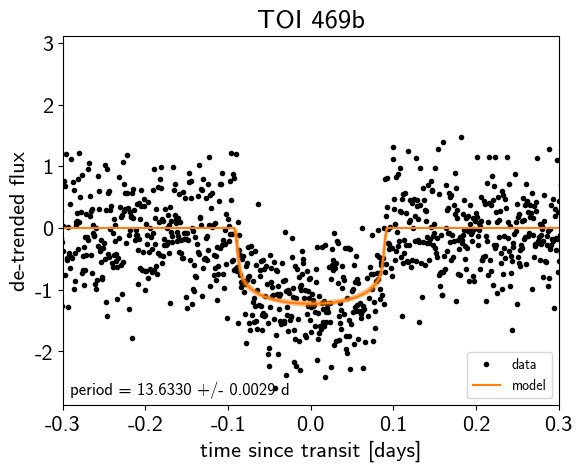

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

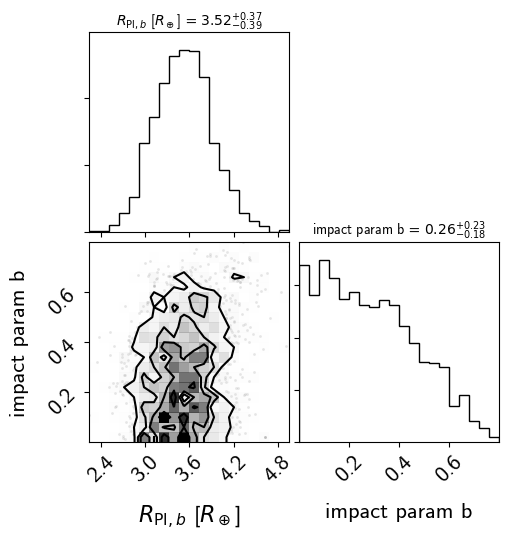

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

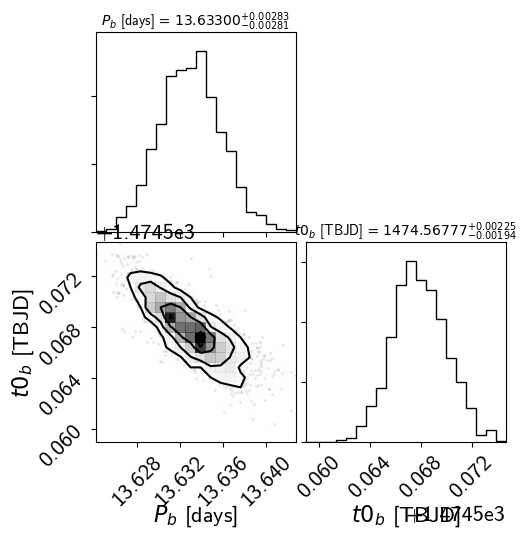

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

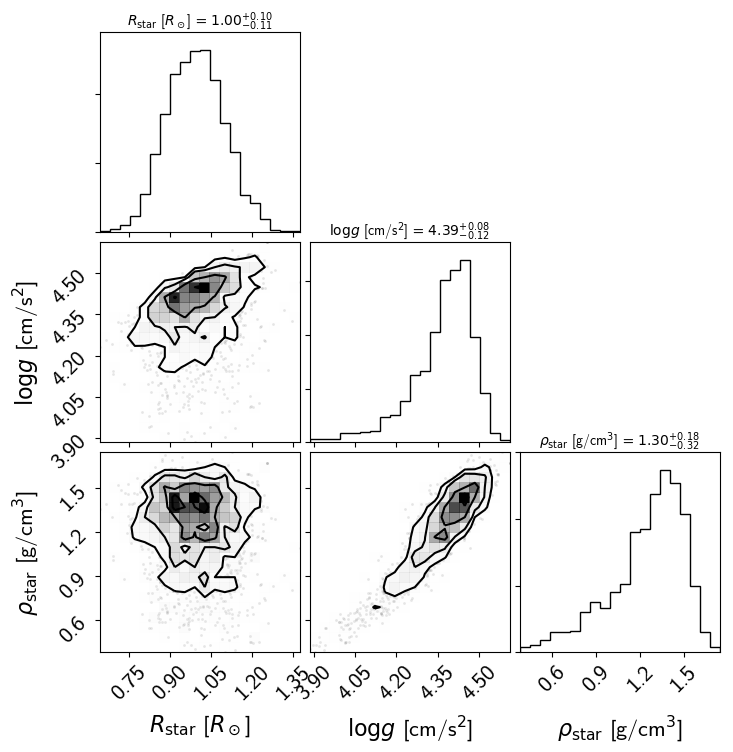

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3